#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [2]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 6
TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All192_Sclerotic'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 192

# BATCH_SIZE = 120
BATCH_SIZE = 1
EPOCHS = 1000

BASE_DIR = '/workspace/BoneMeta_all_192'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels_sclerotic'

DATAINFO_DIR = '/workspace/DataInfo'
DATAINFO_FILE = 'data_info_V_2022_04_27.csv'

In [3]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [4]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_192/images 317
/workspace/BoneMeta_all_192/labels_sclerotic 317


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = ['KH027_20210801_Chest(+).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000311_20190902_Chest_CT_(contrast).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000506_20201113_Chest_CT_(contrast).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH042_20210501_Chest(+).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', '000364_20191217_Chest_CT_(contrast).npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'KH023_20210901_Chest(+).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', '000224_20190228_Chest_CT_(contrast).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH016_20191101_Chest(+).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', '000356_20191024_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy', '000530_20210428_Chest_CT_(contrast).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH001_20210501_Chest(+).npy', 'KH031_20210801_Chest(+).npy', 'KH010_20201201_Chest(+).npy', '000370_20200117_Chest_CT_(contrast).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', '000080_20180911_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', '000085_20180829_Chest_CT_(contrast).npy', '000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', '000386_20200204_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000325_20190919_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_Chest(+).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', '000279_20190614_Chest_3DCT_(contrast).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', 'KH026_20210801_Chest(+).npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', '000322_20190913_Chest_CT_(contrast).npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy', 'KH037_20210401_Chest(+).npy', '000309_20190823_Chest_CT_(contrast).npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000424_20200218_Chest_CT_(contrast).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', '000262_20190529_Chest_CT_(contrast).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000481_20200722_Chest_CT_(noncontrast).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000409_20200310_Chest_CT_(contrast).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', '000560_20210706_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', '000506_20201110_CT_Urography_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH033_20210701_Chest(+).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000475_20210210_Chest_CT_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', '000278_20190620_Chest_CT_(contrast).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'KH032_20210701_Chest(+).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', '000242_20190409_Chest_CT_(contrast).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH036_20210401_Chest(+).npy', '000330_20190926_Chest_CT_(contrast).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', '000362_20191214_Chest_CT_(contrast).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH040_20210301_Chest(+).npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', '000069_20180319_Chest_CT_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000494_20210405_Chest_CT_(contrast).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH025_20211001_Chest(+).npy', '000021_20181227_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', '000011_20181207_Chest_CT_(contrast).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH024_20211001_Chest(+).npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH009_20200801_Chest(+).npy', '000376_20200114_Chest_CT_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH007_20200601_Chest(+).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', '000557_20210621_Chest_CT_(contrast).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', '000304_20190124_CT_Liver_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', '000541_20210520_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000481_20210409_CT_Liver_(contrast).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', '000533_20210507_CT_Liver_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', '000308_20190826_Chest_CT_(contrast).npy', 'KH038_20210401_Chest(+).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000344_20191125_Chest_CT_(contrast).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['BH099_20200806_Abdomen_&_pelvis_CT.npy', '000019_20181018_Chest_CT_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000251_20190429_Chest_CT_(contrast).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH027_20191001_L-spine_CT_(3D).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000285_20190807_Chest_CT_(contrast).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', '000193_20190114_Chest_CT_(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000316_20190627_Chest_CT_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy', '000450_20200512_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']
TEST_FILES = ['000214_20190325_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000236_20190401_CT_Abdomen+Pelvis_Post_(contrast).npy', '000244_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000314_20190827_Chest_CT_(contrast).npy', '000314_20190901_CT_Acute_Abdomen_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000383_20200121_Chest_CT_(contrast).npy', 'BH001_20190401_Chest_CT_(Non_contrast)_+_3D.npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH047_20180901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 238
val: 35
test: 30
total: 303



In [12]:
data_info = pd.read_csv(os.path.join(DATAINFO_DIR, DATAINFO_FILE))
lytic_index = data_info["Lesion Type"] == "S"
LYTIC_DATA_INFO = data_info.loc[lytic_index]
LYTIC_DATA_INFO.head(20)
using_index = LYTIC_DATA_INFO['Case'].isin([file_to_case(file) for file in IMG_FILES])
LYTIC_DATA_INFO = LYTIC_DATA_INFO.loc[using_index]
lytic_cases = list(LYTIC_DATA_INFO['Case'].unique())
len(lytic_cases)

LYTIC_FILES = [case+'.npy' for case in lytic_cases]

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(LYTIC_FILES)))
VAL_FILES = list(set(VAL_FILES).intersection(set(LYTIC_FILES)))
TEST_FILES = list(set(TEST_FILES).intersection(set(LYTIC_FILES)))

print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 111
val: 25
test: 13
total: 149



In [13]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [14]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [16]:
# len(train_dataset)

In [17]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [18]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [19]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 1.3561270499994862s
train: 111
val: 25



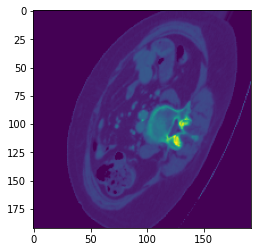

In [20]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

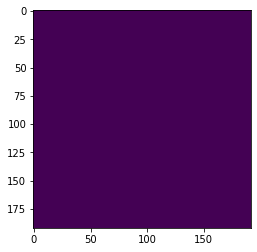

In [21]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [22]:
import multiprocessing
multiprocessing.cpu_count()

48

In [23]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [24]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [25]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [26]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [27]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00002)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [28]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

141494439

In [30]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

def diceLoss(prediction_g, label_g, epsilon=0.00001):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [31]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [32]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [33]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [34]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 20
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-05-29 17:53:00,125 INFO     pid:23996 3DUnet:001:<module> Starting traning...


In [35]:
for epoch_ndx in range(1, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-05-29 17:53:00,137 INFO     pid:23996 3DUnet:008:<module> Epoch 1 of 1000, 28/25 batches of size 1*4
2022-05-29 17:53:00,140 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1 Training ----/28, starting
2022-05-29 17:54:05,412 INFO     pid:23996 util.util:241:enumerateWithEstimate E1 Training   16/28, done at 2022-05-29 17:54:33, 0:00:51
2022-05-29 17:54:33,991 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1 Training ----/28, done at 2022-05-29 17:54:33
2022-05-29 17:54:33,994 INFO     pid:23996 3DUnet:007:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 17:54:33,996 INFO     pid:23996 3DUnet:043:logMetrics E1 trn      0.9972 loss, 0.0017 precision, 0.3278 recall, 0.0034 f1 score
2022-05-29 17:54:33,997 INFO     pid:23996 3DUnet:051:logMetrics E1 trn_all  0.9972 loss,  32.8% tp,  67.2% fn,   19079.7% fp
2022-05-29 17:54:34,009 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1 Validation  ----/25, starting
2022-05-29 17:54:41

2022-05-29 18:04:59,503 INFO     pid:23996 util.util:241:enumerateWithEstimate E9 Training   16/28, done at 2022-05-29 18:05:27, 0:00:51
2022-05-29 18:05:27,984 WARNING  pid:23996 util.util:252:enumerateWithEstimate E9 Training ----/28, done at 2022-05-29 18:05:27
2022-05-29 18:05:27,987 INFO     pid:23996 3DUnet:007:logMetrics E9 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 18:05:27,989 INFO     pid:23996 3DUnet:043:logMetrics E9 trn      0.9800 loss, 0.0275 precision, 0.2054 recall, 0.0485 f1 score
2022-05-29 18:05:27,990 INFO     pid:23996 3DUnet:051:logMetrics E9 trn_all  0.9800 loss,  20.5% tp,  79.5% fn,     726.0% fp
2022-05-29 18:05:27,995 INFO     pid:23996 3DUnet:008:<module> Epoch 10 of 1000, 28/25 batches of size 1*4
2022-05-29 18:05:27,999 WARNING  pid:23996 util.util:221:enumerateWithEstimate E10 Training ----/28, starting
2022-05-29 18:06:18,610 INFO     pid:23996 util.util:241:enumerateWithEstimate E10 Training   16/28, done at 2022-05-29 18:06:47,

2022-05-29 18:17:23,826 INFO     pid:23996 3DUnet:043:logMetrics E18 trn      0.9157 loss, 0.1124 precision, 0.5116 recall, 0.1844 f1 score
2022-05-29 18:17:23,827 INFO     pid:23996 3DUnet:051:logMetrics E18 trn_all  0.9157 loss,  51.2% tp,  48.8% fn,     403.8% fp
2022-05-29 18:17:23,832 INFO     pid:23996 3DUnet:008:<module> Epoch 19 of 1000, 28/25 batches of size 1*4
2022-05-29 18:17:23,836 WARNING  pid:23996 util.util:221:enumerateWithEstimate E19 Training ----/28, starting
2022-05-29 18:18:15,284 INFO     pid:23996 util.util:241:enumerateWithEstimate E19 Training   16/28, done at 2022-05-29 18:18:43, 0:00:51
2022-05-29 18:18:43,795 WARNING  pid:23996 util.util:252:enumerateWithEstimate E19 Training ----/28, done at 2022-05-29 18:18:43
2022-05-29 18:18:43,799 INFO     pid:23996 3DUnet:007:logMetrics E19 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 18:18:43,801 INFO     pid:23996 3DUnet:043:logMetrics E19 trn      0.9137 loss, 0.1108 precision, 0.5083 recall, 

2022-05-29 18:28:19,752 INFO     pid:23996 3DUnet:051:logMetrics E26 trn_all  0.8812 loss,  54.2% tp,  45.8% fn,     283.7% fp
2022-05-29 18:28:19,755 INFO     pid:23996 3DUnet:008:<module> Epoch 27 of 1000, 28/25 batches of size 1*4
2022-05-29 18:28:19,759 WARNING  pid:23996 util.util:221:enumerateWithEstimate E27 Training ----/28, starting
2022-05-29 18:29:10,459 INFO     pid:23996 util.util:241:enumerateWithEstimate E27 Training   16/28, done at 2022-05-29 18:29:38, 0:00:51
2022-05-29 18:29:39,008 WARNING  pid:23996 util.util:252:enumerateWithEstimate E27 Training ----/28, done at 2022-05-29 18:29:39
2022-05-29 18:29:39,010 INFO     pid:23996 3DUnet:007:logMetrics E27 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 18:29:39,010 INFO     pid:23996 3DUnet:043:logMetrics E27 trn      0.8782 loss, 0.1632 precision, 0.5176 recall, 0.2481 f1 score
2022-05-29 18:29:39,011 INFO     pid:23996 3DUnet:051:logMetrics E27 trn_all  0.8782 loss,  51.8% tp,  48.2% fn,     265.4% 

2022-05-29 18:41:06,886 INFO     pid:23996 util.util:241:enumerateWithEstimate E36 Training   16/28, done at 2022-05-29 18:41:35, 0:00:51
2022-05-29 18:41:35,421 WARNING  pid:23996 util.util:252:enumerateWithEstimate E36 Training ----/28, done at 2022-05-29 18:41:35
2022-05-29 18:41:35,424 INFO     pid:23996 3DUnet:007:logMetrics E36 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 18:41:35,426 INFO     pid:23996 3DUnet:043:logMetrics E36 trn      0.8438 loss, 0.2113 precision, 0.5653 recall, 0.3076 f1 score
2022-05-29 18:41:35,427 INFO     pid:23996 3DUnet:051:logMetrics E36 trn_all  0.8438 loss,  56.5% tp,  43.5% fn,     211.1% fp
2022-05-29 18:41:35,431 INFO     pid:23996 3DUnet:008:<module> Epoch 37 of 1000, 28/25 batches of size 1*4
2022-05-29 18:41:35,435 WARNING  pid:23996 util.util:221:enumerateWithEstimate E37 Training ----/28, starting
2022-05-29 18:42:26,496 INFO     pid:23996 util.util:241:enumerateWithEstimate E37 Training   16/28, done at 2022-05-29 18:4

2022-05-29 18:52:32,364 WARNING  pid:23996 util.util:252:enumerateWithEstimate E44 Training ----/28, done at 2022-05-29 18:52:32
2022-05-29 18:52:32,368 INFO     pid:23996 3DUnet:007:logMetrics E44 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 18:52:32,370 INFO     pid:23996 3DUnet:043:logMetrics E44 trn      0.8331 loss, 0.2306 precision, 0.5569 recall, 0.3261 f1 score
2022-05-29 18:52:32,371 INFO     pid:23996 3DUnet:051:logMetrics E44 trn_all  0.8331 loss,  55.7% tp,  44.3% fn,     185.9% fp
2022-05-29 18:52:32,375 INFO     pid:23996 3DUnet:008:<module> Epoch 45 of 1000, 28/25 batches of size 1*4
2022-05-29 18:52:32,379 WARNING  pid:23996 util.util:221:enumerateWithEstimate E45 Training ----/28, starting
2022-05-29 18:53:23,948 INFO     pid:23996 util.util:241:enumerateWithEstimate E45 Training   16/28, done at 2022-05-29 18:53:52, 0:00:51
2022-05-29 18:53:52,507 WARNING  pid:23996 util.util:252:enumerateWithEstimate E45 Training ----/28, done at 2022-05-29 18:5

2022-05-29 19:04:26,415 INFO     pid:23996 3DUnet:051:logMetrics E53 trn_all  0.7865 loss,  59.1% tp,  40.9% fn,     124.3% fp
2022-05-29 19:04:26,419 INFO     pid:23996 3DUnet:008:<module> Epoch 54 of 1000, 28/25 batches of size 1*4
2022-05-29 19:04:26,423 WARNING  pid:23996 util.util:221:enumerateWithEstimate E54 Training ----/28, starting
2022-05-29 19:05:17,109 INFO     pid:23996 util.util:241:enumerateWithEstimate E54 Training   16/28, done at 2022-05-29 19:05:45, 0:00:51
2022-05-29 19:05:45,650 WARNING  pid:23996 util.util:252:enumerateWithEstimate E54 Training ----/28, done at 2022-05-29 19:05:45
2022-05-29 19:05:45,653 INFO     pid:23996 3DUnet:007:logMetrics E54 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 19:05:45,654 INFO     pid:23996 3DUnet:043:logMetrics E54 trn      0.7885 loss, 0.3132 precision, 0.5620 recall, 0.4022 f1 score
2022-05-29 19:05:45,656 INFO     pid:23996 3DUnet:051:logMetrics E54 trn_all  0.7885 loss,  56.2% tp,  43.8% fn,     123.2% 

2022-05-29 19:15:21,052 INFO     pid:23996 3DUnet:008:<module> Epoch 62 of 1000, 28/25 batches of size 1*4
2022-05-29 19:15:21,056 WARNING  pid:23996 util.util:221:enumerateWithEstimate E62 Training ----/28, starting
2022-05-29 19:16:11,376 INFO     pid:23996 util.util:241:enumerateWithEstimate E62 Training   16/28, done at 2022-05-29 19:16:39, 0:00:51
2022-05-29 19:16:39,905 WARNING  pid:23996 util.util:252:enumerateWithEstimate E62 Training ----/28, done at 2022-05-29 19:16:39
2022-05-29 19:16:39,908 INFO     pid:23996 3DUnet:007:logMetrics E62 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 19:16:39,909 INFO     pid:23996 3DUnet:043:logMetrics E62 trn      0.7486 loss, 0.3766 precision, 0.5624 recall, 0.4511 f1 score
2022-05-29 19:16:39,910 INFO     pid:23996 3DUnet:051:logMetrics E62 trn_all  0.7486 loss,  56.2% tp,  43.8% fn,      93.1% fp
2022-05-29 19:16:39,914 INFO     pid:23996 3DUnet:008:<module> Epoch 63 of 1000, 28/25 batches of size 1*4
2022-05-29 19:16:

2022-05-29 19:28:35,167 WARNING  pid:23996 util.util:252:enumerateWithEstimate E71 Training ----/28, done at 2022-05-29 19:28:35
2022-05-29 19:28:35,171 INFO     pid:23996 3DUnet:007:logMetrics E71 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 19:28:35,173 INFO     pid:23996 3DUnet:043:logMetrics E71 trn      0.7092 loss, 0.4346 precision, 0.5467 recall, 0.4843 f1 score
2022-05-29 19:28:35,174 INFO     pid:23996 3DUnet:051:logMetrics E71 trn_all  0.7092 loss,  54.7% tp,  45.3% fn,      71.1% fp
2022-05-29 19:28:35,179 INFO     pid:23996 3DUnet:008:<module> Epoch 72 of 1000, 28/25 batches of size 1*4
2022-05-29 19:28:35,183 WARNING  pid:23996 util.util:221:enumerateWithEstimate E72 Training ----/28, starting
2022-05-29 19:29:26,695 INFO     pid:23996 util.util:241:enumerateWithEstimate E72 Training   16/28, done at 2022-05-29 19:29:55, 0:00:51
2022-05-29 19:29:55,221 WARNING  pid:23996 util.util:252:enumerateWithEstimate E72 Training ----/28, done at 2022-05-29 19:2

2022-05-29 19:40:30,467 INFO     pid:23996 3DUnet:051:logMetrics E80 trn_all  0.6933 loss,  55.1% tp,  44.9% fn,      63.5% fp
2022-05-29 19:40:30,473 WARNING  pid:23996 util.util:221:enumerateWithEstimate E80 Validation  ----/25, starting
2022-05-29 19:40:38,223 INFO     pid:23996 util.util:241:enumerateWithEstimate E80 Validation    16/25, done at 2022-05-29 19:40:41, 0:00:07
2022-05-29 19:40:42,116 WARNING  pid:23996 util.util:252:enumerateWithEstimate E80 Validation  ----/25, done at 2022-05-29 19:40:42
2022-05-29 19:40:43,315 INFO     pid:23996 3DUnet:007:logMetrics E80 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 19:40:43,316 INFO     pid:23996 3DUnet:043:logMetrics E80 val      0.7044 loss, 0.2444 precision, 0.6902 recall, 0.3610 f1 score
2022-05-29 19:40:43,318 INFO     pid:23996 3DUnet:051:logMetrics E80 val_all  0.7044 loss,  69.0% tp,  31.0% fn,     213.4% fp
2022-05-29 19:40:47,145 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/B

2022-05-29 19:51:25,949 INFO     pid:23996 3DUnet:008:<module> Epoch 89 of 1000, 28/25 batches of size 1*4
2022-05-29 19:51:25,953 WARNING  pid:23996 util.util:221:enumerateWithEstimate E89 Training ----/28, starting
2022-05-29 19:52:16,942 INFO     pid:23996 util.util:241:enumerateWithEstimate E89 Training   16/28, done at 2022-05-29 19:52:45, 0:00:51
2022-05-29 19:52:45,455 WARNING  pid:23996 util.util:252:enumerateWithEstimate E89 Training ----/28, done at 2022-05-29 19:52:45
2022-05-29 19:52:45,460 INFO     pid:23996 3DUnet:007:logMetrics E89 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 19:52:45,462 INFO     pid:23996 3DUnet:043:logMetrics E89 trn      0.6855 loss, 0.4780 precision, 0.5843 recall, 0.5259 f1 score
2022-05-29 19:52:45,463 INFO     pid:23996 3DUnet:051:logMetrics E89 trn_all  0.6855 loss,  58.4% tp,  41.6% fn,      63.8% fp
2022-05-29 19:52:45,468 INFO     pid:23996 3DUnet:008:<module> Epoch 90 of 1000, 28/25 batches of size 1*4
2022-05-29 19:52:

2022-05-29 20:04:41,221 WARNING  pid:23996 util.util:252:enumerateWithEstimate E98 Training ----/28, done at 2022-05-29 20:04:41
2022-05-29 20:04:41,225 INFO     pid:23996 3DUnet:007:logMetrics E98 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 20:04:41,227 INFO     pid:23996 3DUnet:043:logMetrics E98 trn      0.6677 loss, 0.5342 precision, 0.5730 recall, 0.5529 f1 score
2022-05-29 20:04:41,228 INFO     pid:23996 3DUnet:051:logMetrics E98 trn_all  0.6677 loss,  57.3% tp,  42.7% fn,      50.0% fp
2022-05-29 20:04:41,232 INFO     pid:23996 3DUnet:008:<module> Epoch 99 of 1000, 28/25 batches of size 1*4
2022-05-29 20:04:41,236 WARNING  pid:23996 util.util:221:enumerateWithEstimate E99 Training ----/28, starting
2022-05-29 20:05:32,195 INFO     pid:23996 util.util:241:enumerateWithEstimate E99 Training   16/28, done at 2022-05-29 20:06:00, 0:00:51
2022-05-29 20:06:00,727 WARNING  pid:23996 util.util:252:enumerateWithEstimate E99 Training ----/28, done at 2022-05-29 20:0

2022-05-29 20:15:37,405 INFO     pid:23996 3DUnet:007:logMetrics E106 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 20:15:37,407 INFO     pid:23996 3DUnet:043:logMetrics E106 trn      0.6940 loss, 0.4937 precision, 0.4304 recall, 0.4599 f1 score
2022-05-29 20:15:37,408 INFO     pid:23996 3DUnet:051:logMetrics E106 trn_all  0.6940 loss,  43.0% tp,  57.0% fn,      44.1% fp
2022-05-29 20:15:37,413 INFO     pid:23996 3DUnet:008:<module> Epoch 107 of 1000, 28/25 batches of size 1*4
2022-05-29 20:15:37,417 WARNING  pid:23996 util.util:221:enumerateWithEstimate E107 Training ----/28, starting
2022-05-29 20:16:28,594 INFO     pid:23996 util.util:241:enumerateWithEstimate E107 Training   16/28, done at 2022-05-29 20:16:57, 0:00:51
2022-05-29 20:16:57,134 WARNING  pid:23996 util.util:252:enumerateWithEstimate E107 Training ----/28, done at 2022-05-29 20:16:57
2022-05-29 20:16:57,138 INFO     pid:23996 3DUnet:007:logMetrics E107 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-29 20:27:33,487 INFO     pid:23996 3DUnet:051:logMetrics E115 trn_all  0.6644 loss,  54.6% tp,  45.4% fn,      46.0% fp
2022-05-29 20:27:33,492 INFO     pid:23996 3DUnet:008:<module> Epoch 116 of 1000, 28/25 batches of size 1*4
2022-05-29 20:27:33,496 WARNING  pid:23996 util.util:221:enumerateWithEstimate E116 Training ----/28, starting
2022-05-29 20:28:24,009 INFO     pid:23996 util.util:241:enumerateWithEstimate E116 Training   16/28, done at 2022-05-29 20:28:52, 0:00:51
2022-05-29 20:28:52,534 WARNING  pid:23996 util.util:252:enumerateWithEstimate E116 Training ----/28, done at 2022-05-29 20:28:52
2022-05-29 20:28:52,538 INFO     pid:23996 3DUnet:007:logMetrics E116 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 20:28:52,539 INFO     pid:23996 3DUnet:043:logMetrics E116 trn      0.6518 loss, 0.5309 precision, 0.5769 recall, 0.5529 f1 score
2022-05-29 20:28:52,540 INFO     pid:23996 3DUnet:051:logMetrics E116 trn_all  0.6518 loss,  57.7% tp,  42.3% fn,    

2022-05-29 20:38:27,378 INFO     pid:23996 3DUnet:008:<module> Epoch 124 of 1000, 28/25 batches of size 1*4
2022-05-29 20:38:27,382 WARNING  pid:23996 util.util:221:enumerateWithEstimate E124 Training ----/28, starting
2022-05-29 20:39:18,473 INFO     pid:23996 util.util:241:enumerateWithEstimate E124 Training   16/28, done at 2022-05-29 20:39:46, 0:00:51
2022-05-29 20:39:47,009 WARNING  pid:23996 util.util:252:enumerateWithEstimate E124 Training ----/28, done at 2022-05-29 20:39:47
2022-05-29 20:39:47,013 INFO     pid:23996 3DUnet:007:logMetrics E124 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 20:39:47,015 INFO     pid:23996 3DUnet:043:logMetrics E124 trn      0.6566 loss, 0.5323 precision, 0.5333 recall, 0.5328 f1 score
2022-05-29 20:39:47,016 INFO     pid:23996 3DUnet:051:logMetrics E124 trn_all  0.6566 loss,  53.3% tp,  46.7% fn,      46.8% fp
2022-05-29 20:39:47,020 INFO     pid:23996 3DUnet:008:<module> Epoch 125 of 1000, 28/25 batches of size 1*4
2022-05-2

2022-05-29 20:51:42,863 WARNING  pid:23996 util.util:252:enumerateWithEstimate E133 Training ----/28, done at 2022-05-29 20:51:42
2022-05-29 20:51:42,866 INFO     pid:23996 3DUnet:007:logMetrics E133 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 20:51:42,867 INFO     pid:23996 3DUnet:043:logMetrics E133 trn      0.6389 loss, 0.5390 precision, 0.5612 recall, 0.5499 f1 score
2022-05-29 20:51:42,868 INFO     pid:23996 3DUnet:051:logMetrics E133 trn_all  0.6389 loss,  56.1% tp,  43.9% fn,      48.0% fp
2022-05-29 20:51:42,872 INFO     pid:23996 3DUnet:008:<module> Epoch 134 of 1000, 28/25 batches of size 1*4
2022-05-29 20:51:42,876 WARNING  pid:23996 util.util:221:enumerateWithEstimate E134 Training ----/28, starting
2022-05-29 20:52:33,218 INFO     pid:23996 util.util:241:enumerateWithEstimate E134 Training   16/28, done at 2022-05-29 20:53:01, 0:00:51
2022-05-29 20:53:01,751 WARNING  pid:23996 util.util:252:enumerateWithEstimate E134 Training ----/28, done at 2022-05

2022-05-29 21:02:36,617 INFO     pid:23996 3DUnet:007:logMetrics E141 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 21:02:36,619 INFO     pid:23996 3DUnet:043:logMetrics E141 trn      0.6166 loss, 0.5784 precision, 0.5621 recall, 0.5701 f1 score
2022-05-29 21:02:36,620 INFO     pid:23996 3DUnet:051:logMetrics E141 trn_all  0.6166 loss,  56.2% tp,  43.8% fn,      41.0% fp
2022-05-29 21:02:36,624 INFO     pid:23996 3DUnet:008:<module> Epoch 142 of 1000, 28/25 batches of size 1*4
2022-05-29 21:02:36,628 WARNING  pid:23996 util.util:221:enumerateWithEstimate E142 Training ----/28, starting
2022-05-29 21:03:28,006 INFO     pid:23996 util.util:241:enumerateWithEstimate E142 Training   16/28, done at 2022-05-29 21:03:56, 0:00:51
2022-05-29 21:03:56,553 WARNING  pid:23996 util.util:252:enumerateWithEstimate E142 Training ----/28, done at 2022-05-29 21:03:56
2022-05-29 21:03:56,555 INFO     pid:23996 3DUnet:007:logMetrics E142 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-29 21:14:31,233 INFO     pid:23996 3DUnet:051:logMetrics E150 trn_all  0.6150 loss,  58.2% tp,  41.8% fn,      47.6% fp
2022-05-29 21:14:31,237 INFO     pid:23996 3DUnet:008:<module> Epoch 151 of 1000, 28/25 batches of size 1*4
2022-05-29 21:14:31,241 WARNING  pid:23996 util.util:221:enumerateWithEstimate E151 Training ----/28, starting
2022-05-29 21:15:21,621 INFO     pid:23996 util.util:241:enumerateWithEstimate E151 Training   16/28, done at 2022-05-29 21:15:50, 0:00:51
2022-05-29 21:15:50,151 WARNING  pid:23996 util.util:252:enumerateWithEstimate E151 Training ----/28, done at 2022-05-29 21:15:50
2022-05-29 21:15:50,154 INFO     pid:23996 3DUnet:007:logMetrics E151 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 21:15:50,156 INFO     pid:23996 3DUnet:043:logMetrics E151 trn      0.6299 loss, 0.5439 precision, 0.5027 recall, 0.5225 f1 score
2022-05-29 21:15:50,157 INFO     pid:23996 3DUnet:051:logMetrics E151 trn_all  0.6299 loss,  50.3% tp,  49.7% fn,    

2022-05-29 21:27:15,910 INFO     pid:23996 util.util:241:enumerateWithEstimate E160 Training   16/28, done at 2022-05-29 21:27:44, 0:00:51
2022-05-29 21:27:44,394 WARNING  pid:23996 util.util:252:enumerateWithEstimate E160 Training ----/28, done at 2022-05-29 21:27:44
2022-05-29 21:27:44,397 INFO     pid:23996 3DUnet:007:logMetrics E160 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 21:27:44,398 INFO     pid:23996 3DUnet:043:logMetrics E160 trn      0.6158 loss, 0.5513 precision, 0.6151 recall, 0.5815 f1 score
2022-05-29 21:27:44,399 INFO     pid:23996 3DUnet:051:logMetrics E160 trn_all  0.6158 loss,  61.5% tp,  38.5% fn,      50.1% fp
2022-05-29 21:27:44,405 WARNING  pid:23996 util.util:221:enumerateWithEstimate E160 Validation  ----/25, starting
2022-05-29 21:27:52,042 INFO     pid:23996 util.util:241:enumerateWithEstimate E160 Validation    16/25, done at 2022-05-29 21:27:55, 0:00:07
2022-05-29 21:27:55,936 WARNING  pid:23996 util.util:252:enumerateWithEstimate E

2022-05-29 21:38:40,746 WARNING  pid:23996 util.util:252:enumerateWithEstimate E168 Training ----/28, done at 2022-05-29 21:38:40
2022-05-29 21:38:40,748 INFO     pid:23996 3DUnet:007:logMetrics E168 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 21:38:40,750 INFO     pid:23996 3DUnet:043:logMetrics E168 trn      0.6156 loss, 0.4862 precision, 0.5988 recall, 0.5366 f1 score
2022-05-29 21:38:40,751 INFO     pid:23996 3DUnet:051:logMetrics E168 trn_all  0.6156 loss,  59.9% tp,  40.1% fn,      63.3% fp
2022-05-29 21:38:40,754 INFO     pid:23996 3DUnet:008:<module> Epoch 169 of 1000, 28/25 batches of size 1*4
2022-05-29 21:38:40,757 WARNING  pid:23996 util.util:221:enumerateWithEstimate E169 Training ----/28, starting
2022-05-29 21:39:32,497 INFO     pid:23996 util.util:241:enumerateWithEstimate E169 Training   16/28, done at 2022-05-29 21:40:00, 0:00:51
2022-05-29 21:40:01,038 WARNING  pid:23996 util.util:252:enumerateWithEstimate E169 Training ----/28, done at 2022-05

2022-05-29 21:50:38,230 INFO     pid:23996 3DUnet:043:logMetrics E177 trn      0.5947 loss, 0.5882 precision, 0.5444 recall, 0.5655 f1 score
2022-05-29 21:50:38,231 INFO     pid:23996 3DUnet:051:logMetrics E177 trn_all  0.5947 loss,  54.4% tp,  45.6% fn,      38.1% fp
2022-05-29 21:50:38,235 INFO     pid:23996 3DUnet:008:<module> Epoch 178 of 1000, 28/25 batches of size 1*4
2022-05-29 21:50:38,238 WARNING  pid:23996 util.util:221:enumerateWithEstimate E178 Training ----/28, starting
2022-05-29 21:51:28,820 INFO     pid:23996 util.util:241:enumerateWithEstimate E178 Training   16/28, done at 2022-05-29 21:51:57, 0:00:51
2022-05-29 21:51:57,341 WARNING  pid:23996 util.util:252:enumerateWithEstimate E178 Training ----/28, done at 2022-05-29 21:51:57
2022-05-29 21:51:57,344 INFO     pid:23996 3DUnet:007:logMetrics E178 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 21:51:57,345 INFO     pid:23996 3DUnet:043:logMetrics E178 trn      0.5836 loss, 0.5496 precision, 0.5927 

2022-05-29 22:01:33,200 INFO     pid:23996 3DUnet:051:logMetrics E185 trn_all  0.5991 loss,  59.1% tp,  40.9% fn,      40.4% fp
2022-05-29 22:01:33,204 INFO     pid:23996 3DUnet:008:<module> Epoch 186 of 1000, 28/25 batches of size 1*4
2022-05-29 22:01:33,208 WARNING  pid:23996 util.util:221:enumerateWithEstimate E186 Training ----/28, starting
2022-05-29 22:02:23,555 INFO     pid:23996 util.util:241:enumerateWithEstimate E186 Training   16/28, done at 2022-05-29 22:02:52, 0:00:51
2022-05-29 22:02:52,097 WARNING  pid:23996 util.util:252:enumerateWithEstimate E186 Training ----/28, done at 2022-05-29 22:02:52
2022-05-29 22:02:52,100 INFO     pid:23996 3DUnet:007:logMetrics E186 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 22:02:52,103 INFO     pid:23996 3DUnet:043:logMetrics E186 trn      0.6087 loss, 0.5407 precision, 0.6088 recall, 0.5727 f1 score
2022-05-29 22:02:52,104 INFO     pid:23996 3DUnet:051:logMetrics E186 trn_all  0.6087 loss,  60.9% tp,  39.1% fn,    

2022-05-29 22:14:17,370 INFO     pid:23996 util.util:241:enumerateWithEstimate E195 Training   16/28, done at 2022-05-29 22:14:45, 0:00:51
2022-05-29 22:14:45,929 WARNING  pid:23996 util.util:252:enumerateWithEstimate E195 Training ----/28, done at 2022-05-29 22:14:45
2022-05-29 22:14:45,932 INFO     pid:23996 3DUnet:007:logMetrics E195 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 22:14:45,934 INFO     pid:23996 3DUnet:043:logMetrics E195 trn      0.6037 loss, 0.5781 precision, 0.5953 recall, 0.5866 f1 score
2022-05-29 22:14:45,935 INFO     pid:23996 3DUnet:051:logMetrics E195 trn_all  0.6037 loss,  59.5% tp,  40.5% fn,      43.5% fp
2022-05-29 22:14:45,940 INFO     pid:23996 3DUnet:008:<module> Epoch 196 of 1000, 28/25 batches of size 1*4
2022-05-29 22:14:45,944 WARNING  pid:23996 util.util:221:enumerateWithEstimate E196 Training ----/28, starting
2022-05-29 22:15:37,352 INFO     pid:23996 util.util:241:enumerateWithEstimate E196 Training   16/28, done at 2022-05

2022-05-29 22:25:42,581 WARNING  pid:23996 util.util:252:enumerateWithEstimate E203 Training ----/28, done at 2022-05-29 22:25:42
2022-05-29 22:25:42,585 INFO     pid:23996 3DUnet:007:logMetrics E203 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 22:25:42,586 INFO     pid:23996 3DUnet:043:logMetrics E203 trn      0.5948 loss, 0.5810 precision, 0.5915 recall, 0.5862 f1 score
2022-05-29 22:25:42,587 INFO     pid:23996 3DUnet:051:logMetrics E203 trn_all  0.5948 loss,  59.1% tp,  40.9% fn,      42.6% fp
2022-05-29 22:25:42,592 INFO     pid:23996 3DUnet:008:<module> Epoch 204 of 1000, 28/25 batches of size 1*4
2022-05-29 22:25:42,596 WARNING  pid:23996 util.util:221:enumerateWithEstimate E204 Training ----/28, starting
2022-05-29 22:26:32,959 INFO     pid:23996 util.util:241:enumerateWithEstimate E204 Training   16/28, done at 2022-05-29 22:27:01, 0:00:51
2022-05-29 22:27:01,507 WARNING  pid:23996 util.util:252:enumerateWithEstimate E204 Training ----/28, done at 2022-05

2022-05-29 22:37:37,885 INFO     pid:23996 3DUnet:043:logMetrics E212 trn      0.5822 loss, 0.5842 precision, 0.6093 recall, 0.5965 f1 score
2022-05-29 22:37:37,886 INFO     pid:23996 3DUnet:051:logMetrics E212 trn_all  0.5822 loss,  60.9% tp,  39.1% fn,      43.4% fp
2022-05-29 22:37:37,890 INFO     pid:23996 3DUnet:008:<module> Epoch 213 of 1000, 28/25 batches of size 1*4
2022-05-29 22:37:37,895 WARNING  pid:23996 util.util:221:enumerateWithEstimate E213 Training ----/28, starting
2022-05-29 22:38:28,836 INFO     pid:23996 util.util:241:enumerateWithEstimate E213 Training   16/28, done at 2022-05-29 22:38:57, 0:00:51
2022-05-29 22:38:57,362 WARNING  pid:23996 util.util:252:enumerateWithEstimate E213 Training ----/28, done at 2022-05-29 22:38:57
2022-05-29 22:38:57,366 INFO     pid:23996 3DUnet:007:logMetrics E213 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 22:38:57,368 INFO     pid:23996 3DUnet:043:logMetrics E213 trn      0.5769 loss, 0.5863 precision, 0.6135 

2022-05-29 22:48:32,527 INFO     pid:23996 3DUnet:032:saveModel SHA1: bebc6afa37f97f26590be19815f24055b3de5e63
2022-05-29 22:48:32,528 INFO     pid:23996 3DUnet:008:<module> Epoch 221 of 1000, 28/25 batches of size 1*4
2022-05-29 22:48:32,531 WARNING  pid:23996 util.util:221:enumerateWithEstimate E221 Training ----/28, starting
2022-05-29 22:49:22,704 INFO     pid:23996 util.util:241:enumerateWithEstimate E221 Training   16/28, done at 2022-05-29 22:49:51, 0:00:51
2022-05-29 22:49:51,212 WARNING  pid:23996 util.util:252:enumerateWithEstimate E221 Training ----/28, done at 2022-05-29 22:49:51
2022-05-29 22:49:51,214 INFO     pid:23996 3DUnet:007:logMetrics E221 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 22:49:51,215 INFO     pid:23996 3DUnet:043:logMetrics E221 trn      0.5831 loss, 0.6136 precision, 0.5864 recall, 0.5997 f1 score
2022-05-29 22:49:51,216 INFO     pid:23996 3DUnet:051:logMetrics E221 trn_all  0.5831 loss,  58.6% tp,  41.4% fn,      36.9% fp
2022-0

2022-05-29 23:01:17,134 INFO     pid:23996 util.util:241:enumerateWithEstimate E230 Training   16/28, done at 2022-05-29 23:01:45, 0:00:51
2022-05-29 23:01:45,637 WARNING  pid:23996 util.util:252:enumerateWithEstimate E230 Training ----/28, done at 2022-05-29 23:01:45
2022-05-29 23:01:45,640 INFO     pid:23996 3DUnet:007:logMetrics E230 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 23:01:45,642 INFO     pid:23996 3DUnet:043:logMetrics E230 trn      0.5608 loss, 0.6014 precision, 0.6713 recall, 0.6344 f1 score
2022-05-29 23:01:45,643 INFO     pid:23996 3DUnet:051:logMetrics E230 trn_all  0.5608 loss,  67.1% tp,  32.9% fn,      44.5% fp
2022-05-29 23:01:45,647 INFO     pid:23996 3DUnet:008:<module> Epoch 231 of 1000, 28/25 batches of size 1*4
2022-05-29 23:01:45,651 WARNING  pid:23996 util.util:221:enumerateWithEstimate E231 Training ----/28, starting
2022-05-29 23:02:36,560 INFO     pid:23996 util.util:241:enumerateWithEstimate E231 Training   16/28, done at 2022-05

2022-05-29 23:13:41,721 INFO     pid:23996 3DUnet:007:logMetrics E239 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 23:13:41,723 INFO     pid:23996 3DUnet:043:logMetrics E239 trn      0.5700 loss, 0.5595 precision, 0.6334 recall, 0.5941 f1 score
2022-05-29 23:13:41,724 INFO     pid:23996 3DUnet:051:logMetrics E239 trn_all  0.5700 loss,  63.3% tp,  36.7% fn,      49.9% fp
2022-05-29 23:13:41,728 INFO     pid:23996 3DUnet:008:<module> Epoch 240 of 1000, 28/25 batches of size 1*4
2022-05-29 23:13:41,732 WARNING  pid:23996 util.util:221:enumerateWithEstimate E240 Training ----/28, starting
2022-05-29 23:14:33,091 INFO     pid:23996 util.util:241:enumerateWithEstimate E240 Training   16/28, done at 2022-05-29 23:15:01, 0:00:51
2022-05-29 23:15:01,647 WARNING  pid:23996 util.util:252:enumerateWithEstimate E240 Training ----/28, done at 2022-05-29 23:15:01
2022-05-29 23:15:01,651 INFO     pid:23996 3DUnet:007:logMetrics E240 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-29 23:24:36,272 INFO     pid:23996 3DUnet:043:logMetrics E247 trn      0.5570 loss, 0.6160 precision, 0.5925 recall, 0.6040 f1 score
2022-05-29 23:24:36,273 INFO     pid:23996 3DUnet:051:logMetrics E247 trn_all  0.5570 loss,  59.2% tp,  40.8% fn,      36.9% fp
2022-05-29 23:24:36,275 INFO     pid:23996 3DUnet:008:<module> Epoch 248 of 1000, 28/25 batches of size 1*4
2022-05-29 23:24:36,276 WARNING  pid:23996 util.util:221:enumerateWithEstimate E248 Training ----/28, starting
2022-05-29 23:25:26,931 INFO     pid:23996 util.util:241:enumerateWithEstimate E248 Training   16/28, done at 2022-05-29 23:25:55, 0:00:51
2022-05-29 23:25:55,411 WARNING  pid:23996 util.util:252:enumerateWithEstimate E248 Training ----/28, done at 2022-05-29 23:25:55
2022-05-29 23:25:55,415 INFO     pid:23996 3DUnet:007:logMetrics E248 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 23:25:55,417 INFO     pid:23996 3DUnet:043:logMetrics E248 trn      0.5480 loss, 0.6465 precision, 0.6109 

2022-05-29 23:36:30,112 INFO     pid:23996 3DUnet:008:<module> Epoch 257 of 1000, 28/25 batches of size 1*4
2022-05-29 23:36:30,116 WARNING  pid:23996 util.util:221:enumerateWithEstimate E257 Training ----/28, starting
2022-05-29 23:37:20,889 INFO     pid:23996 util.util:241:enumerateWithEstimate E257 Training   16/28, done at 2022-05-29 23:37:49, 0:00:51
2022-05-29 23:37:49,442 WARNING  pid:23996 util.util:252:enumerateWithEstimate E257 Training ----/28, done at 2022-05-29 23:37:49
2022-05-29 23:37:49,445 INFO     pid:23996 3DUnet:007:logMetrics E257 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 23:37:49,446 INFO     pid:23996 3DUnet:043:logMetrics E257 trn      0.5403 loss, 0.6496 precision, 0.6235 recall, 0.6363 f1 score
2022-05-29 23:37:49,446 INFO     pid:23996 3DUnet:051:logMetrics E257 trn_all  0.5403 loss,  62.4% tp,  37.6% fn,      33.6% fp
2022-05-29 23:37:49,450 INFO     pid:23996 3DUnet:008:<module> Epoch 258 of 1000, 28/25 batches of size 1*4
2022-05-2

2022-05-29 23:47:26,252 WARNING  pid:23996 util.util:221:enumerateWithEstimate E265 Training ----/28, starting
2022-05-29 23:48:16,776 INFO     pid:23996 util.util:241:enumerateWithEstimate E265 Training   16/28, done at 2022-05-29 23:48:45, 0:00:51
2022-05-29 23:48:45,307 WARNING  pid:23996 util.util:252:enumerateWithEstimate E265 Training ----/28, done at 2022-05-29 23:48:45
2022-05-29 23:48:45,310 INFO     pid:23996 3DUnet:007:logMetrics E265 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-29 23:48:45,312 INFO     pid:23996 3DUnet:043:logMetrics E265 trn      0.5550 loss, 0.6155 precision, 0.6408 recall, 0.6279 f1 score
2022-05-29 23:48:45,313 INFO     pid:23996 3DUnet:051:logMetrics E265 trn_all  0.5550 loss,  64.1% tp,  35.9% fn,      40.0% fp
2022-05-29 23:48:45,317 INFO     pid:23996 3DUnet:008:<module> Epoch 266 of 1000, 28/25 batches of size 1*4
2022-05-29 23:48:45,321 WARNING  pid:23996 util.util:221:enumerateWithEstimate E266 Training ----/28, starting
2022-0

2022-05-30 00:00:40,875 WARNING  pid:23996 util.util:252:enumerateWithEstimate E274 Training ----/28, done at 2022-05-30 00:00:40
2022-05-30 00:00:40,878 INFO     pid:23996 3DUnet:007:logMetrics E274 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 00:00:40,880 INFO     pid:23996 3DUnet:043:logMetrics E274 trn      0.5257 loss, 0.6466 precision, 0.6529 recall, 0.6497 f1 score
2022-05-30 00:00:40,881 INFO     pid:23996 3DUnet:051:logMetrics E274 trn_all  0.5257 loss,  65.3% tp,  34.7% fn,      35.7% fp
2022-05-30 00:00:40,885 INFO     pid:23996 3DUnet:008:<module> Epoch 275 of 1000, 28/25 batches of size 1*4
2022-05-30 00:00:40,889 WARNING  pid:23996 util.util:221:enumerateWithEstimate E275 Training ----/28, starting
2022-05-30 00:01:31,864 INFO     pid:23996 util.util:241:enumerateWithEstimate E275 Training   16/28, done at 2022-05-30 00:02:00, 0:00:51
2022-05-30 00:02:00,389 WARNING  pid:23996 util.util:252:enumerateWithEstimate E275 Training ----/28, done at 2022-05

2022-05-30 00:11:35,548 INFO     pid:23996 3DUnet:007:logMetrics E282 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 00:11:35,550 INFO     pid:23996 3DUnet:043:logMetrics E282 trn      0.5516 loss, 0.6431 precision, 0.5993 recall, 0.6204 f1 score
2022-05-30 00:11:35,551 INFO     pid:23996 3DUnet:051:logMetrics E282 trn_all  0.5516 loss,  59.9% tp,  40.1% fn,      33.3% fp
2022-05-30 00:11:35,555 INFO     pid:23996 3DUnet:008:<module> Epoch 283 of 1000, 28/25 batches of size 1*4
2022-05-30 00:11:35,559 WARNING  pid:23996 util.util:221:enumerateWithEstimate E283 Training ----/28, starting
2022-05-30 00:12:26,864 INFO     pid:23996 util.util:241:enumerateWithEstimate E283 Training   16/28, done at 2022-05-30 00:12:55, 0:00:51
2022-05-30 00:12:55,386 WARNING  pid:23996 util.util:252:enumerateWithEstimate E283 Training ----/28, done at 2022-05-30 00:12:55
2022-05-30 00:12:55,389 INFO     pid:23996 3DUnet:007:logMetrics E283 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 00:23:31,282 INFO     pid:23996 3DUnet:051:logMetrics E291 trn_all  0.5590 loss,  62.8% tp,  37.2% fn,      34.3% fp
2022-05-30 00:23:31,287 INFO     pid:23996 3DUnet:008:<module> Epoch 292 of 1000, 28/25 batches of size 1*4
2022-05-30 00:23:31,291 WARNING  pid:23996 util.util:221:enumerateWithEstimate E292 Training ----/28, starting
2022-05-30 00:24:22,047 INFO     pid:23996 util.util:241:enumerateWithEstimate E292 Training   16/28, done at 2022-05-30 00:24:50, 0:00:51
2022-05-30 00:24:50,581 WARNING  pid:23996 util.util:252:enumerateWithEstimate E292 Training ----/28, done at 2022-05-30 00:24:50
2022-05-30 00:24:50,585 INFO     pid:23996 3DUnet:007:logMetrics E292 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 00:24:50,586 INFO     pid:23996 3DUnet:043:logMetrics E292 trn      0.5197 loss, 0.6534 precision, 0.6460 recall, 0.6497 f1 score
2022-05-30 00:24:50,587 INFO     pid:23996 3DUnet:051:logMetrics E292 trn_all  0.5197 loss,  64.6% tp,  35.4% fn,    

2022-05-30 00:35:35,264 WARNING  pid:23996 util.util:252:enumerateWithEstimate E300 Validation  ----/25, done at 2022-05-30 00:35:35
2022-05-30 00:35:36,469 INFO     pid:23996 3DUnet:007:logMetrics E300 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 00:35:36,470 INFO     pid:23996 3DUnet:043:logMetrics E300 val      0.5981 loss, 0.3573 precision, 0.6705 recall, 0.4662 f1 score
2022-05-30 00:35:36,471 INFO     pid:23996 3DUnet:051:logMetrics E300 val_all  0.5981 loss,  67.0% tp,  33.0% fn,     120.6% fp
2022-05-30 00:35:40,192 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch300
2022-05-30 00:35:43,057 INFO     pid:23996 3DUnet:032:saveModel SHA1: 75989018c292626c5081f3f5af93ae226d421319
2022-05-30 00:35:43,058 INFO     pid:23996 3DUnet:008:<module> Epoch 301 of 1000, 28/25 batches of size 1*4
2022-05-30 00:35:43,061 WARNING  pid:23996 util.util:221:enumerateWit

2022-05-30 00:47:38,865 WARNING  pid:23996 util.util:252:enumerateWithEstimate E309 Training ----/28, done at 2022-05-30 00:47:38
2022-05-30 00:47:38,867 INFO     pid:23996 3DUnet:007:logMetrics E309 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 00:47:38,869 INFO     pid:23996 3DUnet:043:logMetrics E309 trn      0.5197 loss, 0.6676 precision, 0.6641 recall, 0.6658 f1 score
2022-05-30 00:47:38,869 INFO     pid:23996 3DUnet:051:logMetrics E309 trn_all  0.5197 loss,  66.4% tp,  33.6% fn,      33.1% fp
2022-05-30 00:47:38,873 INFO     pid:23996 3DUnet:008:<module> Epoch 310 of 1000, 28/25 batches of size 1*4
2022-05-30 00:47:38,876 WARNING  pid:23996 util.util:221:enumerateWithEstimate E310 Training ----/28, starting
2022-05-30 00:48:30,356 INFO     pid:23996 util.util:241:enumerateWithEstimate E310 Training   16/28, done at 2022-05-30 00:48:58, 0:00:51
2022-05-30 00:48:58,884 WARNING  pid:23996 util.util:252:enumerateWithEstimate E310 Training ----/28, done at 2022-05

2022-05-30 00:59:35,720 INFO     pid:23996 3DUnet:043:logMetrics E318 trn      0.5355 loss, 0.6755 precision, 0.6352 recall, 0.6547 f1 score
2022-05-30 00:59:35,721 INFO     pid:23996 3DUnet:051:logMetrics E318 trn_all  0.5355 loss,  63.5% tp,  36.5% fn,      30.5% fp
2022-05-30 00:59:35,726 INFO     pid:23996 3DUnet:008:<module> Epoch 319 of 1000, 28/25 batches of size 1*4
2022-05-30 00:59:35,729 WARNING  pid:23996 util.util:221:enumerateWithEstimate E319 Training ----/28, starting
2022-05-30 01:00:27,230 INFO     pid:23996 util.util:241:enumerateWithEstimate E319 Training   16/28, done at 2022-05-30 01:00:55, 0:00:51
2022-05-30 01:00:55,756 WARNING  pid:23996 util.util:252:enumerateWithEstimate E319 Training ----/28, done at 2022-05-30 01:00:55
2022-05-30 01:00:55,760 INFO     pid:23996 3DUnet:007:logMetrics E319 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:00:55,761 INFO     pid:23996 3DUnet:043:logMetrics E319 trn      0.5292 loss, 0.6477 precision, 0.6609 

2022-05-30 01:10:31,405 INFO     pid:23996 3DUnet:051:logMetrics E326 trn_all  0.5350 loss,  65.0% tp,  35.0% fn,      31.9% fp
2022-05-30 01:10:31,410 INFO     pid:23996 3DUnet:008:<module> Epoch 327 of 1000, 28/25 batches of size 1*4
2022-05-30 01:10:31,414 WARNING  pid:23996 util.util:221:enumerateWithEstimate E327 Training ----/28, starting
2022-05-30 01:11:21,800 INFO     pid:23996 util.util:241:enumerateWithEstimate E327 Training   16/28, done at 2022-05-30 01:11:50, 0:00:51
2022-05-30 01:11:50,339 WARNING  pid:23996 util.util:252:enumerateWithEstimate E327 Training ----/28, done at 2022-05-30 01:11:50
2022-05-30 01:11:50,341 INFO     pid:23996 3DUnet:007:logMetrics E327 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:11:50,343 INFO     pid:23996 3DUnet:043:logMetrics E327 trn      0.5408 loss, 0.6733 precision, 0.6509 recall, 0.6619 f1 score
2022-05-30 01:11:50,343 INFO     pid:23996 3DUnet:051:logMetrics E327 trn_all  0.5408 loss,  65.1% tp,  34.9% fn,    

2022-05-30 01:23:16,791 INFO     pid:23996 util.util:241:enumerateWithEstimate E336 Training   16/28, done at 2022-05-30 01:23:45, 0:00:51
2022-05-30 01:23:45,323 WARNING  pid:23996 util.util:252:enumerateWithEstimate E336 Training ----/28, done at 2022-05-30 01:23:45
2022-05-30 01:23:45,328 INFO     pid:23996 3DUnet:007:logMetrics E336 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:23:45,329 INFO     pid:23996 3DUnet:043:logMetrics E336 trn      0.5081 loss, 0.6967 precision, 0.6244 recall, 0.6586 f1 score
2022-05-30 01:23:45,330 INFO     pid:23996 3DUnet:051:logMetrics E336 trn_all  0.5081 loss,  62.4% tp,  37.6% fn,      27.2% fp
2022-05-30 01:23:45,335 INFO     pid:23996 3DUnet:008:<module> Epoch 337 of 1000, 28/25 batches of size 1*4
2022-05-30 01:23:45,339 WARNING  pid:23996 util.util:221:enumerateWithEstimate E337 Training ----/28, starting
2022-05-30 01:24:36,318 INFO     pid:23996 util.util:241:enumerateWithEstimate E337 Training   16/28, done at 2022-05

2022-05-30 01:34:43,565 WARNING  pid:23996 util.util:252:enumerateWithEstimate E344 Training ----/28, done at 2022-05-30 01:34:43
2022-05-30 01:34:43,567 INFO     pid:23996 3DUnet:007:logMetrics E344 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:34:43,569 INFO     pid:23996 3DUnet:043:logMetrics E344 trn      0.5444 loss, 0.6873 precision, 0.6455 recall, 0.6658 f1 score
2022-05-30 01:34:43,571 INFO     pid:23996 3DUnet:051:logMetrics E344 trn_all  0.5444 loss,  64.6% tp,  35.4% fn,      29.4% fp
2022-05-30 01:34:43,575 INFO     pid:23996 3DUnet:008:<module> Epoch 345 of 1000, 28/25 batches of size 1*4
2022-05-30 01:34:43,579 WARNING  pid:23996 util.util:221:enumerateWithEstimate E345 Training ----/28, starting
2022-05-30 01:35:34,751 INFO     pid:23996 util.util:241:enumerateWithEstimate E345 Training   16/28, done at 2022-05-30 01:36:03, 0:00:51
2022-05-30 01:36:03,265 WARNING  pid:23996 util.util:252:enumerateWithEstimate E345 Training ----/28, done at 2022-05

2022-05-30 01:46:39,853 INFO     pid:23996 3DUnet:043:logMetrics E353 trn      0.5108 loss, 0.6360 precision, 0.6912 recall, 0.6624 f1 score
2022-05-30 01:46:39,853 INFO     pid:23996 3DUnet:051:logMetrics E353 trn_all  0.5108 loss,  69.1% tp,  30.9% fn,      39.6% fp
2022-05-30 01:46:39,856 INFO     pid:23996 3DUnet:008:<module> Epoch 354 of 1000, 28/25 batches of size 1*4
2022-05-30 01:46:39,859 WARNING  pid:23996 util.util:221:enumerateWithEstimate E354 Training ----/28, starting
2022-05-30 01:47:31,171 INFO     pid:23996 util.util:241:enumerateWithEstimate E354 Training   16/28, done at 2022-05-30 01:47:59, 0:00:51
2022-05-30 01:47:59,870 WARNING  pid:23996 util.util:252:enumerateWithEstimate E354 Training ----/28, done at 2022-05-30 01:47:59
2022-05-30 01:47:59,872 INFO     pid:23996 3DUnet:007:logMetrics E354 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:47:59,874 INFO     pid:23996 3DUnet:043:logMetrics E354 trn      0.5368 loss, 0.6509 precision, 0.6427 

2022-05-30 01:57:38,539 INFO     pid:23996 3DUnet:051:logMetrics E361 trn_all  0.5214 loss,  65.3% tp,  34.7% fn,      32.0% fp
2022-05-30 01:57:38,544 INFO     pid:23996 3DUnet:008:<module> Epoch 362 of 1000, 28/25 batches of size 1*4
2022-05-30 01:57:38,548 WARNING  pid:23996 util.util:221:enumerateWithEstimate E362 Training ----/28, starting
2022-05-30 01:58:30,243 INFO     pid:23996 util.util:241:enumerateWithEstimate E362 Training   16/28, done at 2022-05-30 01:58:58, 0:00:51
2022-05-30 01:58:58,763 WARNING  pid:23996 util.util:252:enumerateWithEstimate E362 Training ----/28, done at 2022-05-30 01:58:58
2022-05-30 01:58:58,766 INFO     pid:23996 3DUnet:007:logMetrics E362 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 01:58:58,768 INFO     pid:23996 3DUnet:043:logMetrics E362 trn      0.5298 loss, 0.6773 precision, 0.6098 recall, 0.6418 f1 score
2022-05-30 01:58:58,769 INFO     pid:23996 3DUnet:051:logMetrics E362 trn_all  0.5298 loss,  61.0% tp,  39.0% fn,    

2022-05-30 02:10:26,056 INFO     pid:23996 util.util:241:enumerateWithEstimate E371 Training   16/28, done at 2022-05-30 02:10:54, 0:00:51
2022-05-30 02:10:54,575 WARNING  pid:23996 util.util:252:enumerateWithEstimate E371 Training ----/28, done at 2022-05-30 02:10:54
2022-05-30 02:10:54,580 INFO     pid:23996 3DUnet:007:logMetrics E371 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:10:54,582 INFO     pid:23996 3DUnet:043:logMetrics E371 trn      0.5286 loss, 0.6758 precision, 0.6389 recall, 0.6569 f1 score
2022-05-30 02:10:54,583 INFO     pid:23996 3DUnet:051:logMetrics E371 trn_all  0.5286 loss,  63.9% tp,  36.1% fn,      30.6% fp
2022-05-30 02:10:54,588 INFO     pid:23996 3DUnet:008:<module> Epoch 372 of 1000, 28/25 batches of size 1*4
2022-05-30 02:10:54,592 WARNING  pid:23996 util.util:221:enumerateWithEstimate E372 Training ----/28, starting
2022-05-30 02:11:45,680 INFO     pid:23996 util.util:241:enumerateWithEstimate E372 Training   16/28, done at 2022-05

2022-05-30 02:22:48,286 INFO     pid:23996 3DUnet:007:logMetrics E380 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:22:48,287 INFO     pid:23996 3DUnet:043:logMetrics E380 trn      0.5059 loss, 0.7188 precision, 0.6350 recall, 0.6743 f1 score
2022-05-30 02:22:48,288 INFO     pid:23996 3DUnet:051:logMetrics E380 trn_all  0.5059 loss,  63.5% tp,  36.5% fn,      24.8% fp
2022-05-30 02:22:48,295 WARNING  pid:23996 util.util:221:enumerateWithEstimate E380 Validation  ----/25, starting
2022-05-30 02:22:55,892 INFO     pid:23996 util.util:241:enumerateWithEstimate E380 Validation    16/25, done at 2022-05-30 02:22:59, 0:00:07
2022-05-30 02:22:59,766 WARNING  pid:23996 util.util:252:enumerateWithEstimate E380 Validation  ----/25, done at 2022-05-30 02:22:59
2022-05-30 02:23:00,972 INFO     pid:23996 3DUnet:007:logMetrics E380 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:23:00,975 INFO     pid:23996 3DUnet:043:logMetrics E380 val      0.5888 loss

2022-05-30 02:33:44,330 INFO     pid:23996 3DUnet:043:logMetrics E388 trn      0.5278 loss, 0.6682 precision, 0.6586 recall, 0.6634 f1 score
2022-05-30 02:33:44,331 INFO     pid:23996 3DUnet:051:logMetrics E388 trn_all  0.5278 loss,  65.9% tp,  34.1% fn,      32.7% fp
2022-05-30 02:33:44,336 INFO     pid:23996 3DUnet:008:<module> Epoch 389 of 1000, 28/25 batches of size 1*4
2022-05-30 02:33:44,340 WARNING  pid:23996 util.util:221:enumerateWithEstimate E389 Training ----/28, starting
2022-05-30 02:34:35,457 INFO     pid:23996 util.util:241:enumerateWithEstimate E389 Training   16/28, done at 2022-05-30 02:35:03, 0:00:51
2022-05-30 02:35:04,007 WARNING  pid:23996 util.util:252:enumerateWithEstimate E389 Training ----/28, done at 2022-05-30 02:35:04
2022-05-30 02:35:04,010 INFO     pid:23996 3DUnet:007:logMetrics E389 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:35:04,011 INFO     pid:23996 3DUnet:043:logMetrics E389 trn      0.4938 loss, 0.6967 precision, 0.6819 

2022-05-30 02:45:41,528 INFO     pid:23996 3DUnet:008:<module> Epoch 398 of 1000, 28/25 batches of size 1*4
2022-05-30 02:45:41,532 WARNING  pid:23996 util.util:221:enumerateWithEstimate E398 Training ----/28, starting
2022-05-30 02:46:33,425 INFO     pid:23996 util.util:241:enumerateWithEstimate E398 Training   16/28, done at 2022-05-30 02:47:02, 0:00:53
2022-05-30 02:47:01,988 WARNING  pid:23996 util.util:252:enumerateWithEstimate E398 Training ----/28, done at 2022-05-30 02:47:01
2022-05-30 02:47:01,992 INFO     pid:23996 3DUnet:007:logMetrics E398 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:47:01,993 INFO     pid:23996 3DUnet:043:logMetrics E398 trn      0.5199 loss, 0.6622 precision, 0.6518 recall, 0.6569 f1 score
2022-05-30 02:47:01,994 INFO     pid:23996 3DUnet:051:logMetrics E398 trn_all  0.5199 loss,  65.2% tp,  34.8% fn,      33.3% fp
2022-05-30 02:47:01,998 INFO     pid:23996 3DUnet:008:<module> Epoch 399 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 02:56:38,208 WARNING  pid:23996 util.util:221:enumerateWithEstimate E406 Training ----/28, starting
2022-05-30 02:57:28,693 INFO     pid:23996 util.util:241:enumerateWithEstimate E406 Training   16/28, done at 2022-05-30 02:57:57, 0:00:51
2022-05-30 02:57:57,249 WARNING  pid:23996 util.util:252:enumerateWithEstimate E406 Training ----/28, done at 2022-05-30 02:57:57
2022-05-30 02:57:57,252 INFO     pid:23996 3DUnet:007:logMetrics E406 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 02:57:57,254 INFO     pid:23996 3DUnet:043:logMetrics E406 trn      0.4999 loss, 0.7154 precision, 0.6832 recall, 0.6989 f1 score
2022-05-30 02:57:57,255 INFO     pid:23996 3DUnet:051:logMetrics E406 trn_all  0.4999 loss,  68.3% tp,  31.7% fn,      27.2% fp
2022-05-30 02:57:57,259 INFO     pid:23996 3DUnet:008:<module> Epoch 407 of 1000, 28/25 batches of size 1*4
2022-05-30 02:57:57,263 WARNING  pid:23996 util.util:221:enumerateWithEstimate E407 Training ----/28, starting
2022-0

2022-05-30 03:09:52,077 WARNING  pid:23996 util.util:252:enumerateWithEstimate E415 Training ----/28, done at 2022-05-30 03:09:52
2022-05-30 03:09:52,081 INFO     pid:23996 3DUnet:007:logMetrics E415 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 03:09:52,083 INFO     pid:23996 3DUnet:043:logMetrics E415 trn      0.4773 loss, 0.7288 precision, 0.6611 recall, 0.6933 f1 score
2022-05-30 03:09:52,084 INFO     pid:23996 3DUnet:051:logMetrics E415 trn_all  0.4773 loss,  66.1% tp,  33.9% fn,      24.6% fp
2022-05-30 03:09:52,088 INFO     pid:23996 3DUnet:008:<module> Epoch 416 of 1000, 28/25 batches of size 1*4
2022-05-30 03:09:52,092 WARNING  pid:23996 util.util:221:enumerateWithEstimate E416 Training ----/28, starting
2022-05-30 03:10:43,612 INFO     pid:23996 util.util:241:enumerateWithEstimate E416 Training   16/28, done at 2022-05-30 03:11:12, 0:00:51
2022-05-30 03:11:12,128 WARNING  pid:23996 util.util:252:enumerateWithEstimate E416 Training ----/28, done at 2022-05

2022-05-30 03:20:46,773 INFO     pid:23996 3DUnet:007:logMetrics E423 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 03:20:46,775 INFO     pid:23996 3DUnet:043:logMetrics E423 trn      0.5161 loss, 0.7004 precision, 0.6538 recall, 0.6763 f1 score
2022-05-30 03:20:46,776 INFO     pid:23996 3DUnet:051:logMetrics E423 trn_all  0.5161 loss,  65.4% tp,  34.6% fn,      28.0% fp
2022-05-30 03:20:46,780 INFO     pid:23996 3DUnet:008:<module> Epoch 424 of 1000, 28/25 batches of size 1*4
2022-05-30 03:20:46,784 WARNING  pid:23996 util.util:221:enumerateWithEstimate E424 Training ----/28, starting
2022-05-30 03:21:37,701 INFO     pid:23996 util.util:241:enumerateWithEstimate E424 Training   16/28, done at 2022-05-30 03:22:06, 0:00:51
2022-05-30 03:22:06,210 WARNING  pid:23996 util.util:252:enumerateWithEstimate E424 Training ----/28, done at 2022-05-30 03:22:06
2022-05-30 03:22:06,214 INFO     pid:23996 3DUnet:007:logMetrics E424 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 03:32:43,760 INFO     pid:23996 3DUnet:051:logMetrics E432 trn_all  0.4939 loss,  66.7% tp,  33.3% fn,      29.8% fp
2022-05-30 03:32:43,765 INFO     pid:23996 3DUnet:008:<module> Epoch 433 of 1000, 28/25 batches of size 1*4
2022-05-30 03:32:43,769 WARNING  pid:23996 util.util:221:enumerateWithEstimate E433 Training ----/28, starting
2022-05-30 03:33:35,066 INFO     pid:23996 util.util:241:enumerateWithEstimate E433 Training   16/28, done at 2022-05-30 03:34:03, 0:00:51
2022-05-30 03:34:03,566 WARNING  pid:23996 util.util:252:enumerateWithEstimate E433 Training ----/28, done at 2022-05-30 03:34:03
2022-05-30 03:34:03,569 INFO     pid:23996 3DUnet:007:logMetrics E433 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 03:34:03,570 INFO     pid:23996 3DUnet:043:logMetrics E433 trn      0.4797 loss, 0.7131 precision, 0.6894 recall, 0.7011 f1 score
2022-05-30 03:34:03,571 INFO     pid:23996 3DUnet:051:logMetrics E433 trn_all  0.4797 loss,  68.9% tp,  31.1% fn,    

2022-05-30 03:43:38,428 INFO     pid:23996 3DUnet:008:<module> Epoch 441 of 1000, 28/25 batches of size 1*4
2022-05-30 03:43:38,430 WARNING  pid:23996 util.util:221:enumerateWithEstimate E441 Training ----/28, starting
2022-05-30 03:44:29,565 INFO     pid:23996 util.util:241:enumerateWithEstimate E441 Training   16/28, done at 2022-05-30 03:44:58, 0:00:51
2022-05-30 03:44:58,099 WARNING  pid:23996 util.util:252:enumerateWithEstimate E441 Training ----/28, done at 2022-05-30 03:44:58
2022-05-30 03:44:58,103 INFO     pid:23996 3DUnet:007:logMetrics E441 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 03:44:58,105 INFO     pid:23996 3DUnet:043:logMetrics E441 trn      0.4851 loss, 0.7202 precision, 0.6726 recall, 0.6956 f1 score
2022-05-30 03:44:58,106 INFO     pid:23996 3DUnet:051:logMetrics E441 trn_all  0.4851 loss,  67.3% tp,  32.7% fn,      26.1% fp
2022-05-30 03:44:58,111 INFO     pid:23996 3DUnet:008:<module> Epoch 442 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 03:56:55,490 WARNING  pid:23996 util.util:252:enumerateWithEstimate E450 Training ----/28, done at 2022-05-30 03:56:55
2022-05-30 03:56:55,492 INFO     pid:23996 3DUnet:007:logMetrics E450 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 03:56:55,494 INFO     pid:23996 3DUnet:043:logMetrics E450 trn      0.4704 loss, 0.6948 precision, 0.6652 recall, 0.6796 f1 score
2022-05-30 03:56:55,494 INFO     pid:23996 3DUnet:051:logMetrics E450 trn_all  0.4704 loss,  66.5% tp,  33.5% fn,      29.2% fp
2022-05-30 03:56:55,497 INFO     pid:23996 3DUnet:008:<module> Epoch 451 of 1000, 28/25 batches of size 1*4
2022-05-30 03:56:55,501 WARNING  pid:23996 util.util:221:enumerateWithEstimate E451 Training ----/28, starting
2022-05-30 03:57:46,122 INFO     pid:23996 util.util:241:enumerateWithEstimate E451 Training   16/28, done at 2022-05-30 03:58:14, 0:00:51
2022-05-30 03:58:14,633 WARNING  pid:23996 util.util:252:enumerateWithEstimate E451 Training ----/28, done at 2022-05

2022-05-30 04:08:53,003 INFO     pid:23996 3DUnet:043:logMetrics E459 trn      0.4682 loss, 0.7159 precision, 0.6860 recall, 0.7006 f1 score
2022-05-30 04:08:53,004 INFO     pid:23996 3DUnet:051:logMetrics E459 trn_all  0.4682 loss,  68.6% tp,  31.4% fn,      27.2% fp
2022-05-30 04:08:53,009 INFO     pid:23996 3DUnet:008:<module> Epoch 460 of 1000, 28/25 batches of size 1*4
2022-05-30 04:08:53,013 WARNING  pid:23996 util.util:221:enumerateWithEstimate E460 Training ----/28, starting
2022-05-30 04:09:44,528 INFO     pid:23996 util.util:241:enumerateWithEstimate E460 Training   16/28, done at 2022-05-30 04:10:12, 0:00:51
2022-05-30 04:10:13,045 WARNING  pid:23996 util.util:252:enumerateWithEstimate E460 Training ----/28, done at 2022-05-30 04:10:13
2022-05-30 04:10:13,049 INFO     pid:23996 3DUnet:007:logMetrics E460 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 04:10:13,051 INFO     pid:23996 3DUnet:043:logMetrics E460 trn      0.4877 loss, 0.7149 precision, 0.6783 

2022-05-30 04:19:46,675 INFO     pid:23996 3DUnet:051:logMetrics E467 trn_all  0.4745 loss,  68.5% tp,  31.5% fn,      30.3% fp
2022-05-30 04:19:46,680 INFO     pid:23996 3DUnet:008:<module> Epoch 468 of 1000, 28/25 batches of size 1*4
2022-05-30 04:19:46,684 WARNING  pid:23996 util.util:221:enumerateWithEstimate E468 Training ----/28, starting
2022-05-30 04:20:37,390 INFO     pid:23996 util.util:241:enumerateWithEstimate E468 Training   16/28, done at 2022-05-30 04:21:05, 0:00:51
2022-05-30 04:21:05,912 WARNING  pid:23996 util.util:252:enumerateWithEstimate E468 Training ----/28, done at 2022-05-30 04:21:05
2022-05-30 04:21:05,917 INFO     pid:23996 3DUnet:007:logMetrics E468 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 04:21:05,918 INFO     pid:23996 3DUnet:043:logMetrics E468 trn      0.4760 loss, 0.7168 precision, 0.6556 recall, 0.6848 f1 score
2022-05-30 04:21:05,920 INFO     pid:23996 3DUnet:051:logMetrics E468 trn_all  0.4760 loss,  65.6% tp,  34.4% fn,    

2022-05-30 04:32:32,655 INFO     pid:23996 util.util:241:enumerateWithEstimate E477 Training   16/28, done at 2022-05-30 04:33:01, 0:00:51
2022-05-30 04:33:01,191 WARNING  pid:23996 util.util:252:enumerateWithEstimate E477 Training ----/28, done at 2022-05-30 04:33:01
2022-05-30 04:33:01,194 INFO     pid:23996 3DUnet:007:logMetrics E477 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 04:33:01,196 INFO     pid:23996 3DUnet:043:logMetrics E477 trn      0.4803 loss, 0.7129 precision, 0.6911 recall, 0.7018 f1 score
2022-05-30 04:33:01,197 INFO     pid:23996 3DUnet:051:logMetrics E477 trn_all  0.4803 loss,  69.1% tp,  30.9% fn,      27.8% fp
2022-05-30 04:33:01,201 INFO     pid:23996 3DUnet:008:<module> Epoch 478 of 1000, 28/25 batches of size 1*4
2022-05-30 04:33:01,205 WARNING  pid:23996 util.util:221:enumerateWithEstimate E478 Training ----/28, starting
2022-05-30 04:33:51,504 INFO     pid:23996 util.util:241:enumerateWithEstimate E478 Training   16/28, done at 2022-05

2022-05-30 04:43:55,444 WARNING  pid:23996 util.util:252:enumerateWithEstimate E485 Training ----/28, done at 2022-05-30 04:43:55
2022-05-30 04:43:55,446 INFO     pid:23996 3DUnet:007:logMetrics E485 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 04:43:55,448 INFO     pid:23996 3DUnet:043:logMetrics E485 trn      0.4683 loss, 0.7207 precision, 0.6973 recall, 0.7088 f1 score
2022-05-30 04:43:55,448 INFO     pid:23996 3DUnet:051:logMetrics E485 trn_all  0.4683 loss,  69.7% tp,  30.3% fn,      27.0% fp
2022-05-30 04:43:55,451 INFO     pid:23996 3DUnet:008:<module> Epoch 486 of 1000, 28/25 batches of size 1*4
2022-05-30 04:43:55,454 WARNING  pid:23996 util.util:221:enumerateWithEstimate E486 Training ----/28, starting
2022-05-30 04:44:46,631 INFO     pid:23996 util.util:241:enumerateWithEstimate E486 Training   16/28, done at 2022-05-30 04:45:15, 0:00:51
2022-05-30 04:45:15,190 WARNING  pid:23996 util.util:252:enumerateWithEstimate E486 Training ----/28, done at 2022-05

2022-05-30 04:55:49,012 INFO     pid:23996 3DUnet:043:logMetrics E494 trn      0.4517 loss, 0.6968 precision, 0.7037 recall, 0.7002 f1 score
2022-05-30 04:55:49,013 INFO     pid:23996 3DUnet:051:logMetrics E494 trn_all  0.4517 loss,  70.4% tp,  29.6% fn,      30.6% fp
2022-05-30 04:55:49,017 INFO     pid:23996 3DUnet:008:<module> Epoch 495 of 1000, 28/25 batches of size 1*4
2022-05-30 04:55:49,020 WARNING  pid:23996 util.util:221:enumerateWithEstimate E495 Training ----/28, starting
2022-05-30 04:56:39,767 INFO     pid:23996 util.util:241:enumerateWithEstimate E495 Training   16/28, done at 2022-05-30 04:57:08, 0:00:51
2022-05-30 04:57:08,291 WARNING  pid:23996 util.util:252:enumerateWithEstimate E495 Training ----/28, done at 2022-05-30 04:57:08
2022-05-30 04:57:08,294 INFO     pid:23996 3DUnet:007:logMetrics E495 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 04:57:08,296 INFO     pid:23996 3DUnet:043:logMetrics E495 trn      0.4787 loss, 0.7252 precision, 0.6426 

2022-05-30 05:06:43,038 INFO     pid:23996 3DUnet:051:logMetrics E502 trn_all  0.4364 loss,  68.0% tp,  32.0% fn,      23.3% fp
2022-05-30 05:06:43,041 INFO     pid:23996 3DUnet:008:<module> Epoch 503 of 1000, 28/25 batches of size 1*4
2022-05-30 05:06:43,044 WARNING  pid:23996 util.util:221:enumerateWithEstimate E503 Training ----/28, starting
2022-05-30 05:07:34,026 INFO     pid:23996 util.util:241:enumerateWithEstimate E503 Training   16/28, done at 2022-05-30 05:08:02, 0:00:51
2022-05-30 05:08:02,501 WARNING  pid:23996 util.util:252:enumerateWithEstimate E503 Training ----/28, done at 2022-05-30 05:08:02
2022-05-30 05:08:02,504 INFO     pid:23996 3DUnet:007:logMetrics E503 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 05:08:02,506 INFO     pid:23996 3DUnet:043:logMetrics E503 trn      0.4696 loss, 0.6825 precision, 0.7076 recall, 0.6948 f1 score
2022-05-30 05:08:02,507 INFO     pid:23996 3DUnet:051:logMetrics E503 trn_all  0.4696 loss,  70.8% tp,  29.2% fn,    

2022-05-30 05:19:33,326 INFO     pid:23996 util.util:241:enumerateWithEstimate E512 Training   16/28, done at 2022-05-30 05:20:01, 0:00:51
2022-05-30 05:20:01,848 WARNING  pid:23996 util.util:252:enumerateWithEstimate E512 Training ----/28, done at 2022-05-30 05:20:01
2022-05-30 05:20:01,853 INFO     pid:23996 3DUnet:007:logMetrics E512 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 05:20:01,855 INFO     pid:23996 3DUnet:043:logMetrics E512 trn      0.4611 loss, 0.6903 precision, 0.7022 recall, 0.6962 f1 score
2022-05-30 05:20:01,856 INFO     pid:23996 3DUnet:051:logMetrics E512 trn_all  0.4611 loss,  70.2% tp,  29.8% fn,      31.5% fp
2022-05-30 05:20:01,861 INFO     pid:23996 3DUnet:008:<module> Epoch 513 of 1000, 28/25 batches of size 1*4
2022-05-30 05:20:01,864 WARNING  pid:23996 util.util:221:enumerateWithEstimate E513 Training ----/28, starting
2022-05-30 05:20:53,034 INFO     pid:23996 util.util:241:enumerateWithEstimate E513 Training   16/28, done at 2022-05

2022-05-30 05:30:51,643 INFO     pid:23996 3DUnet:043:logMetrics E520 val      0.5753 loss, 0.4288 precision, 0.5349 recall, 0.4760 f1 score
2022-05-30 05:30:51,644 INFO     pid:23996 3DUnet:051:logMetrics E520 val_all  0.5753 loss,  53.5% tp,  46.5% fn,      71.3% fp
2022-05-30 05:30:55,376 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch520
2022-05-30 05:30:58,269 INFO     pid:23996 3DUnet:032:saveModel SHA1: 58afc03af836c3257996f6d5faf3cfd66cc9fdfc
2022-05-30 05:30:58,272 INFO     pid:23996 3DUnet:008:<module> Epoch 521 of 1000, 28/25 batches of size 1*4
2022-05-30 05:30:58,275 WARNING  pid:23996 util.util:221:enumerateWithEstimate E521 Training ----/28, starting
2022-05-30 05:31:48,745 INFO     pid:23996 util.util:241:enumerateWithEstimate E521 Training   16/28, done at 2022-05-30 05:32:17, 0:00:51
2022-05-30 05:32:17,265 WARNING  pid:23996 util.util:252:enumerateWithEstimate

2022-05-30 05:42:53,462 INFO     pid:23996 3DUnet:043:logMetrics E529 trn      0.4370 loss, 0.7355 precision, 0.7167 recall, 0.7260 f1 score
2022-05-30 05:42:53,463 INFO     pid:23996 3DUnet:051:logMetrics E529 trn_all  0.4370 loss,  71.7% tp,  28.3% fn,      25.8% fp
2022-05-30 05:42:53,467 INFO     pid:23996 3DUnet:008:<module> Epoch 530 of 1000, 28/25 batches of size 1*4
2022-05-30 05:42:53,471 WARNING  pid:23996 util.util:221:enumerateWithEstimate E530 Training ----/28, starting
2022-05-30 05:43:44,819 INFO     pid:23996 util.util:241:enumerateWithEstimate E530 Training   16/28, done at 2022-05-30 05:44:13, 0:00:51
2022-05-30 05:44:13,348 WARNING  pid:23996 util.util:252:enumerateWithEstimate E530 Training ----/28, done at 2022-05-30 05:44:13
2022-05-30 05:44:13,352 INFO     pid:23996 3DUnet:007:logMetrics E530 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 05:44:13,353 INFO     pid:23996 3DUnet:043:logMetrics E530 trn      0.4800 loss, 0.6837 precision, 0.6871 

2022-05-30 05:54:49,431 INFO     pid:23996 3DUnet:008:<module> Epoch 539 of 1000, 28/25 batches of size 1*4
2022-05-30 05:54:49,435 WARNING  pid:23996 util.util:221:enumerateWithEstimate E539 Training ----/28, starting
2022-05-30 05:55:40,638 INFO     pid:23996 util.util:241:enumerateWithEstimate E539 Training   16/28, done at 2022-05-30 05:56:09, 0:00:51
2022-05-30 05:56:09,200 WARNING  pid:23996 util.util:252:enumerateWithEstimate E539 Training ----/28, done at 2022-05-30 05:56:09
2022-05-30 05:56:09,203 INFO     pid:23996 3DUnet:007:logMetrics E539 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 05:56:09,205 INFO     pid:23996 3DUnet:043:logMetrics E539 trn      0.4751 loss, 0.7116 precision, 0.6611 recall, 0.6854 f1 score
2022-05-30 05:56:09,207 INFO     pid:23996 3DUnet:051:logMetrics E539 trn_all  0.4751 loss,  66.1% tp,  33.9% fn,      26.8% fp
2022-05-30 05:56:09,211 INFO     pid:23996 3DUnet:008:<module> Epoch 540 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 06:05:45,519 WARNING  pid:23996 util.util:221:enumerateWithEstimate E547 Training ----/28, starting
2022-05-30 06:06:36,240 INFO     pid:23996 util.util:241:enumerateWithEstimate E547 Training   16/28, done at 2022-05-30 06:07:04, 0:00:51
2022-05-30 06:07:04,774 WARNING  pid:23996 util.util:252:enumerateWithEstimate E547 Training ----/28, done at 2022-05-30 06:07:04
2022-05-30 06:07:04,776 INFO     pid:23996 3DUnet:007:logMetrics E547 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 06:07:04,777 INFO     pid:23996 3DUnet:043:logMetrics E547 trn      0.4887 loss, 0.6853 precision, 0.6861 recall, 0.6857 f1 score
2022-05-30 06:07:04,777 INFO     pid:23996 3DUnet:051:logMetrics E547 trn_all  0.4887 loss,  68.6% tp,  31.4% fn,      31.5% fp
2022-05-30 06:07:04,781 INFO     pid:23996 3DUnet:008:<module> Epoch 548 of 1000, 28/25 batches of size 1*4
2022-05-30 06:07:04,783 WARNING  pid:23996 util.util:221:enumerateWithEstimate E548 Training ----/28, starting
2022-0

2022-05-30 06:19:00,730 WARNING  pid:23996 util.util:252:enumerateWithEstimate E556 Training ----/28, done at 2022-05-30 06:19:00
2022-05-30 06:19:00,734 INFO     pid:23996 3DUnet:007:logMetrics E556 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 06:19:00,736 INFO     pid:23996 3DUnet:043:logMetrics E556 trn      0.4269 loss, 0.7210 precision, 0.6733 recall, 0.6964 f1 score
2022-05-30 06:19:00,737 INFO     pid:23996 3DUnet:051:logMetrics E556 trn_all  0.4269 loss,  67.3% tp,  32.7% fn,      26.1% fp
2022-05-30 06:19:00,741 INFO     pid:23996 3DUnet:008:<module> Epoch 557 of 1000, 28/25 batches of size 1*4
2022-05-30 06:19:00,745 WARNING  pid:23996 util.util:221:enumerateWithEstimate E557 Training ----/28, starting
2022-05-30 06:19:51,798 INFO     pid:23996 util.util:241:enumerateWithEstimate E557 Training   16/28, done at 2022-05-30 06:20:20, 0:00:51
2022-05-30 06:20:20,306 WARNING  pid:23996 util.util:252:enumerateWithEstimate E557 Training ----/28, done at 2022-05

2022-05-30 06:29:57,586 INFO     pid:23996 3DUnet:007:logMetrics E564 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 06:29:57,588 INFO     pid:23996 3DUnet:043:logMetrics E564 trn      0.4669 loss, 0.7128 precision, 0.7053 recall, 0.7090 f1 score
2022-05-30 06:29:57,588 INFO     pid:23996 3DUnet:051:logMetrics E564 trn_all  0.4669 loss,  70.5% tp,  29.5% fn,      28.4% fp
2022-05-30 06:29:57,592 INFO     pid:23996 3DUnet:008:<module> Epoch 565 of 1000, 28/25 batches of size 1*4
2022-05-30 06:29:57,595 WARNING  pid:23996 util.util:221:enumerateWithEstimate E565 Training ----/28, starting
2022-05-30 06:30:48,796 INFO     pid:23996 util.util:241:enumerateWithEstimate E565 Training   16/28, done at 2022-05-30 06:31:17, 0:00:51
2022-05-30 06:31:17,324 WARNING  pid:23996 util.util:252:enumerateWithEstimate E565 Training ----/28, done at 2022-05-30 06:31:17
2022-05-30 06:31:17,327 INFO     pid:23996 3DUnet:007:logMetrics E565 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 06:41:52,533 INFO     pid:23996 3DUnet:051:logMetrics E573 trn_all  0.4503 loss,  68.8% tp,  31.2% fn,      22.8% fp
2022-05-30 06:41:52,537 INFO     pid:23996 3DUnet:008:<module> Epoch 574 of 1000, 28/25 batches of size 1*4
2022-05-30 06:41:52,541 WARNING  pid:23996 util.util:221:enumerateWithEstimate E574 Training ----/28, starting
2022-05-30 06:42:43,902 INFO     pid:23996 util.util:241:enumerateWithEstimate E574 Training   16/28, done at 2022-05-30 06:43:12, 0:00:51
2022-05-30 06:43:12,427 WARNING  pid:23996 util.util:252:enumerateWithEstimate E574 Training ----/28, done at 2022-05-30 06:43:12
2022-05-30 06:43:12,431 INFO     pid:23996 3DUnet:007:logMetrics E574 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 06:43:12,432 INFO     pid:23996 3DUnet:043:logMetrics E574 trn      0.4378 loss, 0.7222 precision, 0.7208 recall, 0.7215 f1 score
2022-05-30 06:43:12,433 INFO     pid:23996 3DUnet:051:logMetrics E574 trn_all  0.4378 loss,  72.1% tp,  27.9% fn,    

2022-05-30 06:52:47,306 INFO     pid:23996 3DUnet:008:<module> Epoch 582 of 1000, 28/25 batches of size 1*4
2022-05-30 06:52:47,309 WARNING  pid:23996 util.util:221:enumerateWithEstimate E582 Training ----/28, starting
2022-05-30 06:53:38,037 INFO     pid:23996 util.util:241:enumerateWithEstimate E582 Training   16/28, done at 2022-05-30 06:54:06, 0:00:51
2022-05-30 06:54:06,558 WARNING  pid:23996 util.util:252:enumerateWithEstimate E582 Training ----/28, done at 2022-05-30 06:54:06
2022-05-30 06:54:06,561 INFO     pid:23996 3DUnet:007:logMetrics E582 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 06:54:06,563 INFO     pid:23996 3DUnet:043:logMetrics E582 trn      0.4311 loss, 0.7469 precision, 0.6967 recall, 0.7209 f1 score
2022-05-30 06:54:06,564 INFO     pid:23996 3DUnet:051:logMetrics E582 trn_all  0.4311 loss,  69.7% tp,  30.3% fn,      23.6% fp
2022-05-30 06:54:06,567 INFO     pid:23996 3DUnet:008:<module> Epoch 583 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 07:06:00,868 WARNING  pid:23996 util.util:252:enumerateWithEstimate E591 Training ----/28, done at 2022-05-30 07:06:00
2022-05-30 07:06:00,871 INFO     pid:23996 3DUnet:007:logMetrics E591 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 07:06:00,872 INFO     pid:23996 3DUnet:043:logMetrics E591 trn      0.4440 loss, 0.7237 precision, 0.6953 recall, 0.7092 f1 score
2022-05-30 07:06:00,873 INFO     pid:23996 3DUnet:051:logMetrics E591 trn_all  0.4440 loss,  69.5% tp,  30.5% fn,      26.5% fp
2022-05-30 07:06:00,876 INFO     pid:23996 3DUnet:008:<module> Epoch 592 of 1000, 28/25 batches of size 1*4
2022-05-30 07:06:00,880 WARNING  pid:23996 util.util:221:enumerateWithEstimate E592 Training ----/28, starting
2022-05-30 07:06:52,240 INFO     pid:23996 util.util:241:enumerateWithEstimate E592 Training   16/28, done at 2022-05-30 07:07:20, 0:00:51
2022-05-30 07:07:20,736 WARNING  pid:23996 util.util:252:enumerateWithEstimate E592 Training ----/28, done at 2022-05

2022-05-30 07:17:55,772 INFO     pid:23996 3DUnet:043:logMetrics E600 trn      0.4484 loss, 0.7042 precision, 0.6945 recall, 0.6993 f1 score
2022-05-30 07:17:55,773 INFO     pid:23996 3DUnet:051:logMetrics E600 trn_all  0.4484 loss,  69.4% tp,  30.6% fn,      29.2% fp
2022-05-30 07:17:55,778 WARNING  pid:23996 util.util:221:enumerateWithEstimate E600 Validation  ----/25, starting
2022-05-30 07:18:03,449 INFO     pid:23996 util.util:241:enumerateWithEstimate E600 Validation    16/25, done at 2022-05-30 07:18:07, 0:00:07
2022-05-30 07:18:07,314 WARNING  pid:23996 util.util:252:enumerateWithEstimate E600 Validation  ----/25, done at 2022-05-30 07:18:07
2022-05-30 07:18:08,526 INFO     pid:23996 3DUnet:007:logMetrics E600 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 07:18:08,527 INFO     pid:23996 3DUnet:043:logMetrics E600 val      0.5894 loss, 0.4215 precision, 0.5932 recall, 0.4928 f1 score
2022-05-30 07:18:08,529 INFO     pid:23996 3DUnet:051:logMetrics E600 val_a

2022-05-30 07:28:49,510 INFO     pid:23996 3DUnet:051:logMetrics E608 trn_all  0.4436 loss,  69.9% tp,  30.1% fn,      26.7% fp
2022-05-30 07:28:49,514 INFO     pid:23996 3DUnet:008:<module> Epoch 609 of 1000, 28/25 batches of size 1*4
2022-05-30 07:28:49,518 WARNING  pid:23996 util.util:221:enumerateWithEstimate E609 Training ----/28, starting
2022-05-30 07:29:41,090 INFO     pid:23996 util.util:241:enumerateWithEstimate E609 Training   16/28, done at 2022-05-30 07:30:09, 0:00:51
2022-05-30 07:30:09,602 WARNING  pid:23996 util.util:252:enumerateWithEstimate E609 Training ----/28, done at 2022-05-30 07:30:09
2022-05-30 07:30:09,605 INFO     pid:23996 3DUnet:007:logMetrics E609 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 07:30:09,606 INFO     pid:23996 3DUnet:043:logMetrics E609 trn      0.4478 loss, 0.7380 precision, 0.6904 recall, 0.7134 f1 score
2022-05-30 07:30:09,607 INFO     pid:23996 3DUnet:051:logMetrics E609 trn_all  0.4478 loss,  69.0% tp,  31.0% fn,    

2022-05-30 07:41:35,882 INFO     pid:23996 util.util:241:enumerateWithEstimate E618 Training   16/28, done at 2022-05-30 07:42:04, 0:00:51
2022-05-30 07:42:04,433 WARNING  pid:23996 util.util:252:enumerateWithEstimate E618 Training ----/28, done at 2022-05-30 07:42:04
2022-05-30 07:42:04,436 INFO     pid:23996 3DUnet:007:logMetrics E618 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 07:42:04,437 INFO     pid:23996 3DUnet:043:logMetrics E618 trn      0.4547 loss, 0.7752 precision, 0.7041 recall, 0.7380 f1 score
2022-05-30 07:42:04,438 INFO     pid:23996 3DUnet:051:logMetrics E618 trn_all  0.4547 loss,  70.4% tp,  29.6% fn,      20.4% fp
2022-05-30 07:42:04,443 INFO     pid:23996 3DUnet:008:<module> Epoch 619 of 1000, 28/25 batches of size 1*4
2022-05-30 07:42:04,446 WARNING  pid:23996 util.util:221:enumerateWithEstimate E619 Training ----/28, starting
2022-05-30 07:42:55,660 INFO     pid:23996 util.util:241:enumerateWithEstimate E619 Training   16/28, done at 2022-05

2022-05-30 07:52:58,830 WARNING  pid:23996 util.util:252:enumerateWithEstimate E626 Training ----/28, done at 2022-05-30 07:52:58
2022-05-30 07:52:58,833 INFO     pid:23996 3DUnet:007:logMetrics E626 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 07:52:58,835 INFO     pid:23996 3DUnet:043:logMetrics E626 trn      0.4286 loss, 0.7548 precision, 0.6881 recall, 0.7199 f1 score
2022-05-30 07:52:58,836 INFO     pid:23996 3DUnet:051:logMetrics E626 trn_all  0.4286 loss,  68.8% tp,  31.2% fn,      22.3% fp
2022-05-30 07:52:58,841 INFO     pid:23996 3DUnet:008:<module> Epoch 627 of 1000, 28/25 batches of size 1*4
2022-05-30 07:52:58,845 WARNING  pid:23996 util.util:221:enumerateWithEstimate E627 Training ----/28, starting
2022-05-30 07:53:49,852 INFO     pid:23996 util.util:241:enumerateWithEstimate E627 Training   16/28, done at 2022-05-30 07:54:18, 0:00:51
2022-05-30 07:54:18,382 WARNING  pid:23996 util.util:252:enumerateWithEstimate E627 Training ----/28, done at 2022-05

2022-05-30 08:04:54,621 INFO     pid:23996 3DUnet:043:logMetrics E635 trn      0.4336 loss, 0.7378 precision, 0.7088 recall, 0.7230 f1 score
2022-05-30 08:04:54,622 INFO     pid:23996 3DUnet:051:logMetrics E635 trn_all  0.4336 loss,  70.9% tp,  29.1% fn,      25.2% fp
2022-05-30 08:04:54,626 INFO     pid:23996 3DUnet:008:<module> Epoch 636 of 1000, 28/25 batches of size 1*4
2022-05-30 08:04:54,630 WARNING  pid:23996 util.util:221:enumerateWithEstimate E636 Training ----/28, starting
2022-05-30 08:05:44,904 INFO     pid:23996 util.util:241:enumerateWithEstimate E636 Training   16/28, done at 2022-05-30 08:06:13, 0:00:51
2022-05-30 08:06:13,411 WARNING  pid:23996 util.util:252:enumerateWithEstimate E636 Training ----/28, done at 2022-05-30 08:06:13
2022-05-30 08:06:13,416 INFO     pid:23996 3DUnet:007:logMetrics E636 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 08:06:13,417 INFO     pid:23996 3DUnet:043:logMetrics E636 trn      0.4525 loss, 0.7535 precision, 0.6813 

2022-05-30 08:15:50,043 INFO     pid:23996 3DUnet:051:logMetrics E643 trn_all  0.4237 loss,  68.9% tp,  31.1% fn,      21.7% fp
2022-05-30 08:15:50,046 INFO     pid:23996 3DUnet:008:<module> Epoch 644 of 1000, 28/25 batches of size 1*4
2022-05-30 08:15:50,050 WARNING  pid:23996 util.util:221:enumerateWithEstimate E644 Training ----/28, starting
2022-05-30 08:16:41,291 INFO     pid:23996 util.util:241:enumerateWithEstimate E644 Training   16/28, done at 2022-05-30 08:17:09, 0:00:51
2022-05-30 08:17:09,784 WARNING  pid:23996 util.util:252:enumerateWithEstimate E644 Training ----/28, done at 2022-05-30 08:17:09
2022-05-30 08:17:09,788 INFO     pid:23996 3DUnet:007:logMetrics E644 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 08:17:09,789 INFO     pid:23996 3DUnet:043:logMetrics E644 trn      0.4314 loss, 0.7169 precision, 0.7324 recall, 0.7246 f1 score
2022-05-30 08:17:09,790 INFO     pid:23996 3DUnet:051:logMetrics E644 trn_all  0.4314 loss,  73.2% tp,  26.8% fn,    

2022-05-30 08:28:35,457 INFO     pid:23996 util.util:241:enumerateWithEstimate E653 Training   16/28, done at 2022-05-30 08:29:03, 0:00:51
2022-05-30 08:29:03,914 WARNING  pid:23996 util.util:252:enumerateWithEstimate E653 Training ----/28, done at 2022-05-30 08:29:03
2022-05-30 08:29:03,918 INFO     pid:23996 3DUnet:007:logMetrics E653 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 08:29:03,920 INFO     pid:23996 3DUnet:043:logMetrics E653 trn      0.4124 loss, 0.7471 precision, 0.7062 recall, 0.7261 f1 score
2022-05-30 08:29:03,921 INFO     pid:23996 3DUnet:051:logMetrics E653 trn_all  0.4124 loss,  70.6% tp,  29.4% fn,      23.9% fp
2022-05-30 08:29:03,926 INFO     pid:23996 3DUnet:008:<module> Epoch 654 of 1000, 28/25 batches of size 1*4
2022-05-30 08:29:03,930 WARNING  pid:23996 util.util:221:enumerateWithEstimate E654 Training ----/28, starting
2022-05-30 08:29:54,515 INFO     pid:23996 util.util:241:enumerateWithEstimate E654 Training   16/28, done at 2022-05

2022-05-30 08:39:58,750 WARNING  pid:23996 util.util:252:enumerateWithEstimate E661 Training ----/28, done at 2022-05-30 08:39:58
2022-05-30 08:39:58,753 INFO     pid:23996 3DUnet:007:logMetrics E661 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 08:39:58,755 INFO     pid:23996 3DUnet:043:logMetrics E661 trn      0.4232 loss, 0.7454 precision, 0.7281 recall, 0.7366 f1 score
2022-05-30 08:39:58,756 INFO     pid:23996 3DUnet:051:logMetrics E661 trn_all  0.4232 loss,  72.8% tp,  27.2% fn,      24.9% fp
2022-05-30 08:39:58,760 INFO     pid:23996 3DUnet:008:<module> Epoch 662 of 1000, 28/25 batches of size 1*4
2022-05-30 08:39:58,764 WARNING  pid:23996 util.util:221:enumerateWithEstimate E662 Training ----/28, starting
2022-05-30 08:40:49,590 INFO     pid:23996 util.util:241:enumerateWithEstimate E662 Training   16/28, done at 2022-05-30 08:41:18, 0:00:51
2022-05-30 08:41:18,063 WARNING  pid:23996 util.util:252:enumerateWithEstimate E662 Training ----/28, done at 2022-05

2022-05-30 08:51:52,751 INFO     pid:23996 3DUnet:043:logMetrics E670 trn      0.4445 loss, 0.7479 precision, 0.6983 recall, 0.7222 f1 score
2022-05-30 08:51:52,753 INFO     pid:23996 3DUnet:051:logMetrics E670 trn_all  0.4445 loss,  69.8% tp,  30.2% fn,      23.5% fp
2022-05-30 08:51:52,758 INFO     pid:23996 3DUnet:008:<module> Epoch 671 of 1000, 28/25 batches of size 1*4
2022-05-30 08:51:52,762 WARNING  pid:23996 util.util:221:enumerateWithEstimate E671 Training ----/28, starting
2022-05-30 08:52:43,544 INFO     pid:23996 util.util:241:enumerateWithEstimate E671 Training   16/28, done at 2022-05-30 08:53:12, 0:00:51
2022-05-30 08:53:12,062 WARNING  pid:23996 util.util:252:enumerateWithEstimate E671 Training ----/28, done at 2022-05-30 08:53:12
2022-05-30 08:53:12,065 INFO     pid:23996 3DUnet:007:logMetrics E671 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 08:53:12,067 INFO     pid:23996 3DUnet:043:logMetrics E671 trn      0.4297 loss, 0.7678 precision, 0.6935 

2022-05-30 09:03:46,364 INFO     pid:23996 3DUnet:008:<module> Epoch 680 of 1000, 28/25 batches of size 1*4
2022-05-30 09:03:46,368 WARNING  pid:23996 util.util:221:enumerateWithEstimate E680 Training ----/28, starting
2022-05-30 09:04:37,456 INFO     pid:23996 util.util:241:enumerateWithEstimate E680 Training   16/28, done at 2022-05-30 09:05:05, 0:00:51
2022-05-30 09:05:05,984 WARNING  pid:23996 util.util:252:enumerateWithEstimate E680 Training ----/28, done at 2022-05-30 09:05:05
2022-05-30 09:05:05,988 INFO     pid:23996 3DUnet:007:logMetrics E680 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 09:05:05,990 INFO     pid:23996 3DUnet:043:logMetrics E680 trn      0.4256 loss, 0.7520 precision, 0.7058 recall, 0.7282 f1 score
2022-05-30 09:05:05,991 INFO     pid:23996 3DUnet:051:logMetrics E680 trn_all  0.4256 loss,  70.6% tp,  29.4% fn,      23.3% fp
2022-05-30 09:05:05,997 WARNING  pid:23996 util.util:221:enumerateWithEstimate E680 Validation  ----/25, starting
202

2022-05-30 09:14:42,767 WARNING  pid:23996 util.util:221:enumerateWithEstimate E688 Training ----/28, starting
2022-05-30 09:15:33,493 INFO     pid:23996 util.util:241:enumerateWithEstimate E688 Training   16/28, done at 2022-05-30 09:16:01, 0:00:51
2022-05-30 09:16:02,024 WARNING  pid:23996 util.util:252:enumerateWithEstimate E688 Training ----/28, done at 2022-05-30 09:16:02
2022-05-30 09:16:02,028 INFO     pid:23996 3DUnet:007:logMetrics E688 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 09:16:02,030 INFO     pid:23996 3DUnet:043:logMetrics E688 trn      0.4083 loss, 0.7127 precision, 0.7278 recall, 0.7202 f1 score
2022-05-30 09:16:02,031 INFO     pid:23996 3DUnet:051:logMetrics E688 trn_all  0.4083 loss,  72.8% tp,  27.2% fn,      29.3% fp
2022-05-30 09:16:02,035 INFO     pid:23996 3DUnet:008:<module> Epoch 689 of 1000, 28/25 batches of size 1*4
2022-05-30 09:16:02,039 WARNING  pid:23996 util.util:221:enumerateWithEstimate E689 Training ----/28, starting
2022-0

2022-05-30 09:27:57,438 WARNING  pid:23996 util.util:252:enumerateWithEstimate E697 Training ----/28, done at 2022-05-30 09:27:57
2022-05-30 09:27:57,441 INFO     pid:23996 3DUnet:007:logMetrics E697 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 09:27:57,443 INFO     pid:23996 3DUnet:043:logMetrics E697 trn      0.4079 loss, 0.7433 precision, 0.7283 recall, 0.7357 f1 score
2022-05-30 09:27:57,444 INFO     pid:23996 3DUnet:051:logMetrics E697 trn_all  0.4079 loss,  72.8% tp,  27.2% fn,      25.2% fp
2022-05-30 09:27:57,448 INFO     pid:23996 3DUnet:008:<module> Epoch 698 of 1000, 28/25 batches of size 1*4
2022-05-30 09:27:57,452 WARNING  pid:23996 util.util:221:enumerateWithEstimate E698 Training ----/28, starting
2022-05-30 09:28:48,018 INFO     pid:23996 util.util:241:enumerateWithEstimate E698 Training   16/28, done at 2022-05-30 09:29:16, 0:00:51
2022-05-30 09:29:16,531 WARNING  pid:23996 util.util:252:enumerateWithEstimate E698 Training ----/28, done at 2022-05

2022-05-30 09:38:49,903 INFO     pid:23996 3DUnet:007:logMetrics E705 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 09:38:49,905 INFO     pid:23996 3DUnet:043:logMetrics E705 trn      0.3973 loss, 0.7424 precision, 0.7222 recall, 0.7322 f1 score
2022-05-30 09:38:49,906 INFO     pid:23996 3DUnet:051:logMetrics E705 trn_all  0.3973 loss,  72.2% tp,  27.8% fn,      25.1% fp
2022-05-30 09:38:49,910 INFO     pid:23996 3DUnet:008:<module> Epoch 706 of 1000, 28/25 batches of size 1*4
2022-05-30 09:38:49,914 WARNING  pid:23996 util.util:221:enumerateWithEstimate E706 Training ----/28, starting
2022-05-30 09:39:40,371 INFO     pid:23996 util.util:241:enumerateWithEstimate E706 Training   16/28, done at 2022-05-30 09:40:08, 0:00:51
2022-05-30 09:40:08,872 WARNING  pid:23996 util.util:252:enumerateWithEstimate E706 Training ----/28, done at 2022-05-30 09:40:08
2022-05-30 09:40:08,875 INFO     pid:23996 3DUnet:007:logMetrics E706 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 09:50:45,336 INFO     pid:23996 3DUnet:051:logMetrics E714 trn_all  0.4189 loss,  71.3% tp,  28.7% fn,      23.0% fp
2022-05-30 09:50:45,339 INFO     pid:23996 3DUnet:008:<module> Epoch 715 of 1000, 28/25 batches of size 1*4
2022-05-30 09:50:45,342 WARNING  pid:23996 util.util:221:enumerateWithEstimate E715 Training ----/28, starting
2022-05-30 09:51:35,945 INFO     pid:23996 util.util:241:enumerateWithEstimate E715 Training   16/28, done at 2022-05-30 09:52:04, 0:00:51
2022-05-30 09:52:04,466 WARNING  pid:23996 util.util:252:enumerateWithEstimate E715 Training ----/28, done at 2022-05-30 09:52:04
2022-05-30 09:52:04,470 INFO     pid:23996 3DUnet:007:logMetrics E715 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 09:52:04,471 INFO     pid:23996 3DUnet:043:logMetrics E715 trn      0.3955 loss, 0.7596 precision, 0.6942 recall, 0.7254 f1 score
2022-05-30 09:52:04,472 INFO     pid:23996 3DUnet:051:logMetrics E715 trn_all  0.3955 loss,  69.4% tp,  30.6% fn,    

2022-05-30 10:01:38,608 INFO     pid:23996 3DUnet:008:<module> Epoch 723 of 1000, 28/25 batches of size 1*4
2022-05-30 10:01:38,611 WARNING  pid:23996 util.util:221:enumerateWithEstimate E723 Training ----/28, starting
2022-05-30 10:02:29,789 INFO     pid:23996 util.util:241:enumerateWithEstimate E723 Training   16/28, done at 2022-05-30 10:02:58, 0:00:51
2022-05-30 10:02:58,279 WARNING  pid:23996 util.util:252:enumerateWithEstimate E723 Training ----/28, done at 2022-05-30 10:02:58
2022-05-30 10:02:58,282 INFO     pid:23996 3DUnet:007:logMetrics E723 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 10:02:58,284 INFO     pid:23996 3DUnet:043:logMetrics E723 trn      0.3930 loss, 0.7756 precision, 0.7073 recall, 0.7399 f1 score
2022-05-30 10:02:58,285 INFO     pid:23996 3DUnet:051:logMetrics E723 trn_all  0.3930 loss,  70.7% tp,  29.3% fn,      20.5% fp
2022-05-30 10:02:58,290 INFO     pid:23996 3DUnet:008:<module> Epoch 724 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 10:14:53,839 WARNING  pid:23996 util.util:252:enumerateWithEstimate E732 Training ----/28, done at 2022-05-30 10:14:53
2022-05-30 10:14:53,843 INFO     pid:23996 3DUnet:007:logMetrics E732 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 10:14:53,845 INFO     pid:23996 3DUnet:043:logMetrics E732 trn      0.4174 loss, 0.7643 precision, 0.7094 recall, 0.7359 f1 score
2022-05-30 10:14:53,846 INFO     pid:23996 3DUnet:051:logMetrics E732 trn_all  0.4174 loss,  70.9% tp,  29.1% fn,      21.9% fp
2022-05-30 10:14:53,850 INFO     pid:23996 3DUnet:008:<module> Epoch 733 of 1000, 28/25 batches of size 1*4
2022-05-30 10:14:53,854 WARNING  pid:23996 util.util:221:enumerateWithEstimate E733 Training ----/28, starting
2022-05-30 10:15:44,282 INFO     pid:23996 util.util:241:enumerateWithEstimate E733 Training   16/28, done at 2022-05-30 10:16:12, 0:00:51
2022-05-30 10:16:12,798 WARNING  pid:23996 util.util:252:enumerateWithEstimate E733 Training ----/28, done at 2022-05

2022-05-30 10:25:43,630 INFO     pid:23996 3DUnet:051:logMetrics E740 val_all  0.5504 loss,  59.1% tp,  40.9% fn,      59.9% fp
2022-05-30 10:25:47,390 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch740
2022-05-30 10:25:50,276 INFO     pid:23996 3DUnet:032:saveModel SHA1: 7be09e2cbd906f358a18f3a390865332dd428f66
2022-05-30 10:25:50,279 INFO     pid:23996 3DUnet:008:<module> Epoch 741 of 1000, 28/25 batches of size 1*4
2022-05-30 10:25:50,282 WARNING  pid:23996 util.util:221:enumerateWithEstimate E741 Training ----/28, starting
2022-05-30 10:26:41,286 INFO     pid:23996 util.util:241:enumerateWithEstimate E741 Training   16/28, done at 2022-05-30 10:27:09, 0:00:51
2022-05-30 10:27:09,813 WARNING  pid:23996 util.util:252:enumerateWithEstimate E741 Training ----/28, done at 2022-05-30 10:27:09
2022-05-30 10:27:09,815 INFO     pid:23996 3DUnet:007:logMetrics E741 Unet bonemeta_fn_0_

2022-05-30 10:37:45,191 INFO     pid:23996 3DUnet:051:logMetrics E749 trn_all  0.4105 loss,  71.0% tp,  29.0% fn,      21.4% fp
2022-05-30 10:37:45,195 INFO     pid:23996 3DUnet:008:<module> Epoch 750 of 1000, 28/25 batches of size 1*4
2022-05-30 10:37:45,198 WARNING  pid:23996 util.util:221:enumerateWithEstimate E750 Training ----/28, starting
2022-05-30 10:38:35,628 INFO     pid:23996 util.util:241:enumerateWithEstimate E750 Training   16/28, done at 2022-05-30 10:39:04, 0:00:51
2022-05-30 10:39:04,130 WARNING  pid:23996 util.util:252:enumerateWithEstimate E750 Training ----/28, done at 2022-05-30 10:39:04
2022-05-30 10:39:04,134 INFO     pid:23996 3DUnet:007:logMetrics E750 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 10:39:04,135 INFO     pid:23996 3DUnet:043:logMetrics E750 trn      0.3959 loss, 0.7526 precision, 0.7308 recall, 0.7415 f1 score
2022-05-30 10:39:04,136 INFO     pid:23996 3DUnet:051:logMetrics E750 trn_all  0.3959 loss,  73.1% tp,  26.9% fn,    

2022-05-30 10:50:30,581 INFO     pid:23996 util.util:241:enumerateWithEstimate E759 Training   16/28, done at 2022-05-30 10:50:59, 0:00:51
2022-05-30 10:50:59,099 WARNING  pid:23996 util.util:252:enumerateWithEstimate E759 Training ----/28, done at 2022-05-30 10:50:59
2022-05-30 10:50:59,102 INFO     pid:23996 3DUnet:007:logMetrics E759 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 10:50:59,104 INFO     pid:23996 3DUnet:043:logMetrics E759 trn      0.3942 loss, 0.7740 precision, 0.7057 recall, 0.7382 f1 score
2022-05-30 10:50:59,105 INFO     pid:23996 3DUnet:051:logMetrics E759 trn_all  0.3942 loss,  70.6% tp,  29.4% fn,      20.6% fp
2022-05-30 10:50:59,109 INFO     pid:23996 3DUnet:008:<module> Epoch 760 of 1000, 28/25 batches of size 1*4
2022-05-30 10:50:59,113 WARNING  pid:23996 util.util:221:enumerateWithEstimate E760 Training ----/28, starting
2022-05-30 10:51:49,876 INFO     pid:23996 util.util:241:enumerateWithEstimate E760 Training   16/28, done at 2022-05

2022-05-30 11:01:54,763 WARNING  pid:23996 util.util:252:enumerateWithEstimate E767 Training ----/28, done at 2022-05-30 11:01:54
2022-05-30 11:01:54,766 INFO     pid:23996 3DUnet:007:logMetrics E767 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 11:01:54,768 INFO     pid:23996 3DUnet:043:logMetrics E767 trn      0.3921 loss, 0.7306 precision, 0.7324 recall, 0.7315 f1 score
2022-05-30 11:01:54,769 INFO     pid:23996 3DUnet:051:logMetrics E767 trn_all  0.3921 loss,  73.2% tp,  26.8% fn,      27.0% fp
2022-05-30 11:01:54,774 INFO     pid:23996 3DUnet:008:<module> Epoch 768 of 1000, 28/25 batches of size 1*4
2022-05-30 11:01:54,778 WARNING  pid:23996 util.util:221:enumerateWithEstimate E768 Training ----/28, starting
2022-05-30 11:02:45,815 INFO     pid:23996 util.util:241:enumerateWithEstimate E768 Training   16/28, done at 2022-05-30 11:03:14, 0:00:51
2022-05-30 11:03:14,273 WARNING  pid:23996 util.util:252:enumerateWithEstimate E768 Training ----/28, done at 2022-05

2022-05-30 11:13:48,804 INFO     pid:23996 3DUnet:043:logMetrics E776 trn      0.3922 loss, 0.7529 precision, 0.7401 recall, 0.7465 f1 score
2022-05-30 11:13:48,805 INFO     pid:23996 3DUnet:051:logMetrics E776 trn_all  0.3922 loss,  74.0% tp,  26.0% fn,      24.3% fp
2022-05-30 11:13:48,808 INFO     pid:23996 3DUnet:008:<module> Epoch 777 of 1000, 28/25 batches of size 1*4
2022-05-30 11:13:48,811 WARNING  pid:23996 util.util:221:enumerateWithEstimate E777 Training ----/28, starting
2022-05-30 11:14:39,459 INFO     pid:23996 util.util:241:enumerateWithEstimate E777 Training   16/28, done at 2022-05-30 11:15:07, 0:00:51
2022-05-30 11:15:07,984 WARNING  pid:23996 util.util:252:enumerateWithEstimate E777 Training ----/28, done at 2022-05-30 11:15:07
2022-05-30 11:15:07,988 INFO     pid:23996 3DUnet:007:logMetrics E777 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 11:15:07,990 INFO     pid:23996 3DUnet:043:logMetrics E777 trn      0.4049 loss, 0.7535 precision, 0.7261 

2022-05-30 11:24:43,518 INFO     pid:23996 3DUnet:051:logMetrics E784 trn_all  0.3810 loss,  70.4% tp,  29.6% fn,      22.1% fp
2022-05-30 11:24:43,523 INFO     pid:23996 3DUnet:008:<module> Epoch 785 of 1000, 28/25 batches of size 1*4
2022-05-30 11:24:43,526 WARNING  pid:23996 util.util:221:enumerateWithEstimate E785 Training ----/28, starting
2022-05-30 11:25:33,907 INFO     pid:23996 util.util:241:enumerateWithEstimate E785 Training   16/28, done at 2022-05-30 11:26:02, 0:00:51
2022-05-30 11:26:02,442 WARNING  pid:23996 util.util:252:enumerateWithEstimate E785 Training ----/28, done at 2022-05-30 11:26:02
2022-05-30 11:26:02,447 INFO     pid:23996 3DUnet:007:logMetrics E785 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 11:26:02,449 INFO     pid:23996 3DUnet:043:logMetrics E785 trn      0.3909 loss, 0.7718 precision, 0.7233 recall, 0.7468 f1 score
2022-05-30 11:26:02,450 INFO     pid:23996 3DUnet:051:logMetrics E785 trn_all  0.3909 loss,  72.3% tp,  27.7% fn,    

2022-05-30 11:37:28,661 INFO     pid:23996 util.util:241:enumerateWithEstimate E794 Training   16/28, done at 2022-05-30 11:37:57, 0:00:51
2022-05-30 11:37:57,148 WARNING  pid:23996 util.util:252:enumerateWithEstimate E794 Training ----/28, done at 2022-05-30 11:37:57
2022-05-30 11:37:57,152 INFO     pid:23996 3DUnet:007:logMetrics E794 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 11:37:57,154 INFO     pid:23996 3DUnet:043:logMetrics E794 trn      0.3765 loss, 0.7604 precision, 0.7288 recall, 0.7443 f1 score
2022-05-30 11:37:57,155 INFO     pid:23996 3DUnet:051:logMetrics E794 trn_all  0.3765 loss,  72.9% tp,  27.1% fn,      23.0% fp
2022-05-30 11:37:57,159 INFO     pid:23996 3DUnet:008:<module> Epoch 795 of 1000, 28/25 batches of size 1*4
2022-05-30 11:37:57,163 WARNING  pid:23996 util.util:221:enumerateWithEstimate E795 Training ----/28, starting
2022-05-30 11:38:47,576 INFO     pid:23996 util.util:241:enumerateWithEstimate E795 Training   16/28, done at 2022-05

2022-05-30 11:48:53,252 WARNING  pid:23996 util.util:252:enumerateWithEstimate E802 Training ----/28, done at 2022-05-30 11:48:53
2022-05-30 11:48:53,255 INFO     pid:23996 3DUnet:007:logMetrics E802 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 11:48:53,257 INFO     pid:23996 3DUnet:043:logMetrics E802 trn      0.4012 loss, 0.7629 precision, 0.6960 recall, 0.7279 f1 score
2022-05-30 11:48:53,258 INFO     pid:23996 3DUnet:051:logMetrics E802 trn_all  0.4012 loss,  69.6% tp,  30.4% fn,      21.6% fp
2022-05-30 11:48:53,262 INFO     pid:23996 3DUnet:008:<module> Epoch 803 of 1000, 28/25 batches of size 1*4
2022-05-30 11:48:53,267 WARNING  pid:23996 util.util:221:enumerateWithEstimate E803 Training ----/28, starting
2022-05-30 11:49:43,823 INFO     pid:23996 util.util:241:enumerateWithEstimate E803 Training   16/28, done at 2022-05-30 11:50:12, 0:00:51
2022-05-30 11:50:12,351 WARNING  pid:23996 util.util:252:enumerateWithEstimate E803 Training ----/28, done at 2022-05

2022-05-30 12:00:46,885 INFO     pid:23996 3DUnet:043:logMetrics E811 trn      0.3932 loss, 0.7740 precision, 0.7221 recall, 0.7471 f1 score
2022-05-30 12:00:46,886 INFO     pid:23996 3DUnet:051:logMetrics E811 trn_all  0.3932 loss,  72.2% tp,  27.8% fn,      21.1% fp
2022-05-30 12:00:46,889 INFO     pid:23996 3DUnet:008:<module> Epoch 812 of 1000, 28/25 batches of size 1*4
2022-05-30 12:00:46,893 WARNING  pid:23996 util.util:221:enumerateWithEstimate E812 Training ----/28, starting
2022-05-30 12:01:37,581 INFO     pid:23996 util.util:241:enumerateWithEstimate E812 Training   16/28, done at 2022-05-30 12:02:05, 0:00:51
2022-05-30 12:02:06,128 WARNING  pid:23996 util.util:252:enumerateWithEstimate E812 Training ----/28, done at 2022-05-30 12:02:06
2022-05-30 12:02:06,132 INFO     pid:23996 3DUnet:007:logMetrics E812 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 12:02:06,133 INFO     pid:23996 3DUnet:043:logMetrics E812 trn      0.3659 loss, 0.7710 precision, 0.7302 

2022-05-30 12:12:42,253 WARNING  pid:23996 util.util:221:enumerateWithEstimate E820 Validation  ----/25, starting
2022-05-30 12:12:49,970 INFO     pid:23996 util.util:241:enumerateWithEstimate E820 Validation    16/25, done at 2022-05-30 12:12:53, 0:00:07
2022-05-30 12:12:53,846 WARNING  pid:23996 util.util:252:enumerateWithEstimate E820 Validation  ----/25, done at 2022-05-30 12:12:53
2022-05-30 12:12:55,045 INFO     pid:23996 3DUnet:007:logMetrics E820 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 12:12:55,046 INFO     pid:23996 3DUnet:043:logMetrics E820 val      0.5936 loss, 0.4762 precision, 0.5097 recall, 0.4924 f1 score
2022-05-30 12:12:55,047 INFO     pid:23996 3DUnet:051:logMetrics E820 val_all  0.5936 loss,  51.0% tp,  49.0% fn,      56.1% fp
2022-05-30 12:12:58,778 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch820
2022-05-30 12:13:01,649 INFO    

2022-05-30 12:23:37,546 WARNING  pid:23996 util.util:221:enumerateWithEstimate E829 Training ----/28, starting
2022-05-30 12:24:28,528 INFO     pid:23996 util.util:241:enumerateWithEstimate E829 Training   16/28, done at 2022-05-30 12:24:57, 0:00:51
2022-05-30 12:24:57,019 WARNING  pid:23996 util.util:252:enumerateWithEstimate E829 Training ----/28, done at 2022-05-30 12:24:57
2022-05-30 12:24:57,022 INFO     pid:23996 3DUnet:007:logMetrics E829 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 12:24:57,023 INFO     pid:23996 3DUnet:043:logMetrics E829 trn      0.3859 loss, 0.7667 precision, 0.7129 recall, 0.7388 f1 score
2022-05-30 12:24:57,024 INFO     pid:23996 3DUnet:051:logMetrics E829 trn_all  0.3859 loss,  71.3% tp,  28.7% fn,      21.7% fp
2022-05-30 12:24:57,029 INFO     pid:23996 3DUnet:008:<module> Epoch 830 of 1000, 28/25 batches of size 1*4
2022-05-30 12:24:57,033 WARNING  pid:23996 util.util:221:enumerateWithEstimate E830 Training ----/28, starting
2022-0

2022-05-30 12:36:50,520 WARNING  pid:23996 util.util:252:enumerateWithEstimate E838 Training ----/28, done at 2022-05-30 12:36:50
2022-05-30 12:36:50,523 INFO     pid:23996 3DUnet:007:logMetrics E838 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 12:36:50,524 INFO     pid:23996 3DUnet:043:logMetrics E838 trn      0.3992 loss, 0.7454 precision, 0.7252 recall, 0.7352 f1 score
2022-05-30 12:36:50,525 INFO     pid:23996 3DUnet:051:logMetrics E838 trn_all  0.3992 loss,  72.5% tp,  27.5% fn,      24.8% fp
2022-05-30 12:36:50,530 INFO     pid:23996 3DUnet:008:<module> Epoch 839 of 1000, 28/25 batches of size 1*4
2022-05-30 12:36:50,533 WARNING  pid:23996 util.util:221:enumerateWithEstimate E839 Training ----/28, starting
2022-05-30 12:37:41,980 INFO     pid:23996 util.util:241:enumerateWithEstimate E839 Training   16/28, done at 2022-05-30 12:38:10, 0:00:51
2022-05-30 12:38:10,516 WARNING  pid:23996 util.util:252:enumerateWithEstimate E839 Training ----/28, done at 2022-05

2022-05-30 12:47:47,069 INFO     pid:23996 3DUnet:007:logMetrics E846 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 12:47:47,071 INFO     pid:23996 3DUnet:043:logMetrics E846 trn      0.3884 loss, 0.7594 precision, 0.7244 recall, 0.7415 f1 score
2022-05-30 12:47:47,072 INFO     pid:23996 3DUnet:051:logMetrics E846 trn_all  0.3884 loss,  72.4% tp,  27.6% fn,      22.9% fp
2022-05-30 12:47:47,076 INFO     pid:23996 3DUnet:008:<module> Epoch 847 of 1000, 28/25 batches of size 1*4
2022-05-30 12:47:47,080 WARNING  pid:23996 util.util:221:enumerateWithEstimate E847 Training ----/28, starting
2022-05-30 12:48:38,287 INFO     pid:23996 util.util:241:enumerateWithEstimate E847 Training   16/28, done at 2022-05-30 12:49:06, 0:00:51
2022-05-30 12:49:06,820 WARNING  pid:23996 util.util:252:enumerateWithEstimate E847 Training ----/28, done at 2022-05-30 12:49:06
2022-05-30 12:49:06,823 INFO     pid:23996 3DUnet:007:logMetrics E847 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 12:59:42,898 INFO     pid:23996 3DUnet:051:logMetrics E855 trn_all  0.3758 loss,  71.9% tp,  28.1% fn,      19.9% fp
2022-05-30 12:59:42,903 INFO     pid:23996 3DUnet:008:<module> Epoch 856 of 1000, 28/25 batches of size 1*4
2022-05-30 12:59:42,907 WARNING  pid:23996 util.util:221:enumerateWithEstimate E856 Training ----/28, starting
2022-05-30 13:00:34,515 INFO     pid:23996 util.util:241:enumerateWithEstimate E856 Training   16/28, done at 2022-05-30 13:01:02, 0:00:51
2022-05-30 13:01:03,041 WARNING  pid:23996 util.util:252:enumerateWithEstimate E856 Training ----/28, done at 2022-05-30 13:01:03
2022-05-30 13:01:03,045 INFO     pid:23996 3DUnet:007:logMetrics E856 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:01:03,047 INFO     pid:23996 3DUnet:043:logMetrics E856 trn      0.3611 loss, 0.7890 precision, 0.7366 recall, 0.7619 f1 score
2022-05-30 13:01:03,048 INFO     pid:23996 3DUnet:051:logMetrics E856 trn_all  0.3611 loss,  73.7% tp,  26.3% fn,    

2022-05-30 13:10:39,258 INFO     pid:23996 3DUnet:008:<module> Epoch 864 of 1000, 28/25 batches of size 1*4
2022-05-30 13:10:39,262 WARNING  pid:23996 util.util:221:enumerateWithEstimate E864 Training ----/28, starting
2022-05-30 13:11:30,794 INFO     pid:23996 util.util:241:enumerateWithEstimate E864 Training   16/28, done at 2022-05-30 13:11:59, 0:00:51
2022-05-30 13:11:59,307 WARNING  pid:23996 util.util:252:enumerateWithEstimate E864 Training ----/28, done at 2022-05-30 13:11:59
2022-05-30 13:11:59,310 INFO     pid:23996 3DUnet:007:logMetrics E864 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:11:59,311 INFO     pid:23996 3DUnet:043:logMetrics E864 trn      0.3658 loss, 0.7544 precision, 0.7155 recall, 0.7345 f1 score
2022-05-30 13:11:59,312 INFO     pid:23996 3DUnet:051:logMetrics E864 trn_all  0.3658 loss,  71.6% tp,  28.4% fn,      23.3% fp
2022-05-30 13:11:59,315 INFO     pid:23996 3DUnet:008:<module> Epoch 865 of 1000, 28/25 batches of size 1*4
2022-05-3

2022-05-30 13:23:53,362 WARNING  pid:23996 util.util:252:enumerateWithEstimate E873 Training ----/28, done at 2022-05-30 13:23:53
2022-05-30 13:23:53,366 INFO     pid:23996 3DUnet:007:logMetrics E873 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:23:53,367 INFO     pid:23996 3DUnet:043:logMetrics E873 trn      0.3610 loss, 0.7540 precision, 0.7449 recall, 0.7494 f1 score
2022-05-30 13:23:53,368 INFO     pid:23996 3DUnet:051:logMetrics E873 trn_all  0.3610 loss,  74.5% tp,  25.5% fn,      24.3% fp
2022-05-30 13:23:53,371 INFO     pid:23996 3DUnet:008:<module> Epoch 874 of 1000, 28/25 batches of size 1*4
2022-05-30 13:23:53,374 WARNING  pid:23996 util.util:221:enumerateWithEstimate E874 Training ----/28, starting
2022-05-30 13:24:44,298 INFO     pid:23996 util.util:241:enumerateWithEstimate E874 Training   16/28, done at 2022-05-30 13:25:12, 0:00:51
2022-05-30 13:25:12,811 WARNING  pid:23996 util.util:252:enumerateWithEstimate E874 Training ----/28, done at 2022-05

2022-05-30 13:34:47,087 INFO     pid:23996 3DUnet:007:logMetrics E881 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:34:47,089 INFO     pid:23996 3DUnet:043:logMetrics E881 trn      0.3821 loss, 0.7837 precision, 0.7155 recall, 0.7480 f1 score
2022-05-30 13:34:47,091 INFO     pid:23996 3DUnet:051:logMetrics E881 trn_all  0.3821 loss,  71.5% tp,  28.5% fn,      19.7% fp
2022-05-30 13:34:47,095 INFO     pid:23996 3DUnet:008:<module> Epoch 882 of 1000, 28/25 batches of size 1*4
2022-05-30 13:34:47,099 WARNING  pid:23996 util.util:221:enumerateWithEstimate E882 Training ----/28, starting
2022-05-30 13:35:38,439 INFO     pid:23996 util.util:241:enumerateWithEstimate E882 Training   16/28, done at 2022-05-30 13:36:06, 0:00:51
2022-05-30 13:36:06,981 WARNING  pid:23996 util.util:252:enumerateWithEstimate E882 Training ----/28, done at 2022-05-30 13:36:06
2022-05-30 13:36:06,985 INFO     pid:23996 3DUnet:007:logMetrics E882 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 13:46:42,113 INFO     pid:23996 3DUnet:051:logMetrics E890 trn_all  0.3800 loss,  70.3% tp,  29.7% fn,      20.4% fp
2022-05-30 13:46:42,115 INFO     pid:23996 3DUnet:008:<module> Epoch 891 of 1000, 28/25 batches of size 1*4
2022-05-30 13:46:42,119 WARNING  pid:23996 util.util:221:enumerateWithEstimate E891 Training ----/28, starting
2022-05-30 13:47:33,181 INFO     pid:23996 util.util:241:enumerateWithEstimate E891 Training   16/28, done at 2022-05-30 13:48:01, 0:00:51
2022-05-30 13:48:01,703 WARNING  pid:23996 util.util:252:enumerateWithEstimate E891 Training ----/28, done at 2022-05-30 13:48:01
2022-05-30 13:48:01,706 INFO     pid:23996 3DUnet:007:logMetrics E891 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:48:01,708 INFO     pid:23996 3DUnet:043:logMetrics E891 trn      0.3589 loss, 0.7777 precision, 0.7263 recall, 0.7511 f1 score
2022-05-30 13:48:01,708 INFO     pid:23996 3DUnet:051:logMetrics E891 trn_all  0.3589 loss,  72.6% tp,  27.4% fn,    

2022-05-30 13:59:28,166 INFO     pid:23996 util.util:241:enumerateWithEstimate E900 Training   16/28, done at 2022-05-30 13:59:56, 0:00:51
2022-05-30 13:59:56,708 WARNING  pid:23996 util.util:252:enumerateWithEstimate E900 Training ----/28, done at 2022-05-30 13:59:56
2022-05-30 13:59:56,712 INFO     pid:23996 3DUnet:007:logMetrics E900 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 13:59:56,714 INFO     pid:23996 3DUnet:043:logMetrics E900 trn      0.3644 loss, 0.7965 precision, 0.7338 recall, 0.7639 f1 score
2022-05-30 13:59:56,715 INFO     pid:23996 3DUnet:051:logMetrics E900 trn_all  0.3644 loss,  73.4% tp,  26.6% fn,      18.7% fp
2022-05-30 13:59:56,722 WARNING  pid:23996 util.util:221:enumerateWithEstimate E900 Validation  ----/25, starting
2022-05-30 14:00:04,371 INFO     pid:23996 util.util:241:enumerateWithEstimate E900 Validation    16/25, done at 2022-05-30 14:00:08, 0:00:07
2022-05-30 14:00:08,247 WARNING  pid:23996 util.util:252:enumerateWithEstimate E

2022-05-30 14:10:50,368 WARNING  pid:23996 util.util:252:enumerateWithEstimate E908 Training ----/28, done at 2022-05-30 14:10:50
2022-05-30 14:10:50,371 INFO     pid:23996 3DUnet:007:logMetrics E908 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 14:10:50,373 INFO     pid:23996 3DUnet:043:logMetrics E908 trn      0.3795 loss, 0.7547 precision, 0.7374 recall, 0.7460 f1 score
2022-05-30 14:10:50,374 INFO     pid:23996 3DUnet:051:logMetrics E908 trn_all  0.3795 loss,  73.7% tp,  26.3% fn,      24.0% fp
2022-05-30 14:10:50,379 INFO     pid:23996 3DUnet:008:<module> Epoch 909 of 1000, 28/25 batches of size 1*4
2022-05-30 14:10:50,383 WARNING  pid:23996 util.util:221:enumerateWithEstimate E909 Training ----/28, starting
2022-05-30 14:11:41,977 INFO     pid:23996 util.util:241:enumerateWithEstimate E909 Training   16/28, done at 2022-05-30 14:12:10, 0:00:51
2022-05-30 14:12:10,482 WARNING  pid:23996 util.util:252:enumerateWithEstimate E909 Training ----/28, done at 2022-05

2022-05-30 14:22:45,822 INFO     pid:23996 3DUnet:043:logMetrics E917 trn      0.3652 loss, 0.7815 precision, 0.7274 recall, 0.7535 f1 score
2022-05-30 14:22:45,823 INFO     pid:23996 3DUnet:051:logMetrics E917 trn_all  0.3652 loss,  72.7% tp,  27.3% fn,      20.3% fp
2022-05-30 14:22:45,827 INFO     pid:23996 3DUnet:008:<module> Epoch 918 of 1000, 28/25 batches of size 1*4
2022-05-30 14:22:45,831 WARNING  pid:23996 util.util:221:enumerateWithEstimate E918 Training ----/28, starting
2022-05-30 14:23:36,313 INFO     pid:23996 util.util:241:enumerateWithEstimate E918 Training   16/28, done at 2022-05-30 14:24:04, 0:00:51
2022-05-30 14:24:04,851 WARNING  pid:23996 util.util:252:enumerateWithEstimate E918 Training ----/28, done at 2022-05-30 14:24:04
2022-05-30 14:24:04,855 INFO     pid:23996 3DUnet:007:logMetrics E918 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 14:24:04,856 INFO     pid:23996 3DUnet:043:logMetrics E918 trn      0.3762 loss, 0.7680 precision, 0.7371 

2022-05-30 14:33:39,616 INFO     pid:23996 3DUnet:051:logMetrics E925 trn_all  0.3549 loss,  73.5% tp,  26.5% fn,      21.0% fp
2022-05-30 14:33:39,620 INFO     pid:23996 3DUnet:008:<module> Epoch 926 of 1000, 28/25 batches of size 1*4
2022-05-30 14:33:39,624 WARNING  pid:23996 util.util:221:enumerateWithEstimate E926 Training ----/28, starting
2022-05-30 14:34:29,947 INFO     pid:23996 util.util:241:enumerateWithEstimate E926 Training   16/28, done at 2022-05-30 14:34:58, 0:00:51
2022-05-30 14:34:58,449 WARNING  pid:23996 util.util:252:enumerateWithEstimate E926 Training ----/28, done at 2022-05-30 14:34:58
2022-05-30 14:34:58,451 INFO     pid:23996 3DUnet:007:logMetrics E926 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 14:34:58,453 INFO     pid:23996 3DUnet:043:logMetrics E926 trn      0.3503 loss, 0.7724 precision, 0.7423 recall, 0.7571 f1 score
2022-05-30 14:34:58,454 INFO     pid:23996 3DUnet:051:logMetrics E926 trn_all  0.3503 loss,  74.2% tp,  25.8% fn,    

2022-05-30 14:46:23,159 INFO     pid:23996 util.util:241:enumerateWithEstimate E935 Training   16/28, done at 2022-05-30 14:46:51, 0:00:51
2022-05-30 14:46:51,625 WARNING  pid:23996 util.util:252:enumerateWithEstimate E935 Training ----/28, done at 2022-05-30 14:46:51
2022-05-30 14:46:51,631 INFO     pid:23996 3DUnet:007:logMetrics E935 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 14:46:51,632 INFO     pid:23996 3DUnet:043:logMetrics E935 trn      0.3796 loss, 0.7850 precision, 0.7218 recall, 0.7521 f1 score
2022-05-30 14:46:51,634 INFO     pid:23996 3DUnet:051:logMetrics E935 trn_all  0.3796 loss,  72.2% tp,  27.8% fn,      19.8% fp
2022-05-30 14:46:51,638 INFO     pid:23996 3DUnet:008:<module> Epoch 936 of 1000, 28/25 batches of size 1*4
2022-05-30 14:46:51,642 WARNING  pid:23996 util.util:221:enumerateWithEstimate E936 Training ----/28, starting
2022-05-30 14:47:42,418 INFO     pid:23996 util.util:241:enumerateWithEstimate E936 Training   16/28, done at 2022-05

2022-05-30 14:57:47,254 WARNING  pid:23996 util.util:252:enumerateWithEstimate E943 Training ----/28, done at 2022-05-30 14:57:47
2022-05-30 14:57:47,258 INFO     pid:23996 3DUnet:007:logMetrics E943 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 14:57:47,259 INFO     pid:23996 3DUnet:043:logMetrics E943 trn      0.3771 loss, 0.7807 precision, 0.7452 recall, 0.7625 f1 score
2022-05-30 14:57:47,260 INFO     pid:23996 3DUnet:051:logMetrics E943 trn_all  0.3771 loss,  74.5% tp,  25.5% fn,      20.9% fp
2022-05-30 14:57:47,264 INFO     pid:23996 3DUnet:008:<module> Epoch 944 of 1000, 28/25 batches of size 1*4
2022-05-30 14:57:47,268 WARNING  pid:23996 util.util:221:enumerateWithEstimate E944 Training ----/28, starting
2022-05-30 14:58:38,898 INFO     pid:23996 util.util:241:enumerateWithEstimate E944 Training   16/28, done at 2022-05-30 14:59:07, 0:00:51
2022-05-30 14:59:07,372 WARNING  pid:23996 util.util:252:enumerateWithEstimate E944 Training ----/28, done at 2022-05

2022-05-30 15:09:43,325 INFO     pid:23996 3DUnet:043:logMetrics E952 trn      0.3387 loss, 0.7876 precision, 0.7442 recall, 0.7653 f1 score
2022-05-30 15:09:43,326 INFO     pid:23996 3DUnet:051:logMetrics E952 trn_all  0.3387 loss,  74.4% tp,  25.6% fn,      20.1% fp
2022-05-30 15:09:43,331 INFO     pid:23996 3DUnet:008:<module> Epoch 953 of 1000, 28/25 batches of size 1*4
2022-05-30 15:09:43,335 WARNING  pid:23996 util.util:221:enumerateWithEstimate E953 Training ----/28, starting
2022-05-30 15:10:34,851 INFO     pid:23996 util.util:241:enumerateWithEstimate E953 Training   16/28, done at 2022-05-30 15:11:03, 0:00:51
2022-05-30 15:11:03,390 WARNING  pid:23996 util.util:252:enumerateWithEstimate E953 Training ----/28, done at 2022-05-30 15:11:03
2022-05-30 15:11:03,395 INFO     pid:23996 3DUnet:007:logMetrics E953 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 15:11:03,396 INFO     pid:23996 3DUnet:043:logMetrics E953 trn      0.3569 loss, 0.7597 precision, 0.7569 

2022-05-30 15:20:38,870 INFO     pid:23996 3DUnet:032:saveModel SHA1: 70f87efc89e1506b61b06ba787f07df2019a4e16
2022-05-30 15:20:38,871 INFO     pid:23996 3DUnet:008:<module> Epoch 961 of 1000, 28/25 batches of size 1*4
2022-05-30 15:20:38,874 WARNING  pid:23996 util.util:221:enumerateWithEstimate E961 Training ----/28, starting
2022-05-30 15:21:30,389 INFO     pid:23996 util.util:241:enumerateWithEstimate E961 Training   16/28, done at 2022-05-30 15:21:58, 0:00:51
2022-05-30 15:21:58,903 WARNING  pid:23996 util.util:252:enumerateWithEstimate E961 Training ----/28, done at 2022-05-30 15:21:58
2022-05-30 15:21:58,907 INFO     pid:23996 3DUnet:007:logMetrics E961 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 15:21:58,909 INFO     pid:23996 3DUnet:043:logMetrics E961 trn      0.3515 loss, 0.7861 precision, 0.7189 recall, 0.7510 f1 score
2022-05-30 15:21:58,910 INFO     pid:23996 3DUnet:051:logMetrics E961 trn_all  0.3515 loss,  71.9% tp,  28.1% fn,      19.6% fp
2022-0

2022-05-30 15:33:23,827 INFO     pid:23996 util.util:241:enumerateWithEstimate E970 Training   16/28, done at 2022-05-30 15:33:52, 0:00:51
2022-05-30 15:33:52,372 WARNING  pid:23996 util.util:252:enumerateWithEstimate E970 Training ----/28, done at 2022-05-30 15:33:52
2022-05-30 15:33:52,375 INFO     pid:23996 3DUnet:007:logMetrics E970 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 15:33:52,377 INFO     pid:23996 3DUnet:043:logMetrics E970 trn      0.3450 loss, 0.7756 precision, 0.7478 recall, 0.7614 f1 score
2022-05-30 15:33:52,378 INFO     pid:23996 3DUnet:051:logMetrics E970 trn_all  0.3450 loss,  74.8% tp,  25.2% fn,      21.6% fp
2022-05-30 15:33:52,382 INFO     pid:23996 3DUnet:008:<module> Epoch 971 of 1000, 28/25 batches of size 1*4
2022-05-30 15:33:52,385 WARNING  pid:23996 util.util:221:enumerateWithEstimate E971 Training ----/28, starting
2022-05-30 15:34:43,352 INFO     pid:23996 util.util:241:enumerateWithEstimate E971 Training   16/28, done at 2022-05

2022-05-30 15:45:46,062 INFO     pid:23996 3DUnet:007:logMetrics E979 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 15:45:46,063 INFO     pid:23996 3DUnet:043:logMetrics E979 trn      0.3405 loss, 0.7831 precision, 0.7489 recall, 0.7656 f1 score
2022-05-30 15:45:46,065 INFO     pid:23996 3DUnet:051:logMetrics E979 trn_all  0.3405 loss,  74.9% tp,  25.1% fn,      20.7% fp
2022-05-30 15:45:46,069 INFO     pid:23996 3DUnet:008:<module> Epoch 980 of 1000, 28/25 batches of size 1*4
2022-05-30 15:45:46,073 WARNING  pid:23996 util.util:221:enumerateWithEstimate E980 Training ----/28, starting
2022-05-30 15:46:37,792 INFO     pid:23996 util.util:241:enumerateWithEstimate E980 Training   16/28, done at 2022-05-30 15:47:06, 0:00:51
2022-05-30 15:47:06,307 WARNING  pid:23996 util.util:252:enumerateWithEstimate E980 Training ----/28, done at 2022-05-30 15:47:06
2022-05-30 15:47:06,311 INFO     pid:23996 3DUnet:007:logMetrics E980 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_S

2022-05-30 15:56:43,579 INFO     pid:23996 3DUnet:043:logMetrics E987 trn      0.3468 loss, 0.8106 precision, 0.7296 recall, 0.7680 f1 score
2022-05-30 15:56:43,580 INFO     pid:23996 3DUnet:051:logMetrics E987 trn_all  0.3468 loss,  73.0% tp,  27.0% fn,      17.0% fp
2022-05-30 15:56:43,585 INFO     pid:23996 3DUnet:008:<module> Epoch 988 of 1000, 28/25 batches of size 1*4
2022-05-30 15:56:43,588 WARNING  pid:23996 util.util:221:enumerateWithEstimate E988 Training ----/28, starting
2022-05-30 15:57:35,077 INFO     pid:23996 util.util:241:enumerateWithEstimate E988 Training   16/28, done at 2022-05-30 15:58:03, 0:00:51
2022-05-30 15:58:03,617 WARNING  pid:23996 util.util:252:enumerateWithEstimate E988 Training ----/28, done at 2022-05-30 15:58:03
2022-05-30 15:58:03,620 INFO     pid:23996 3DUnet:007:logMetrics E988 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 15:58:03,621 INFO     pid:23996 3DUnet:043:logMetrics E988 trn      0.3479 loss, 0.7862 precision, 0.7379 

2022-05-30 16:08:39,278 INFO     pid:23996 3DUnet:008:<module> Epoch 997 of 1000, 28/25 batches of size 1*4
2022-05-30 16:08:39,282 WARNING  pid:23996 util.util:221:enumerateWithEstimate E997 Training ----/28, starting
2022-05-30 16:09:29,769 INFO     pid:23996 util.util:241:enumerateWithEstimate E997 Training   16/28, done at 2022-05-30 16:09:58, 0:00:51
2022-05-30 16:09:58,261 WARNING  pid:23996 util.util:252:enumerateWithEstimate E997 Training ----/28, done at 2022-05-30 16:09:58
2022-05-30 16:09:58,264 INFO     pid:23996 3DUnet:007:logMetrics E997 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 16:09:58,266 INFO     pid:23996 3DUnet:043:logMetrics E997 trn      0.3437 loss, 0.7846 precision, 0.7588 recall, 0.7715 f1 score
2022-05-30 16:09:58,267 INFO     pid:23996 3DUnet:051:logMetrics E997 trn_all  0.3437 loss,  75.9% tp,  24.1% fn,      20.8% fp
2022-05-30 16:09:58,270 INFO     pid:23996 3DUnet:008:<module> Epoch 998 of 1000, 28/25 batches of size 1*4
2022-05-3

In [36]:
EPOCHS = 1500

In [37]:
for g in optimizer.param_groups:
    g['lr'] = 0.00001
    g['weight_decay'] = 0.000005

In [38]:
for epoch_ndx in range(1001, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-05-30 16:14:14,760 INFO     pid:23996 3DUnet:008:<module> Epoch 1001 of 1500, 28/25 batches of size 1*4
2022-05-30 16:14:14,763 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1001 Training ----/28, starting
2022-05-30 16:15:06,290 INFO     pid:23996 util.util:241:enumerateWithEstimate E1001 Training   16/28, done at 2022-05-30 16:15:34, 0:00:51
2022-05-30 16:15:34,838 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1001 Training ----/28, done at 2022-05-30 16:15:34
2022-05-30 16:15:34,841 INFO     pid:23996 3DUnet:007:logMetrics E1001 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 16:15:34,843 INFO     pid:23996 3DUnet:043:logMetrics E1001 trn      0.3581 loss, 0.7916 precision, 0.7541 recall, 0.7724 f1 score
2022-05-30 16:15:34,844 INFO     pid:23996 3DUnet:051:logMetrics E1001 trn_all  0.3581 loss,  75.4% tp,  24.6% fn,      19.9% fp
2022-05-30 16:15:34,849 INFO     pid:23996 3DUnet:008:<module> Epoch 1002 of 1500, 28/25 batches of size 1*4
2

2022-05-30 16:27:02,137 INFO     pid:23996 util.util:241:enumerateWithEstimate E1010 Training   16/28, done at 2022-05-30 16:27:30, 0:00:51
2022-05-30 16:27:30,670 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1010 Training ----/28, done at 2022-05-30 16:27:30
2022-05-30 16:27:30,675 INFO     pid:23996 3DUnet:007:logMetrics E1010 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 16:27:30,677 INFO     pid:23996 3DUnet:043:logMetrics E1010 trn      0.3483 loss, 0.7861 precision, 0.7540 recall, 0.7697 f1 score
2022-05-30 16:27:30,678 INFO     pid:23996 3DUnet:051:logMetrics E1010 trn_all  0.3483 loss,  75.4% tp,  24.6% fn,      20.5% fp
2022-05-30 16:27:30,682 INFO     pid:23996 3DUnet:008:<module> Epoch 1011 of 1500, 28/25 batches of size 1*4
2022-05-30 16:27:30,686 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1011 Training ----/28, starting
2022-05-30 16:28:21,163 INFO     pid:23996 util.util:241:enumerateWithEstimate E1011 Training   16/28, done at

2022-05-30 16:39:27,390 INFO     pid:23996 3DUnet:007:logMetrics E1019 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 16:39:27,391 INFO     pid:23996 3DUnet:043:logMetrics E1019 trn      0.3164 loss, 0.8015 precision, 0.7522 recall, 0.7761 f1 score
2022-05-30 16:39:27,392 INFO     pid:23996 3DUnet:051:logMetrics E1019 trn_all  0.3164 loss,  75.2% tp,  24.8% fn,      18.6% fp
2022-05-30 16:39:27,396 INFO     pid:23996 3DUnet:008:<module> Epoch 1020 of 1500, 28/25 batches of size 1*4
2022-05-30 16:39:27,400 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1020 Training ----/28, starting
2022-05-30 16:40:17,941 INFO     pid:23996 util.util:241:enumerateWithEstimate E1020 Training   16/28, done at 2022-05-30 16:40:46, 0:00:51
2022-05-30 16:40:46,460 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1020 Training ----/28, done at 2022-05-30 16:40:46
2022-05-30 16:40:46,462 INFO     pid:23996 3DUnet:007:logMetrics E1020 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 16:50:19,406 INFO     pid:23996 3DUnet:007:logMetrics E1027 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 16:50:19,407 INFO     pid:23996 3DUnet:043:logMetrics E1027 trn      0.3152 loss, 0.8137 precision, 0.7614 recall, 0.7867 f1 score
2022-05-30 16:50:19,408 INFO     pid:23996 3DUnet:051:logMetrics E1027 trn_all  0.3152 loss,  76.1% tp,  23.9% fn,      17.4% fp
2022-05-30 16:50:19,413 INFO     pid:23996 3DUnet:008:<module> Epoch 1028 of 1500, 28/25 batches of size 1*4
2022-05-30 16:50:19,416 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1028 Training ----/28, starting
2022-05-30 16:51:09,779 INFO     pid:23996 util.util:241:enumerateWithEstimate E1028 Training   16/28, done at 2022-05-30 16:51:38, 0:00:51
2022-05-30 16:51:38,296 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1028 Training ----/28, done at 2022-05-30 16:51:38
2022-05-30 16:51:38,300 INFO     pid:23996 3DUnet:007:logMetrics E1028 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 17:02:14,924 INFO     pid:23996 3DUnet:051:logMetrics E1036 trn_all  0.3351 loss,  75.3% tp,  24.7% fn,      18.0% fp
2022-05-30 17:02:14,928 INFO     pid:23996 3DUnet:008:<module> Epoch 1037 of 1500, 28/25 batches of size 1*4
2022-05-30 17:02:14,932 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1037 Training ----/28, starting
2022-05-30 17:03:05,292 INFO     pid:23996 util.util:241:enumerateWithEstimate E1037 Training   16/28, done at 2022-05-30 17:03:33, 0:00:51
2022-05-30 17:03:33,808 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1037 Training ----/28, done at 2022-05-30 17:03:33
2022-05-30 17:03:33,812 INFO     pid:23996 3DUnet:007:logMetrics E1037 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 17:03:33,814 INFO     pid:23996 3DUnet:043:logMetrics E1037 trn      0.3141 loss, 0.8042 precision, 0.7598 recall, 0.7813 f1 score
2022-05-30 17:03:33,816 INFO     pid:23996 3DUnet:051:logMetrics E1037 trn_all  0.3141 loss,  76.0% tp,  24.0%

2022-05-30 17:13:10,272 INFO     pid:23996 3DUnet:051:logMetrics E1044 trn_all  0.3149 loss,  76.5% tp,  23.5% fn,      19.2% fp
2022-05-30 17:13:10,276 INFO     pid:23996 3DUnet:008:<module> Epoch 1045 of 1500, 28/25 batches of size 1*4
2022-05-30 17:13:10,280 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1045 Training ----/28, starting
2022-05-30 17:14:01,088 INFO     pid:23996 util.util:241:enumerateWithEstimate E1045 Training   16/28, done at 2022-05-30 17:14:29, 0:00:51
2022-05-30 17:14:29,582 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1045 Training ----/28, done at 2022-05-30 17:14:29
2022-05-30 17:14:29,586 INFO     pid:23996 3DUnet:007:logMetrics E1045 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 17:14:29,587 INFO     pid:23996 3DUnet:043:logMetrics E1045 trn      0.3274 loss, 0.8128 precision, 0.7619 recall, 0.7865 f1 score
2022-05-30 17:14:29,588 INFO     pid:23996 3DUnet:051:logMetrics E1045 trn_all  0.3274 loss,  76.2% tp,  23.8%

2022-05-30 17:25:05,439 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1054 Training ----/28, starting
2022-05-30 17:25:56,384 INFO     pid:23996 util.util:241:enumerateWithEstimate E1054 Training   16/28, done at 2022-05-30 17:26:24, 0:00:51
2022-05-30 17:26:24,915 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1054 Training ----/28, done at 2022-05-30 17:26:24
2022-05-30 17:26:24,919 INFO     pid:23996 3DUnet:007:logMetrics E1054 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 17:26:24,921 INFO     pid:23996 3DUnet:043:logMetrics E1054 trn      0.3134 loss, 0.8020 precision, 0.7667 recall, 0.7840 f1 score
2022-05-30 17:26:24,922 INFO     pid:23996 3DUnet:051:logMetrics E1054 trn_all  0.3134 loss,  76.7% tp,  23.3% fn,      18.9% fp
2022-05-30 17:26:24,927 INFO     pid:23996 3DUnet:008:<module> Epoch 1055 of 1500, 28/25 batches of size 1*4
2022-05-30 17:26:24,930 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1055 Training ----/28, startin

2022-05-30 17:35:59,649 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1062 Training ----/28, starting
2022-05-30 17:36:50,287 INFO     pid:23996 util.util:241:enumerateWithEstimate E1062 Training   16/28, done at 2022-05-30 17:37:18, 0:00:51
2022-05-30 17:37:18,798 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1062 Training ----/28, done at 2022-05-30 17:37:18
2022-05-30 17:37:18,800 INFO     pid:23996 3DUnet:007:logMetrics E1062 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 17:37:18,801 INFO     pid:23996 3DUnet:043:logMetrics E1062 trn      0.3248 loss, 0.8034 precision, 0.7603 recall, 0.7812 f1 score
2022-05-30 17:37:18,802 INFO     pid:23996 3DUnet:051:logMetrics E1062 trn_all  0.3248 loss,  76.0% tp,  24.0% fn,      18.6% fp
2022-05-30 17:37:18,805 INFO     pid:23996 3DUnet:008:<module> Epoch 1063 of 1500, 28/25 batches of size 1*4
2022-05-30 17:37:18,808 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1063 Training ----/28, startin

2022-05-30 17:49:14,087 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1071 Training ----/28, done at 2022-05-30 17:49:14
2022-05-30 17:49:14,089 INFO     pid:23996 3DUnet:007:logMetrics E1071 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 17:49:14,092 INFO     pid:23996 3DUnet:043:logMetrics E1071 trn      0.3146 loss, 0.8118 precision, 0.7651 recall, 0.7878 f1 score
2022-05-30 17:49:14,093 INFO     pid:23996 3DUnet:051:logMetrics E1071 trn_all  0.3146 loss,  76.5% tp,  23.5% fn,      17.7% fp
2022-05-30 17:49:14,097 INFO     pid:23996 3DUnet:008:<module> Epoch 1072 of 1500, 28/25 batches of size 1*4
2022-05-30 17:49:14,101 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1072 Training ----/28, starting
2022-05-30 17:50:04,823 INFO     pid:23996 util.util:241:enumerateWithEstimate E1072 Training   16/28, done at 2022-05-30 17:50:33, 0:00:51
2022-05-30 17:50:33,342 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1072 Training ----/28, done at

2022-05-30 18:01:07,439 INFO     pid:23996 3DUnet:043:logMetrics E1080 trn      0.3145 loss, 0.8041 precision, 0.7667 recall, 0.7849 f1 score
2022-05-30 18:01:07,440 INFO     pid:23996 3DUnet:051:logMetrics E1080 trn_all  0.3145 loss,  76.7% tp,  23.3% fn,      18.7% fp
2022-05-30 18:01:07,446 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1080 Validation  ----/25, starting
2022-05-30 18:01:15,054 INFO     pid:23996 util.util:241:enumerateWithEstimate E1080 Validation    16/25, done at 2022-05-30 18:01:18, 0:00:07
2022-05-30 18:01:18,929 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1080 Validation  ----/25, done at 2022-05-30 18:01:18
2022-05-30 18:01:20,130 INFO     pid:23996 3DUnet:007:logMetrics E1080 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:01:20,131 INFO     pid:23996 3DUnet:043:logMetrics E1080 val      0.5598 loss, 0.4382 precision, 0.5666 recall, 0.4942 f1 score
2022-05-30 18:01:20,132 INFO     pid:23996 3DUnet:051:logMetrics E10

2022-05-30 18:12:02,670 INFO     pid:23996 3DUnet:043:logMetrics E1088 trn      0.3267 loss, 0.7992 precision, 0.7689 recall, 0.7838 f1 score
2022-05-30 18:12:02,671 INFO     pid:23996 3DUnet:051:logMetrics E1088 trn_all  0.3267 loss,  76.9% tp,  23.1% fn,      19.3% fp
2022-05-30 18:12:02,676 INFO     pid:23996 3DUnet:008:<module> Epoch 1089 of 1500, 28/25 batches of size 1*4
2022-05-30 18:12:02,681 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1089 Training ----/28, starting
2022-05-30 18:12:53,370 INFO     pid:23996 util.util:241:enumerateWithEstimate E1089 Training   16/28, done at 2022-05-30 18:13:21, 0:00:51
2022-05-30 18:13:21,904 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1089 Training ----/28, done at 2022-05-30 18:13:21
2022-05-30 18:13:21,908 INFO     pid:23996 3DUnet:007:logMetrics E1089 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:13:21,910 INFO     pid:23996 3DUnet:043:logMetrics E1089 trn      0.3253 loss, 0.8045 precision,

2022-05-30 18:23:56,985 INFO     pid:23996 3DUnet:008:<module> Epoch 1098 of 1500, 28/25 batches of size 1*4
2022-05-30 18:23:56,988 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1098 Training ----/28, starting
2022-05-30 18:24:47,239 INFO     pid:23996 util.util:241:enumerateWithEstimate E1098 Training   16/28, done at 2022-05-30 18:25:15, 0:00:51
2022-05-30 18:25:15,749 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1098 Training ----/28, done at 2022-05-30 18:25:15
2022-05-30 18:25:15,753 INFO     pid:23996 3DUnet:007:logMetrics E1098 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:25:15,755 INFO     pid:23996 3DUnet:043:logMetrics E1098 trn      0.3277 loss, 0.8032 precision, 0.7723 recall, 0.7874 f1 score
2022-05-30 18:25:15,756 INFO     pid:23996 3DUnet:051:logMetrics E1098 trn_all  0.3277 loss,  77.2% tp,  22.8% fn,      18.9% fp
2022-05-30 18:25:15,761 INFO     pid:23996 3DUnet:008:<module> Epoch 1099 of 1500, 28/25 batches of size 1*4
2

2022-05-30 18:34:49,906 INFO     pid:23996 3DUnet:008:<module> Epoch 1106 of 1500, 28/25 batches of size 1*4
2022-05-30 18:34:49,910 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1106 Training ----/28, starting
2022-05-30 18:35:40,282 INFO     pid:23996 util.util:241:enumerateWithEstimate E1106 Training   16/28, done at 2022-05-30 18:36:08, 0:00:51
2022-05-30 18:36:08,783 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1106 Training ----/28, done at 2022-05-30 18:36:08
2022-05-30 18:36:08,786 INFO     pid:23996 3DUnet:007:logMetrics E1106 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:36:08,788 INFO     pid:23996 3DUnet:043:logMetrics E1106 trn      0.3098 loss, 0.8081 precision, 0.7628 recall, 0.7848 f1 score
2022-05-30 18:36:08,789 INFO     pid:23996 3DUnet:051:logMetrics E1106 trn_all  0.3098 loss,  76.3% tp,  23.7% fn,      18.1% fp
2022-05-30 18:36:08,794 INFO     pid:23996 3DUnet:008:<module> Epoch 1107 of 1500, 28/25 batches of size 1*4
2

2022-05-30 18:47:33,978 INFO     pid:23996 util.util:241:enumerateWithEstimate E1115 Training   16/28, done at 2022-05-30 18:48:02, 0:00:51
2022-05-30 18:48:02,498 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1115 Training ----/28, done at 2022-05-30 18:48:02
2022-05-30 18:48:02,501 INFO     pid:23996 3DUnet:007:logMetrics E1115 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:48:02,503 INFO     pid:23996 3DUnet:043:logMetrics E1115 trn      0.2965 loss, 0.7999 precision, 0.7712 recall, 0.7853 f1 score
2022-05-30 18:48:02,504 INFO     pid:23996 3DUnet:051:logMetrics E1115 trn_all  0.2965 loss,  77.1% tp,  22.9% fn,      19.3% fp
2022-05-30 18:48:02,508 INFO     pid:23996 3DUnet:008:<module> Epoch 1116 of 1500, 28/25 batches of size 1*4
2022-05-30 18:48:02,512 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1116 Training ----/28, starting
2022-05-30 18:48:53,114 INFO     pid:23996 util.util:241:enumerateWithEstimate E1116 Training   16/28, done at

2022-05-30 18:58:28,220 INFO     pid:23996 util.util:241:enumerateWithEstimate E1123 Training   16/28, done at 2022-05-30 18:58:56, 0:00:51
2022-05-30 18:58:56,750 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1123 Training ----/28, done at 2022-05-30 18:58:56
2022-05-30 18:58:56,753 INFO     pid:23996 3DUnet:007:logMetrics E1123 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 18:58:56,755 INFO     pid:23996 3DUnet:043:logMetrics E1123 trn      0.2967 loss, 0.8090 precision, 0.7754 recall, 0.7918 f1 score
2022-05-30 18:58:56,756 INFO     pid:23996 3DUnet:051:logMetrics E1123 trn_all  0.2967 loss,  77.5% tp,  22.5% fn,      18.3% fp
2022-05-30 18:58:56,760 INFO     pid:23996 3DUnet:008:<module> Epoch 1124 of 1500, 28/25 batches of size 1*4
2022-05-30 18:58:56,764 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1124 Training ----/28, starting
2022-05-30 18:59:47,263 INFO     pid:23996 util.util:241:enumerateWithEstimate E1124 Training   16/28, done at

2022-05-30 19:10:50,631 INFO     pid:23996 3DUnet:007:logMetrics E1132 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 19:10:50,632 INFO     pid:23996 3DUnet:043:logMetrics E1132 trn      0.3138 loss, 0.8044 precision, 0.7719 recall, 0.7878 f1 score
2022-05-30 19:10:50,633 INFO     pid:23996 3DUnet:051:logMetrics E1132 trn_all  0.3138 loss,  77.2% tp,  22.8% fn,      18.8% fp
2022-05-30 19:10:50,638 INFO     pid:23996 3DUnet:008:<module> Epoch 1133 of 1500, 28/25 batches of size 1*4
2022-05-30 19:10:50,642 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1133 Training ----/28, starting
2022-05-30 19:11:41,526 INFO     pid:23996 util.util:241:enumerateWithEstimate E1133 Training   16/28, done at 2022-05-30 19:12:09, 0:00:51
2022-05-30 19:12:10,016 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1133 Training ----/28, done at 2022-05-30 19:12:10
2022-05-30 19:12:10,019 INFO     pid:23996 3DUnet:007:logMetrics E1133 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 19:21:39,831 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch1140
2022-05-30 19:21:42,705 INFO     pid:23996 3DUnet:032:saveModel SHA1: 79d30b3db42b0d2ebd662f5a458b09d97ac38a6d
2022-05-30 19:21:42,706 INFO     pid:23996 3DUnet:008:<module> Epoch 1141 of 1500, 28/25 batches of size 1*4
2022-05-30 19:21:42,709 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1141 Training ----/28, starting
2022-05-30 19:22:33,709 INFO     pid:23996 util.util:241:enumerateWithEstimate E1141 Training   16/28, done at 2022-05-30 19:23:02, 0:00:51
2022-05-30 19:23:02,240 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1141 Training ----/28, done at 2022-05-30 19:23:02
2022-05-30 19:23:02,243 INFO     pid:23996 3DUnet:007:logMetrics E1141 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 19:23:02,244 INFO     pid:23996 3DUnet:043:logMetrics E1141 trn      0.306

2022-05-30 19:33:36,936 INFO     pid:23996 3DUnet:008:<module> Epoch 1150 of 1500, 28/25 batches of size 1*4
2022-05-30 19:33:36,939 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1150 Training ----/28, starting
2022-05-30 19:34:28,211 INFO     pid:23996 util.util:241:enumerateWithEstimate E1150 Training   16/28, done at 2022-05-30 19:34:56, 0:00:51
2022-05-30 19:34:56,726 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1150 Training ----/28, done at 2022-05-30 19:34:56
2022-05-30 19:34:56,731 INFO     pid:23996 3DUnet:007:logMetrics E1150 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 19:34:56,732 INFO     pid:23996 3DUnet:043:logMetrics E1150 trn      0.3239 loss, 0.7951 precision, 0.7656 recall, 0.7801 f1 score
2022-05-30 19:34:56,733 INFO     pid:23996 3DUnet:051:logMetrics E1150 trn_all  0.3239 loss,  76.6% tp,  23.4% fn,      19.7% fp
2022-05-30 19:34:56,738 INFO     pid:23996 3DUnet:008:<module> Epoch 1151 of 1500, 28/25 batches of size 1*4
2

2022-05-30 19:46:24,747 INFO     pid:23996 util.util:241:enumerateWithEstimate E1159 Training   16/28, done at 2022-05-30 19:46:53, 0:00:51
2022-05-30 19:46:53,271 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1159 Training ----/28, done at 2022-05-30 19:46:53
2022-05-30 19:46:53,274 INFO     pid:23996 3DUnet:007:logMetrics E1159 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 19:46:53,276 INFO     pid:23996 3DUnet:043:logMetrics E1159 trn      0.2976 loss, 0.8170 precision, 0.7713 recall, 0.7935 f1 score
2022-05-30 19:46:53,277 INFO     pid:23996 3DUnet:051:logMetrics E1159 trn_all  0.2976 loss,  77.1% tp,  22.9% fn,      17.3% fp
2022-05-30 19:46:53,281 INFO     pid:23996 3DUnet:008:<module> Epoch 1160 of 1500, 28/25 batches of size 1*4
2022-05-30 19:46:53,285 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1160 Training ----/28, starting
2022-05-30 19:47:43,471 INFO     pid:23996 util.util:241:enumerateWithEstimate E1160 Training   16/28, done at

2022-05-30 19:57:18,726 INFO     pid:23996 util.util:241:enumerateWithEstimate E1167 Training   16/28, done at 2022-05-30 19:57:47, 0:00:51
2022-05-30 19:57:47,267 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1167 Training ----/28, done at 2022-05-30 19:57:47
2022-05-30 19:57:47,270 INFO     pid:23996 3DUnet:007:logMetrics E1167 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 19:57:47,272 INFO     pid:23996 3DUnet:043:logMetrics E1167 trn      0.3200 loss, 0.8113 precision, 0.7687 recall, 0.7894 f1 score
2022-05-30 19:57:47,273 INFO     pid:23996 3DUnet:051:logMetrics E1167 trn_all  0.3200 loss,  76.9% tp,  23.1% fn,      17.9% fp
2022-05-30 19:57:47,277 INFO     pid:23996 3DUnet:008:<module> Epoch 1168 of 1500, 28/25 batches of size 1*4
2022-05-30 19:57:47,281 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1168 Training ----/28, starting
2022-05-30 19:58:37,962 INFO     pid:23996 util.util:241:enumerateWithEstimate E1168 Training   16/28, done at

2022-05-30 20:09:42,595 INFO     pid:23996 3DUnet:007:logMetrics E1176 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 20:09:42,597 INFO     pid:23996 3DUnet:043:logMetrics E1176 trn      0.3081 loss, 0.8093 precision, 0.7710 recall, 0.7897 f1 score
2022-05-30 20:09:42,598 INFO     pid:23996 3DUnet:051:logMetrics E1176 trn_all  0.3081 loss,  77.1% tp,  22.9% fn,      18.2% fp
2022-05-30 20:09:42,603 INFO     pid:23996 3DUnet:008:<module> Epoch 1177 of 1500, 28/25 batches of size 1*4
2022-05-30 20:09:42,606 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1177 Training ----/28, starting
2022-05-30 20:10:33,739 INFO     pid:23996 util.util:241:enumerateWithEstimate E1177 Training   16/28, done at 2022-05-30 20:11:02, 0:00:51
2022-05-30 20:11:02,253 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1177 Training ----/28, done at 2022-05-30 20:11:02
2022-05-30 20:11:02,257 INFO     pid:23996 3DUnet:007:logMetrics E1177 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 20:20:37,833 INFO     pid:23996 3DUnet:007:logMetrics E1184 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 20:20:37,834 INFO     pid:23996 3DUnet:043:logMetrics E1184 trn      0.3131 loss, 0.8170 precision, 0.7692 recall, 0.7924 f1 score
2022-05-30 20:20:37,835 INFO     pid:23996 3DUnet:051:logMetrics E1184 trn_all  0.3131 loss,  76.9% tp,  23.1% fn,      17.2% fp
2022-05-30 20:20:37,839 INFO     pid:23996 3DUnet:008:<module> Epoch 1185 of 1500, 28/25 batches of size 1*4
2022-05-30 20:20:37,842 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1185 Training ----/28, starting
2022-05-30 20:21:29,144 INFO     pid:23996 util.util:241:enumerateWithEstimate E1185 Training   16/28, done at 2022-05-30 20:21:57, 0:00:51
2022-05-30 20:21:57,653 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1185 Training ----/28, done at 2022-05-30 20:21:57
2022-05-30 20:21:57,656 INFO     pid:23996 3DUnet:007:logMetrics E1185 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 20:32:34,668 INFO     pid:23996 3DUnet:051:logMetrics E1193 trn_all  0.2956 loss,  76.2% tp,  23.8% fn,      17.1% fp
2022-05-30 20:32:34,672 INFO     pid:23996 3DUnet:008:<module> Epoch 1194 of 1500, 28/25 batches of size 1*4
2022-05-30 20:32:34,676 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1194 Training ----/28, starting
2022-05-30 20:33:25,193 INFO     pid:23996 util.util:241:enumerateWithEstimate E1194 Training   16/28, done at 2022-05-30 20:33:53, 0:00:51
2022-05-30 20:33:53,735 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1194 Training ----/28, done at 2022-05-30 20:33:53
2022-05-30 20:33:53,738 INFO     pid:23996 3DUnet:007:logMetrics E1194 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 20:33:53,739 INFO     pid:23996 3DUnet:043:logMetrics E1194 trn      0.3164 loss, 0.8219 precision, 0.7570 recall, 0.7881 f1 score
2022-05-30 20:33:53,740 INFO     pid:23996 3DUnet:051:logMetrics E1194 trn_all  0.3164 loss,  75.7% tp,  24.3%

2022-05-30 20:43:28,272 INFO     pid:23996 3DUnet:051:logMetrics E1201 trn_all  0.2947 loss,  77.9% tp,  22.1% fn,      18.2% fp
2022-05-30 20:43:28,275 INFO     pid:23996 3DUnet:008:<module> Epoch 1202 of 1500, 28/25 batches of size 1*4
2022-05-30 20:43:28,278 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1202 Training ----/28, starting
2022-05-30 20:44:19,317 INFO     pid:23996 util.util:241:enumerateWithEstimate E1202 Training   16/28, done at 2022-05-30 20:44:47, 0:00:51
2022-05-30 20:44:47,786 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1202 Training ----/28, done at 2022-05-30 20:44:47
2022-05-30 20:44:47,788 INFO     pid:23996 3DUnet:007:logMetrics E1202 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 20:44:47,790 INFO     pid:23996 3DUnet:043:logMetrics E1202 trn      0.2941 loss, 0.8169 precision, 0.7769 recall, 0.7964 f1 score
2022-05-30 20:44:47,790 INFO     pid:23996 3DUnet:051:logMetrics E1202 trn_all  0.2941 loss,  77.7% tp,  22.3%

2022-05-30 20:55:24,523 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1211 Training ----/28, starting
2022-05-30 20:56:15,247 INFO     pid:23996 util.util:241:enumerateWithEstimate E1211 Training   16/28, done at 2022-05-30 20:56:43, 0:00:51
2022-05-30 20:56:43,751 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1211 Training ----/28, done at 2022-05-30 20:56:43
2022-05-30 20:56:43,755 INFO     pid:23996 3DUnet:007:logMetrics E1211 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 20:56:43,756 INFO     pid:23996 3DUnet:043:logMetrics E1211 trn      0.3026 loss, 0.8192 precision, 0.7748 recall, 0.7964 f1 score
2022-05-30 20:56:43,758 INFO     pid:23996 3DUnet:051:logMetrics E1211 trn_all  0.3026 loss,  77.5% tp,  22.5% fn,      17.1% fp
2022-05-30 20:56:43,762 INFO     pid:23996 3DUnet:008:<module> Epoch 1212 of 1500, 28/25 batches of size 1*4
2022-05-30 20:56:43,766 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1212 Training ----/28, startin

2022-05-30 21:08:39,532 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1220 Training ----/28, done at 2022-05-30 21:08:39
2022-05-30 21:08:39,536 INFO     pid:23996 3DUnet:007:logMetrics E1220 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 21:08:39,537 INFO     pid:23996 3DUnet:043:logMetrics E1220 trn      0.2893 loss, 0.8236 precision, 0.7757 recall, 0.7990 f1 score
2022-05-30 21:08:39,538 INFO     pid:23996 3DUnet:051:logMetrics E1220 trn_all  0.2893 loss,  77.6% tp,  22.4% fn,      16.6% fp
2022-05-30 21:08:39,546 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1220 Validation  ----/25, starting
2022-05-30 21:08:47,351 INFO     pid:23996 util.util:241:enumerateWithEstimate E1220 Validation    16/25, done at 2022-05-30 21:08:51, 0:00:07
2022-05-30 21:08:51,247 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1220 Validation  ----/25, done at 2022-05-30 21:08:51
2022-05-30 21:08:52,428 INFO     pid:23996 3DUnet:007:logMetrics E1220 Unet bon

2022-05-30 21:19:34,646 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1228 Training ----/28, done at 2022-05-30 21:19:34
2022-05-30 21:19:34,650 INFO     pid:23996 3DUnet:007:logMetrics E1228 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 21:19:34,651 INFO     pid:23996 3DUnet:043:logMetrics E1228 trn      0.3043 loss, 0.8197 precision, 0.7671 recall, 0.7925 f1 score
2022-05-30 21:19:34,653 INFO     pid:23996 3DUnet:051:logMetrics E1228 trn_all  0.3043 loss,  76.7% tp,  23.3% fn,      16.9% fp
2022-05-30 21:19:34,657 INFO     pid:23996 3DUnet:008:<module> Epoch 1229 of 1500, 28/25 batches of size 1*4
2022-05-30 21:19:34,661 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1229 Training ----/28, starting
2022-05-30 21:20:26,055 INFO     pid:23996 util.util:241:enumerateWithEstimate E1229 Training   16/28, done at 2022-05-30 21:20:54, 0:00:51
2022-05-30 21:20:54,542 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1229 Training ----/28, done at

2022-05-30 21:31:30,381 INFO     pid:23996 3DUnet:043:logMetrics E1237 trn      0.3057 loss, 0.8238 precision, 0.7620 recall, 0.7917 f1 score
2022-05-30 21:31:30,382 INFO     pid:23996 3DUnet:051:logMetrics E1237 trn_all  0.3057 loss,  76.2% tp,  23.8% fn,      16.3% fp
2022-05-30 21:31:30,387 INFO     pid:23996 3DUnet:008:<module> Epoch 1238 of 1500, 28/25 batches of size 1*4
2022-05-30 21:31:30,390 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1238 Training ----/28, starting
2022-05-30 21:32:21,482 INFO     pid:23996 util.util:241:enumerateWithEstimate E1238 Training   16/28, done at 2022-05-30 21:32:49, 0:00:51
2022-05-30 21:32:49,980 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1238 Training ----/28, done at 2022-05-30 21:32:49
2022-05-30 21:32:49,984 INFO     pid:23996 3DUnet:007:logMetrics E1238 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 21:32:49,986 INFO     pid:23996 3DUnet:043:logMetrics E1238 trn      0.3267 loss, 0.8188 precision,

2022-05-30 21:42:24,414 INFO     pid:23996 3DUnet:043:logMetrics E1245 trn      0.3249 loss, 0.8058 precision, 0.7692 recall, 0.7871 f1 score
2022-05-30 21:42:24,416 INFO     pid:23996 3DUnet:051:logMetrics E1245 trn_all  0.3249 loss,  76.9% tp,  23.1% fn,      18.5% fp
2022-05-30 21:42:24,420 INFO     pid:23996 3DUnet:008:<module> Epoch 1246 of 1500, 28/25 batches of size 1*4
2022-05-30 21:42:24,424 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1246 Training ----/28, starting
2022-05-30 21:43:15,699 INFO     pid:23996 util.util:241:enumerateWithEstimate E1246 Training   16/28, done at 2022-05-30 21:43:44, 0:00:51
2022-05-30 21:43:44,225 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1246 Training ----/28, done at 2022-05-30 21:43:44
2022-05-30 21:43:44,229 INFO     pid:23996 3DUnet:007:logMetrics E1246 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 21:43:44,231 INFO     pid:23996 3DUnet:043:logMetrics E1246 trn      0.2988 loss, 0.8169 precision,

2022-05-30 21:54:18,695 INFO     pid:23996 3DUnet:008:<module> Epoch 1255 of 1500, 28/25 batches of size 1*4
2022-05-30 21:54:18,699 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1255 Training ----/28, starting
2022-05-30 21:55:09,297 INFO     pid:23996 util.util:241:enumerateWithEstimate E1255 Training   16/28, done at 2022-05-30 21:55:37, 0:00:51
2022-05-30 21:55:37,816 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1255 Training ----/28, done at 2022-05-30 21:55:37
2022-05-30 21:55:37,819 INFO     pid:23996 3DUnet:007:logMetrics E1255 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 21:55:37,820 INFO     pid:23996 3DUnet:043:logMetrics E1255 trn      0.3145 loss, 0.8205 precision, 0.7690 recall, 0.7939 f1 score
2022-05-30 21:55:37,821 INFO     pid:23996 3DUnet:051:logMetrics E1255 trn_all  0.3145 loss,  76.9% tp,  23.1% fn,      16.8% fp
2022-05-30 21:55:37,825 INFO     pid:23996 3DUnet:008:<module> Epoch 1256 of 1500, 28/25 batches of size 1*4
2

2022-05-30 22:05:12,918 INFO     pid:23996 3DUnet:008:<module> Epoch 1263 of 1500, 28/25 batches of size 1*4
2022-05-30 22:05:12,922 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1263 Training ----/28, starting
2022-05-30 22:06:03,314 INFO     pid:23996 util.util:241:enumerateWithEstimate E1263 Training   16/28, done at 2022-05-30 22:06:31, 0:00:51
2022-05-30 22:06:31,845 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1263 Training ----/28, done at 2022-05-30 22:06:31
2022-05-30 22:06:31,850 INFO     pid:23996 3DUnet:007:logMetrics E1263 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 22:06:31,851 INFO     pid:23996 3DUnet:043:logMetrics E1263 trn      0.2909 loss, 0.8232 precision, 0.7737 recall, 0.7977 f1 score
2022-05-30 22:06:31,852 INFO     pid:23996 3DUnet:051:logMetrics E1263 trn_all  0.2909 loss,  77.4% tp,  22.6% fn,      16.6% fp
2022-05-30 22:06:31,857 INFO     pid:23996 3DUnet:008:<module> Epoch 1264 of 1500, 28/25 batches of size 1*4
2

2022-05-30 22:17:59,631 INFO     pid:23996 util.util:241:enumerateWithEstimate E1272 Training   16/28, done at 2022-05-30 22:18:28, 0:00:51
2022-05-30 22:18:28,117 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1272 Training ----/28, done at 2022-05-30 22:18:28
2022-05-30 22:18:28,120 INFO     pid:23996 3DUnet:007:logMetrics E1272 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 22:18:28,122 INFO     pid:23996 3DUnet:043:logMetrics E1272 trn      0.3205 loss, 0.8139 precision, 0.7734 recall, 0.7931 f1 score
2022-05-30 22:18:28,122 INFO     pid:23996 3DUnet:051:logMetrics E1272 trn_all  0.3205 loss,  77.3% tp,  22.7% fn,      17.7% fp
2022-05-30 22:18:28,125 INFO     pid:23996 3DUnet:008:<module> Epoch 1273 of 1500, 28/25 batches of size 1*4
2022-05-30 22:18:28,129 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1273 Training ----/28, starting
2022-05-30 22:19:19,639 INFO     pid:23996 util.util:241:enumerateWithEstimate E1273 Training   16/28, done at

2022-05-30 22:29:16,608 INFO     pid:23996 3DUnet:043:logMetrics E1280 val      0.5302 loss, 0.4628 precision, 0.6438 recall, 0.5385 f1 score
2022-05-30 22:29:16,608 INFO     pid:23996 3DUnet:051:logMetrics E1280 val_all  0.5302 loss,  64.4% tp,  35.6% fn,      74.7% fp
2022-05-30 22:29:20,350 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch1280
2022-05-30 22:29:23,234 INFO     pid:23996 3DUnet:032:saveModel SHA1: e2524aa414e57bee4e72855373eae09636bc8051
2022-05-30 22:29:23,235 INFO     pid:23996 3DUnet:008:<module> Epoch 1281 of 1500, 28/25 batches of size 1*4
2022-05-30 22:29:23,236 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1281 Training ----/28, starting
2022-05-30 22:30:13,877 INFO     pid:23996 util.util:241:enumerateWithEstimate E1281 Training   16/28, done at 2022-05-30 22:30:42, 0:00:51
2022-05-30 22:30:42,411 WARNING  pid:23996 util.util:252:enumerateWithEs

2022-05-30 22:41:17,932 INFO     pid:23996 3DUnet:043:logMetrics E1289 trn      0.2800 loss, 0.8206 precision, 0.7776 recall, 0.7985 f1 score
2022-05-30 22:41:17,933 INFO     pid:23996 3DUnet:051:logMetrics E1289 trn_all  0.2800 loss,  77.8% tp,  22.2% fn,      17.0% fp
2022-05-30 22:41:17,936 INFO     pid:23996 3DUnet:008:<module> Epoch 1290 of 1500, 28/25 batches of size 1*4
2022-05-30 22:41:17,939 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1290 Training ----/28, starting
2022-05-30 22:42:08,701 INFO     pid:23996 util.util:241:enumerateWithEstimate E1290 Training   16/28, done at 2022-05-30 22:42:37, 0:00:51
2022-05-30 22:42:37,229 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1290 Training ----/28, done at 2022-05-30 22:42:37
2022-05-30 22:42:37,232 INFO     pid:23996 3DUnet:007:logMetrics E1290 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 22:42:37,234 INFO     pid:23996 3DUnet:043:logMetrics E1290 trn      0.2974 loss, 0.8041 precision,

2022-05-30 22:53:13,275 INFO     pid:23996 3DUnet:008:<module> Epoch 1299 of 1500, 28/25 batches of size 1*4
2022-05-30 22:53:13,278 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1299 Training ----/28, starting
2022-05-30 22:54:04,228 INFO     pid:23996 util.util:241:enumerateWithEstimate E1299 Training   16/28, done at 2022-05-30 22:54:32, 0:00:51
2022-05-30 22:54:32,751 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1299 Training ----/28, done at 2022-05-30 22:54:32
2022-05-30 22:54:32,754 INFO     pid:23996 3DUnet:007:logMetrics E1299 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 22:54:32,755 INFO     pid:23996 3DUnet:043:logMetrics E1299 trn      0.2989 loss, 0.8119 precision, 0.7718 recall, 0.7913 f1 score
2022-05-30 22:54:32,756 INFO     pid:23996 3DUnet:051:logMetrics E1299 trn_all  0.2989 loss,  77.2% tp,  22.8% fn,      17.9% fp
2022-05-30 22:54:32,761 INFO     pid:23996 3DUnet:008:<module> Epoch 1300 of 1500, 28/25 batches of size 1*4
2

2022-05-30 23:04:06,512 INFO     pid:23996 3DUnet:008:<module> Epoch 1307 of 1500, 28/25 batches of size 1*4
2022-05-30 23:04:06,516 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1307 Training ----/28, starting
2022-05-30 23:04:57,287 INFO     pid:23996 util.util:241:enumerateWithEstimate E1307 Training   16/28, done at 2022-05-30 23:05:25, 0:00:51
2022-05-30 23:05:25,824 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1307 Training ----/28, done at 2022-05-30 23:05:25
2022-05-30 23:05:25,828 INFO     pid:23996 3DUnet:007:logMetrics E1307 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 23:05:25,830 INFO     pid:23996 3DUnet:043:logMetrics E1307 trn      0.3151 loss, 0.8125 precision, 0.7664 recall, 0.7888 f1 score
2022-05-30 23:05:25,831 INFO     pid:23996 3DUnet:051:logMetrics E1307 trn_all  0.3151 loss,  76.6% tp,  23.4% fn,      17.7% fp
2022-05-30 23:05:25,835 INFO     pid:23996 3DUnet:008:<module> Epoch 1308 of 1500, 28/25 batches of size 1*4
2

2022-05-30 23:16:51,276 INFO     pid:23996 util.util:241:enumerateWithEstimate E1316 Training   16/28, done at 2022-05-30 23:17:19, 0:00:51
2022-05-30 23:17:19,783 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1316 Training ----/28, done at 2022-05-30 23:17:19
2022-05-30 23:17:19,787 INFO     pid:23996 3DUnet:007:logMetrics E1316 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 23:17:19,788 INFO     pid:23996 3DUnet:043:logMetrics E1316 trn      0.3166 loss, 0.8199 precision, 0.7773 recall, 0.7980 f1 score
2022-05-30 23:17:19,789 INFO     pid:23996 3DUnet:051:logMetrics E1316 trn_all  0.3166 loss,  77.7% tp,  22.3% fn,      17.1% fp
2022-05-30 23:17:19,794 INFO     pid:23996 3DUnet:008:<module> Epoch 1317 of 1500, 28/25 batches of size 1*4
2022-05-30 23:17:19,798 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1317 Training ----/28, starting
2022-05-30 23:18:11,166 INFO     pid:23996 util.util:241:enumerateWithEstimate E1317 Training   16/28, done at

2022-05-30 23:27:46,453 INFO     pid:23996 util.util:241:enumerateWithEstimate E1324 Training   16/28, done at 2022-05-30 23:28:14, 0:00:51
2022-05-30 23:28:15,001 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1324 Training ----/28, done at 2022-05-30 23:28:15
2022-05-30 23:28:15,003 INFO     pid:23996 3DUnet:007:logMetrics E1324 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 23:28:15,004 INFO     pid:23996 3DUnet:043:logMetrics E1324 trn      0.2898 loss, 0.8196 precision, 0.7835 recall, 0.8011 f1 score
2022-05-30 23:28:15,005 INFO     pid:23996 3DUnet:051:logMetrics E1324 trn_all  0.2898 loss,  78.3% tp,  21.7% fn,      17.2% fp
2022-05-30 23:28:15,008 INFO     pid:23996 3DUnet:008:<module> Epoch 1325 of 1500, 28/25 batches of size 1*4
2022-05-30 23:28:15,011 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1325 Training ----/28, starting
2022-05-30 23:29:06,408 INFO     pid:23996 util.util:241:enumerateWithEstimate E1325 Training   16/28, done at

2022-05-30 23:40:11,093 INFO     pid:23996 3DUnet:007:logMetrics E1333 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 23:40:11,095 INFO     pid:23996 3DUnet:043:logMetrics E1333 trn      0.3076 loss, 0.8226 precision, 0.7603 recall, 0.7902 f1 score
2022-05-30 23:40:11,096 INFO     pid:23996 3DUnet:051:logMetrics E1333 trn_all  0.3076 loss,  76.0% tp,  24.0% fn,      16.4% fp
2022-05-30 23:40:11,101 INFO     pid:23996 3DUnet:008:<module> Epoch 1334 of 1500, 28/25 batches of size 1*4
2022-05-30 23:40:11,105 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1334 Training ----/28, starting
2022-05-30 23:41:02,065 INFO     pid:23996 util.util:241:enumerateWithEstimate E1334 Training   16/28, done at 2022-05-30 23:41:30, 0:00:51
2022-05-30 23:41:30,568 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1334 Training ----/28, done at 2022-05-30 23:41:30
2022-05-30 23:41:30,571 INFO     pid:23996 3DUnet:007:logMetrics E1334 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-30 23:51:09,420 INFO     pid:23996 3DUnet:007:logMetrics E1341 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-30 23:51:09,421 INFO     pid:23996 3DUnet:043:logMetrics E1341 trn      0.3054 loss, 0.8141 precision, 0.7735 recall, 0.7933 f1 score
2022-05-30 23:51:09,423 INFO     pid:23996 3DUnet:051:logMetrics E1341 trn_all  0.3054 loss,  77.3% tp,  22.7% fn,      17.7% fp
2022-05-30 23:51:09,427 INFO     pid:23996 3DUnet:008:<module> Epoch 1342 of 1500, 28/25 batches of size 1*4
2022-05-30 23:51:09,431 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1342 Training ----/28, starting
2022-05-30 23:52:01,010 INFO     pid:23996 util.util:241:enumerateWithEstimate E1342 Training   16/28, done at 2022-05-30 23:52:29, 0:00:51
2022-05-30 23:52:29,497 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1342 Training ----/28, done at 2022-05-30 23:52:29
2022-05-30 23:52:29,500 INFO     pid:23996 3DUnet:007:logMetrics E1342 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_

2022-05-31 00:03:08,864 INFO     pid:23996 3DUnet:051:logMetrics E1350 trn_all  0.3136 loss,  77.6% tp,  22.4% fn,      17.5% fp
2022-05-31 00:03:08,868 INFO     pid:23996 3DUnet:008:<module> Epoch 1351 of 1500, 28/25 batches of size 1*4
2022-05-31 00:03:08,872 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1351 Training ----/28, starting
2022-05-31 00:03:59,675 INFO     pid:23996 util.util:241:enumerateWithEstimate E1351 Training   16/28, done at 2022-05-31 00:04:28, 0:00:51
2022-05-31 00:04:28,182 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1351 Training ----/28, done at 2022-05-31 00:04:28
2022-05-31 00:04:28,185 INFO     pid:23996 3DUnet:007:logMetrics E1351 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 00:04:28,186 INFO     pid:23996 3DUnet:043:logMetrics E1351 trn      0.2868 loss, 0.8267 precision, 0.7721 recall, 0.7984 f1 score
2022-05-31 00:04:28,187 INFO     pid:23996 3DUnet:051:logMetrics E1351 trn_all  0.2868 loss,  77.2% tp,  22.8%

2022-05-31 00:15:07,132 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1360 Training ----/28, starting
2022-05-31 00:15:58,575 INFO     pid:23996 util.util:241:enumerateWithEstimate E1360 Training   16/28, done at 2022-05-31 00:16:27, 0:00:51
2022-05-31 00:16:27,063 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1360 Training ----/28, done at 2022-05-31 00:16:27
2022-05-31 00:16:27,066 INFO     pid:23996 3DUnet:007:logMetrics E1360 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 00:16:27,068 INFO     pid:23996 3DUnet:043:logMetrics E1360 trn      0.2875 loss, 0.8317 precision, 0.7759 recall, 0.8028 f1 score
2022-05-31 00:16:27,069 INFO     pid:23996 3DUnet:051:logMetrics E1360 trn_all  0.2875 loss,  77.6% tp,  22.4% fn,      15.7% fp
2022-05-31 00:16:27,076 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1360 Validation  ----/25, starting
2022-05-31 00:16:34,969 INFO     pid:23996 util.util:241:enumerateWithEstimate E1360 Validation    16/25

2022-05-31 00:26:06,954 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1368 Training ----/28, starting
2022-05-31 00:26:58,390 INFO     pid:23996 util.util:241:enumerateWithEstimate E1368 Training   16/28, done at 2022-05-31 00:27:26, 0:00:51
2022-05-31 00:27:26,881 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1368 Training ----/28, done at 2022-05-31 00:27:26
2022-05-31 00:27:26,884 INFO     pid:23996 3DUnet:007:logMetrics E1368 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 00:27:26,885 INFO     pid:23996 3DUnet:043:logMetrics E1368 trn      0.3271 loss, 0.8118 precision, 0.7727 recall, 0.7918 f1 score
2022-05-31 00:27:26,886 INFO     pid:23996 3DUnet:051:logMetrics E1368 trn_all  0.3271 loss,  77.3% tp,  22.7% fn,      17.9% fp
2022-05-31 00:27:26,889 INFO     pid:23996 3DUnet:008:<module> Epoch 1369 of 1500, 28/25 batches of size 1*4
2022-05-31 00:27:26,892 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1369 Training ----/28, startin

2022-05-31 00:39:24,325 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1377 Training ----/28, done at 2022-05-31 00:39:24
2022-05-31 00:39:24,328 INFO     pid:23996 3DUnet:007:logMetrics E1377 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 00:39:24,330 INFO     pid:23996 3DUnet:043:logMetrics E1377 trn      0.3007 loss, 0.8148 precision, 0.7721 recall, 0.7929 f1 score
2022-05-31 00:39:24,331 INFO     pid:23996 3DUnet:051:logMetrics E1377 trn_all  0.3007 loss,  77.2% tp,  22.8% fn,      17.6% fp
2022-05-31 00:39:24,335 INFO     pid:23996 3DUnet:008:<module> Epoch 1378 of 1500, 28/25 batches of size 1*4
2022-05-31 00:39:24,339 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1378 Training ----/28, starting
2022-05-31 00:40:15,577 INFO     pid:23996 util.util:241:enumerateWithEstimate E1378 Training   16/28, done at 2022-05-31 00:40:44, 0:00:51
2022-05-31 00:40:44,074 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1378 Training ----/28, done at

2022-05-31 00:50:21,469 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1385 Training ----/28, done at 2022-05-31 00:50:21
2022-05-31 00:50:21,473 INFO     pid:23996 3DUnet:007:logMetrics E1385 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 00:50:21,474 INFO     pid:23996 3DUnet:043:logMetrics E1385 trn      0.2846 loss, 0.8293 precision, 0.7773 recall, 0.8025 f1 score
2022-05-31 00:50:21,476 INFO     pid:23996 3DUnet:051:logMetrics E1385 trn_all  0.2846 loss,  77.7% tp,  22.3% fn,      16.0% fp
2022-05-31 00:50:21,479 INFO     pid:23996 3DUnet:008:<module> Epoch 1386 of 1500, 28/25 batches of size 1*4
2022-05-31 00:50:21,482 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1386 Training ----/28, starting
2022-05-31 00:51:12,547 INFO     pid:23996 util.util:241:enumerateWithEstimate E1386 Training   16/28, done at 2022-05-31 00:51:40, 0:00:51
2022-05-31 00:51:41,073 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1386 Training ----/28, done at

2022-05-31 01:02:18,998 INFO     pid:23996 3DUnet:043:logMetrics E1394 trn      0.2959 loss, 0.8211 precision, 0.7783 recall, 0.7992 f1 score
2022-05-31 01:02:18,998 INFO     pid:23996 3DUnet:051:logMetrics E1394 trn_all  0.2959 loss,  77.8% tp,  22.2% fn,      17.0% fp
2022-05-31 01:02:19,001 INFO     pid:23996 3DUnet:008:<module> Epoch 1395 of 1500, 28/25 batches of size 1*4
2022-05-31 01:02:19,003 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1395 Training ----/28, starting
2022-05-31 01:03:10,074 INFO     pid:23996 util.util:241:enumerateWithEstimate E1395 Training   16/28, done at 2022-05-31 01:03:38, 0:00:51
2022-05-31 01:03:38,566 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1395 Training ----/28, done at 2022-05-31 01:03:38
2022-05-31 01:03:38,569 INFO     pid:23996 3DUnet:007:logMetrics E1395 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 01:03:38,571 INFO     pid:23996 3DUnet:043:logMetrics E1395 trn      0.2773 loss, 0.8265 precision,

2022-05-31 01:13:19,921 INFO     pid:23996 3DUnet:043:logMetrics E1402 trn      0.2971 loss, 0.8150 precision, 0.7789 recall, 0.7965 f1 score
2022-05-31 01:13:19,922 INFO     pid:23996 3DUnet:051:logMetrics E1402 trn_all  0.2971 loss,  77.9% tp,  22.1% fn,      17.7% fp
2022-05-31 01:13:19,925 INFO     pid:23996 3DUnet:008:<module> Epoch 1403 of 1500, 28/25 batches of size 1*4
2022-05-31 01:13:19,928 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1403 Training ----/28, starting
2022-05-31 01:14:10,850 INFO     pid:23996 util.util:241:enumerateWithEstimate E1403 Training   16/28, done at 2022-05-31 01:14:39, 0:00:51
2022-05-31 01:14:39,367 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1403 Training ----/28, done at 2022-05-31 01:14:39
2022-05-31 01:14:39,371 INFO     pid:23996 3DUnet:007:logMetrics E1403 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 01:14:39,373 INFO     pid:23996 3DUnet:043:logMetrics E1403 trn      0.2983 loss, 0.8202 precision,

2022-05-31 01:25:18,102 INFO     pid:23996 3DUnet:008:<module> Epoch 1412 of 1500, 28/25 batches of size 1*4
2022-05-31 01:25:18,105 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1412 Training ----/28, starting
2022-05-31 01:26:09,345 INFO     pid:23996 util.util:241:enumerateWithEstimate E1412 Training   16/28, done at 2022-05-31 01:26:37, 0:00:51
2022-05-31 01:26:37,812 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1412 Training ----/28, done at 2022-05-31 01:26:37
2022-05-31 01:26:37,815 INFO     pid:23996 3DUnet:007:logMetrics E1412 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 01:26:37,816 INFO     pid:23996 3DUnet:043:logMetrics E1412 trn      0.3064 loss, 0.8038 precision, 0.7907 recall, 0.7972 f1 score
2022-05-31 01:26:37,817 INFO     pid:23996 3DUnet:051:logMetrics E1412 trn_all  0.3064 loss,  79.1% tp,  20.9% fn,      19.3% fp
2022-05-31 01:26:37,821 INFO     pid:23996 3DUnet:008:<module> Epoch 1413 of 1500, 28/25 batches of size 1*4
2

2022-05-31 01:37:27,502 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1420 Validation  ----/25, done at 2022-05-31 01:37:27
2022-05-31 01:37:28,713 INFO     pid:23996 3DUnet:007:logMetrics E1420 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 01:37:28,714 INFO     pid:23996 3DUnet:043:logMetrics E1420 val      0.5300 loss, 0.4591 precision, 0.6471 recall, 0.5372 f1 score
2022-05-31 01:37:28,715 INFO     pid:23996 3DUnet:051:logMetrics E1420 val_all  0.5300 loss,  64.7% tp,  35.3% fn,      76.2% fp
2022-05-31 01:37:32,801 INFO     pid:23996 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_model_epoch1420
2022-05-31 01:37:35,640 INFO     pid:23996 3DUnet:032:saveModel SHA1: a2e10b951eb02d6e4f94bcc6e25098656c772311
2022-05-31 01:37:35,642 INFO     pid:23996 3DUnet:008:<module> Epoch 1421 of 1500, 28/25 batches of size 1*4
2022-05-31 01:37:35,644 WARNING  pid:23996 util.util:221:enumer

2022-05-31 01:49:33,086 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1429 Training ----/28, done at 2022-05-31 01:49:33
2022-05-31 01:49:33,089 INFO     pid:23996 3DUnet:007:logMetrics E1429 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 01:49:33,091 INFO     pid:23996 3DUnet:043:logMetrics E1429 trn      0.2804 loss, 0.8121 precision, 0.7793 recall, 0.7954 f1 score
2022-05-31 01:49:33,092 INFO     pid:23996 3DUnet:051:logMetrics E1429 trn_all  0.2804 loss,  77.9% tp,  22.1% fn,      18.0% fp
2022-05-31 01:49:33,096 INFO     pid:23996 3DUnet:008:<module> Epoch 1430 of 1500, 28/25 batches of size 1*4
2022-05-31 01:49:33,100 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1430 Training ----/28, starting
2022-05-31 01:50:24,476 INFO     pid:23996 util.util:241:enumerateWithEstimate E1430 Training   16/28, done at 2022-05-31 01:50:52, 0:00:51
2022-05-31 01:50:52,960 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1430 Training ----/28, done at

2022-05-31 02:01:31,796 INFO     pid:23996 3DUnet:043:logMetrics E1438 trn      0.2926 loss, 0.8226 precision, 0.7716 recall, 0.7963 f1 score
2022-05-31 02:01:31,798 INFO     pid:23996 3DUnet:051:logMetrics E1438 trn_all  0.2926 loss,  77.2% tp,  22.8% fn,      16.6% fp
2022-05-31 02:01:31,802 INFO     pid:23996 3DUnet:008:<module> Epoch 1439 of 1500, 28/25 batches of size 1*4
2022-05-31 02:01:31,806 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1439 Training ----/28, starting
2022-05-31 02:02:22,870 INFO     pid:23996 util.util:241:enumerateWithEstimate E1439 Training   16/28, done at 2022-05-31 02:02:51, 0:00:51
2022-05-31 02:02:51,455 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1439 Training ----/28, done at 2022-05-31 02:02:51
2022-05-31 02:02:51,459 INFO     pid:23996 3DUnet:007:logMetrics E1439 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:02:51,460 INFO     pid:23996 3DUnet:043:logMetrics E1439 trn      0.2937 loss, 0.8157 precision,

2022-05-31 02:12:29,231 INFO     pid:23996 3DUnet:043:logMetrics E1446 trn      0.2914 loss, 0.8232 precision, 0.7729 recall, 0.7973 f1 score
2022-05-31 02:12:29,232 INFO     pid:23996 3DUnet:051:logMetrics E1446 trn_all  0.2914 loss,  77.3% tp,  22.7% fn,      16.6% fp
2022-05-31 02:12:29,238 INFO     pid:23996 3DUnet:008:<module> Epoch 1447 of 1500, 28/25 batches of size 1*4
2022-05-31 02:12:29,242 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1447 Training ----/28, starting
2022-05-31 02:13:20,207 INFO     pid:23996 util.util:241:enumerateWithEstimate E1447 Training   16/28, done at 2022-05-31 02:13:48, 0:00:51
2022-05-31 02:13:48,712 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1447 Training ----/28, done at 2022-05-31 02:13:48
2022-05-31 02:13:48,715 INFO     pid:23996 3DUnet:007:logMetrics E1447 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:13:48,716 INFO     pid:23996 3DUnet:043:logMetrics E1447 trn      0.2904 loss, 0.8137 precision,

2022-05-31 02:24:26,525 INFO     pid:23996 3DUnet:008:<module> Epoch 1456 of 1500, 28/25 batches of size 1*4
2022-05-31 02:24:26,529 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1456 Training ----/28, starting
2022-05-31 02:25:17,694 INFO     pid:23996 util.util:241:enumerateWithEstimate E1456 Training   16/28, done at 2022-05-31 02:25:46, 0:00:51
2022-05-31 02:25:46,251 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1456 Training ----/28, done at 2022-05-31 02:25:46
2022-05-31 02:25:46,255 INFO     pid:23996 3DUnet:007:logMetrics E1456 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:25:46,257 INFO     pid:23996 3DUnet:043:logMetrics E1456 trn      0.2955 loss, 0.8227 precision, 0.7882 recall, 0.8051 f1 score
2022-05-31 02:25:46,258 INFO     pid:23996 3DUnet:051:logMetrics E1456 trn_all  0.2955 loss,  78.8% tp,  21.2% fn,      17.0% fp
2022-05-31 02:25:46,263 INFO     pid:23996 3DUnet:008:<module> Epoch 1457 of 1500, 28/25 batches of size 1*4
2

2022-05-31 02:35:24,923 INFO     pid:23996 3DUnet:008:<module> Epoch 1464 of 1500, 28/25 batches of size 1*4
2022-05-31 02:35:24,927 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1464 Training ----/28, starting
2022-05-31 02:36:15,616 INFO     pid:23996 util.util:241:enumerateWithEstimate E1464 Training   16/28, done at 2022-05-31 02:36:44, 0:00:51
2022-05-31 02:36:44,131 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1464 Training ----/28, done at 2022-05-31 02:36:44
2022-05-31 02:36:44,135 INFO     pid:23996 3DUnet:007:logMetrics E1464 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:36:44,138 INFO     pid:23996 3DUnet:043:logMetrics E1464 trn      0.2891 loss, 0.8189 precision, 0.7821 recall, 0.8001 f1 score
2022-05-31 02:36:44,139 INFO     pid:23996 3DUnet:051:logMetrics E1464 trn_all  0.2891 loss,  78.2% tp,  21.8% fn,      17.3% fp
2022-05-31 02:36:44,143 INFO     pid:23996 3DUnet:008:<module> Epoch 1465 of 1500, 28/25 batches of size 1*4
2

2022-05-31 02:48:13,408 INFO     pid:23996 util.util:241:enumerateWithEstimate E1473 Training   16/28, done at 2022-05-31 02:48:41, 0:00:51
2022-05-31 02:48:41,951 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1473 Training ----/28, done at 2022-05-31 02:48:41
2022-05-31 02:48:41,954 INFO     pid:23996 3DUnet:007:logMetrics E1473 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:48:41,955 INFO     pid:23996 3DUnet:043:logMetrics E1473 trn      0.2944 loss, 0.8258 precision, 0.7753 recall, 0.7998 f1 score
2022-05-31 02:48:41,956 INFO     pid:23996 3DUnet:051:logMetrics E1473 trn_all  0.2944 loss,  77.5% tp,  22.5% fn,      16.4% fp
2022-05-31 02:48:41,960 INFO     pid:23996 3DUnet:008:<module> Epoch 1474 of 1500, 28/25 batches of size 1*4
2022-05-31 02:48:41,964 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1474 Training ----/28, starting
2022-05-31 02:49:33,571 INFO     pid:23996 util.util:241:enumerateWithEstimate E1474 Training   16/28, done at

2022-05-31 02:59:11,239 INFO     pid:23996 util.util:241:enumerateWithEstimate E1481 Training   16/28, done at 2022-05-31 02:59:39, 0:00:51
2022-05-31 02:59:39,765 WARNING  pid:23996 util.util:252:enumerateWithEstimate E1481 Training ----/28, done at 2022-05-31 02:59:39
2022-05-31 02:59:39,768 INFO     pid:23996 3DUnet:007:logMetrics E1481 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 02:59:39,770 INFO     pid:23996 3DUnet:043:logMetrics E1481 trn      0.2858 loss, 0.8256 precision, 0.7746 recall, 0.7993 f1 score
2022-05-31 02:59:39,771 INFO     pid:23996 3DUnet:051:logMetrics E1481 trn_all  0.2858 loss,  77.5% tp,  22.5% fn,      16.4% fp
2022-05-31 02:59:39,775 INFO     pid:23996 3DUnet:008:<module> Epoch 1482 of 1500, 28/25 batches of size 1*4
2022-05-31 02:59:39,779 WARNING  pid:23996 util.util:221:enumerateWithEstimate E1482 Training ----/28, starting
2022-05-31 03:00:30,727 INFO     pid:23996 util.util:241:enumerateWithEstimate E1482 Training   16/28, done at

2022-05-31 03:11:36,708 INFO     pid:23996 3DUnet:007:logMetrics E1490 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic
2022-05-31 03:11:36,709 INFO     pid:23996 3DUnet:043:logMetrics E1490 trn      0.2991 loss, 0.8226 precision, 0.7750 recall, 0.7981 f1 score
2022-05-31 03:11:36,710 INFO     pid:23996 3DUnet:051:logMetrics E1490 trn_all  0.2991 loss,  77.5% tp,  22.5% fn,      16.7% fp
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
!ls $BASE_DIR/logs

bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_trn_seg_2022-05-29_17.52.54
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_val_seg_2022-05-29_17.52.54
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_trn_seg_2022-05-07_08.23.39
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_val_seg_2022-05-07_08.23.39
